# Downloading data from TESS


In [25]:
!pip install astropy
!pip install lightkurve
!pip install transitleastsquares


  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [26]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

TESS observed the Kepler prime field in Sector 14--- let's see if we can detect planet b.  
At the time of writing, the downloading from MAST can be fickle due to 504 HTTP Gateway Timeout errors.  You can increase the logging level to find out more information if the TESScut service is down.

In [27]:
# lk.log.setLevel('INFO')
# tpf = lk.search_targetpixelfile('HAT-P-11', sector=14, cadence='short').download()

In [28]:
# #plot some initial data
# times=tpf.time #astropy_time.iso

# print(times[0],"to",times[-1])
# print(tpf.flux.shape)
# print("first frame")
# tpf.plot(frame=0)
# print("last frame")
# tpf.plot(frame=tpf.flux.shape[0]-1)
# for i in [1,500,5000,10000,15000,18000]:
#   tpf.plot(frame=i)

In [29]:
# # show the provided aperture mask
# tpf.plot(frame=0, aperture_mask=tpf.pipeline_mask, mask_color='red');

# Setup
Enabling the GPU


In [30]:
# This makes sure that we are using Tensorflow 2
try:
  # Note: %tensorflow_version only exists in Google Colab
  %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import numpy as np

print(tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

2.6.0
GPU Available:  []


#Download training&test dataset for 2D & 1D Autoencoders

In [31]:
#takes 1-2 minutes
# check if they exist already, if so don't do it
![ -f 'tess_exoplanets_fits.zip' ] || wget --content-disposition https://www.dropbox.com/s/rl97dupdr1phdy5/tess_exoplanets_fits.zip?dl=0
![ -d '/content/dataset' ] || unzip tess_exoplanets_fits.zip

In [32]:
import glob
import matplotlib.pyplot as plt

from lightkurve.lightcurve import TessLightCurve
from lightkurve.targetpixelfile import TessTargetPixelFile

known_exoplanets = {}
for f in glob.glob("/content/dataset/*.fits"):
  filename = f.split('/')[-1][:-5]
  if filename.startswith("_tlc_"):
    # it is a tess light curve
    id = filename[5:]
    if id not in known_exoplanets:
      known_exoplanets[id] = [None,None]
    known_exoplanets[id][1] = f
  else:
    id = filename
    if id not in known_exoplanets:
      known_exoplanets[id] = [None,None]
    known_exoplanets[id][0] = f

print("found " + str(len(known_exoplanets)) + " exoplanet fits datasets") 

found 31 exoplanet fits datasets


In [33]:
print(known_exoplanets)

{'TOI-163': ['/content/dataset/TOI-163.fits', '/content/dataset/_tlc_TOI-163.fits'], 'HD_219666': ['/content/dataset/HD_219666.fits', '/content/dataset/_tlc_HD_219666.fits'], 'TOI-640': ['/content/dataset/TOI-640.fits', '/content/dataset/_tlc_TOI-640.fits'], 'TOI-157': ['/content/dataset/TOI-157.fits', '/content/dataset/_tlc_TOI-157.fits'], 'LHS_1815': ['/content/dataset/LHS_1815.fits', '/content/dataset/_tlc_LHS_1815.fits'], 'TOI-1235': ['/content/dataset/TOI-1235.fits', '/content/dataset/_tlc_TOI-1235.fits'], 'TOI-251': ['/content/dataset/TOI-251.fits', '/content/dataset/_tlc_TOI-251.fits'], 'LP_714-47': ['/content/dataset/LP_714-47.fits', '/content/dataset/_tlc_LP_714-47.fits'], 'TOI-122': ['/content/dataset/TOI-122.fits', '/content/dataset/_tlc_TOI-122.fits'], 'GJ_1252': ['/content/dataset/GJ_1252.fits', '/content/dataset/_tlc_GJ_1252.fits'], 'TOI-172': ['/content/dataset/TOI-172.fits', '/content/dataset/_tlc_TOI-172.fits'], 'TOI-169': ['/content/dataset/TOI-169.fits', '/content/da

## Get training dataset

In [34]:
#display one original light curve using aperture and the TESS generated light curve
def get_training_dataset():
  x_train_pixelfiles = []
  x_train_lightcurves = []
  tess_lightcurves = []
  for id, files in known_exoplanets.items():
    print(id)
    ttpf = TessTargetPixelFile(files[0])
    tlc = TessLightCurve.read(files[1])
    lc = ttpf.to_lightcurve(aperture_mask=ttpf.pipeline_mask)
    lc = lc.remove_outliers()
    if not np.isnan(np.sum(ttpf.flux)):
      x_train_pixelfiles.append(ttpf)
      x_train_lightcurves.append(lc)
      tess_lightcurves.append(tlc)
      # lc.plot()
      # tlc.plot()
      # plt.show()
      #break # comment out to look at all of the data
  return x_train_pixelfiles, x_train_lightcurves, tess_lightcurves

## Get test HAT-P dataset

In [35]:
def get_hatp_test_dataset(stars=[2,11,14]):
  x_test_pixelfiles = {}
  x_test_lightcurves = {}
  tess_test_lightcurves = {}
  for i in stars:
    try:
      result = lk.search_targetpixelfile('HAT-P-{}'.format(i),mission='TESS', cadence='short')
    except:
      continue
    if len(result) != 0:  #if exist such targetpixelfile, get the sector numbers
      sector_number = [int(s.split()[-1]) for s in result.mission][0]
      star_name = 'HAT-P-{} sector-{}'.format(i,sector_number)
      try:
        #noisy x pixel file to train for part2
        x_pixel_file = lk.search_targetpixelfile('HAT-P-{}'.format(i), sector=sector_number, cadence='short').download()
        x_test_lightcurve = x_pixel_file.to_lightcurve(aperture_mask=x_pixel_file.pipeline_mask)   
        tess_test_lightcurve = lk.search_lightcurve('HAT-P-{}'.format(i), sector=sector_number, cadence='short').download()     
        if not np.isnan(np.sum(x_test_lightcurve.flux)) and not np.isnan(np.sum(tess_test_lightcurve.flux)):
          x_test_pixelfiles[star_name] = x_pixel_file
          x_test_lightcurves[star_name] = x_test_lightcurve
          tess_test_lightcurves[star_name] = tess_test_lightcurve
          print("appended HAT-P-{}, sector={}".format(i,sector_number))  
      except: #buffer too small
        continue
  print("finished downloading test dataset")
  return x_test_pixelfiles,x_test_lightcurves,tess_test_lightcurves

# Noise Functions


In [36]:
"""
This function adds no noise, we use this as a way of comparing the 
autoencoder when there's no input noise
"""
def no_noise(x):
  x = tf.dtypes.cast(x, tf.float32)
  return x

"""
This function should add a random uniform tensor of the shape of x between 
-0.3 to 0.3 to x. 

It should then "clip" x to between 0 and 1 (hint: check out tf.clip_by_value)
"""
def random_noise(x):
  # TODO
  x = tf.dtypes.cast(x, tf.float32)
  x_noisy = x + tf.random.uniform(shape=x.shape, minval=-0.3, maxval=0.3) 
  noised = tf.clip_by_value(x_noisy, clip_value_min=0, clip_value_max=1)

  return noised

"""
This function should multiply a random uniform tensor of the shape of x between 
0 to 2.0 to x. 

It should then "clip" x to between 0 and 1 (hint: check out tf.clip_by_value)
"""
def random_scale(x):
  # TODO
  x = tf.dtypes.cast(x, tf.float32)
  x_noisy = x * tf.random.uniform(shape=x.shape, minval=0., maxval=2.0) 
  noised = tf.clip_by_value(x_noisy, clip_value_min=0, clip_value_max=1)
  return noised

# some "unit tests"
x = [[0.3,0.1],[0.2,0]]
y = [[0.1,1],[0,0.33]]
result_1 = random_noise(x)
result_2 = random_scale(x)
result_3 = random_noise(y)
result_4 = random_scale(y)

for res in [result_1, result_2, result_3, result_4]:
  assert(res.shape == (2,2))
  assert(res.dtype == tf.float32)
  assert(np.max(np.array(res)) <= 1.0)
  assert(np.min(np.array(res)) >= 0.0)

print("Noise functions look good!")

Noise functions look good!


#provided aperture

In [37]:
#use the provided aperture mask to generate a light curve
# tpf = lk.search_targetpixelfile('HAT-P-11', sector=14, cadence='short').download()
# lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask);
# lc.plot();

# # flatten (detrend) the lightcurve to show relative change using window of 1 day
# samples_per_day = 1 + 60 * 24 // 2
# flat_lc = lc.flatten(samples_per_day);
# flat_lc.plot();
# print(flat_lc)
# print(flat_lc.flux)



#fit a physics model
1. first use a simple boxed least squares model to find the transit 
period (fast) 
2. then use a more advanced model to get other parameters for an estimation of how well the lightcurve fits a physics model
3. output some scores of goodness of fit and best parameters

In [38]:
from transitleastsquares import transitleastsquares

def fit_model(lc, lc_name, source):
  pg = lc.to_periodogram(method='bls',duration=0.2, minimum_period=1.0)
  pg.plot();
  lc.fold(pg.period_at_max_power).scatter();
  print(pg.period_at_max_power.value)
  model = transitleastsquares(lc.time.value, lc.flux.value)
  results = model.power(period_min=pg.period_at_max_power.value*0.9, period_max=pg.period_at_max_power.value*1.1)
  results.CDPP = lc.estimate_cdpp()
  return results

def plot_results(results, lc_name, source):
  plt.figure()
  ax = plt.gca()
  ax.axvline(results.period, alpha=0.4, lw=3)
  plt.xlim(np.min(results.periods), np.max(results.periods))
  for n in range(2, 10):
      ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
      ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
  plt.title("{} {}: depth: {:.3f}, snr: {:.3f}".format(source, lc_name, results.period, results.depth, results.snr))
  plt.ylabel(r'SDE')
  plt.xlabel('Period (days)')
  plt.plot(results.periods, results.power, color='black', lw=0.5)
  plt.xlim(0, max(results.periods));

def print_results(results, lc_name, source):
  print("Results for {} {}".format(source, lc_name))
  print('Period', format(results.period, '.5f'), 'd')
  print(len(results.transit_times), 'transit times in time series:', \
          ['{0:0.5f}'.format(i) for i in results.transit_times])
  print('Transit depth', format(results.depth, '.5f'))
  print('Transit duration (days)', format(results.duration, '.5f'))
  print('SNR', results.snr)
  print('chi2', results.chi2_min)
  print('CDPP', results.CDPP)

def plot_result_fit(results, lc_name, source):
  plt.figure()
  plt.title("{} {}: period {:.3f}, depth: {:.3f}, snr: {:.3f}".format(source, lc_name, results.period, results.depth, results.snr))
  plt.plot(results.model_folded_phase, results.model_folded_model,color='red')
  plt.scatter(results.folded_phase, results.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
  plt.xlabel('Phase')
  plt.ylabel('Relative flux');

def fit_and_report(lc, lc_name, source):
  results = fit_model(lc,lc_name,source)
  print_results(results, lc_name,source)
  plot_results(results,lc_name,source)
  plot_result_fit(results, lc_name,source)

In [39]:
#fit_and_report(flat_lc,"HA-T-P-11", 'original')

#compare results to lightcurves generated from Tess

In [40]:
# tess_lc = lk.search_lightcurve('HAT-P-11', sector=14, cadence='short').download()
# tess_lc.plot(column='sap_flux');
# tess_lc.plot(column='flux');
# flat_tess_lc = tess_lc.flatten(samples_per_day)
# flat_tess_lc.plot();


In [41]:
#fit_and_report(flat_tess_lc)

#Part 2 2D Autoencoder

In [42]:
class Encoder(tf.keras.layers.Layer):
    # TODO 
    def __init__(self):
       super(Encoder, self).__init__()     
       self.encoder_conv_1 = tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=3,
        strides=2,
        padding="same",
        activation=tf.keras.layers.LeakyReLU(alpha=0.2),
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
        )
       self.encoder_conv_2 = tf.keras.layers.Conv2D(
            filters=10,
            kernel_size=3,
            strides=2,
            padding="same",
            activation=tf.keras.layers.LeakyReLU(alpha=0.2),
            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
            bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
        )
       self.encoder_conv_3 = tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=3,
        strides=2,
        padding="same",
        activation=tf.keras.layers.LeakyReLU(alpha=0.2),
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
        )
    
    @tf.function
    def call(self, images):
        conv_layer1 = self.encoder_conv_1(images)
        conv_layer2 = self.encoder_conv_2(conv_layer1)
        conv_layer3 = self.encoder_conv_3(conv_layer2)
        return conv_layer3

In [43]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.L1_W = tf.Variable(tf.random.truncated_normal([3, 3, 10, 10], stddev=0.1))
        self.L1_b = tf.Variable(tf.random.truncated_normal([10], stddev=0.1))
       
        self.decoder_deconv_2 = tf.keras.layers.Conv2DTranspose(10, 3, 2,
                                                                padding='same',
                                                                kernel_initializer=tf.keras.initializers.RandomNormal(
                                                                    stddev=0.1),
                                                                bias_initializer=tf.keras.initializers.RandomNormal(
                                                                    stddev=0.1),
                                                                activation=tf.keras.layers.LeakyReLU(alpha=0.2))
        self.decoder_deconv_3 = tf.keras.layers.Conv2DTranspose(1, 3, 2,
                                                                padding='same',
                                                                kernel_initializer=tf.keras.initializers.RandomNormal(
                                                                    stddev=0.1),
                                                                bias_initializer=tf.keras.initializers.RandomNormal(
                                                                    stddev=0.1),
                                                                activation=tf.keras.layers.LeakyReLU(alpha=0.2))
    
  
    @tf.function
    def call(self, encoder_output):      
        batchSz = tf.shape(encoder_output)[0]
        deconv1 = tf.nn.conv2d_transpose(encoder_output, self.L1_W, tf.stack([batchSz, 3, 3, 10]), strides=[2,2],padding='SAME')
        deconv1 = tf.add(deconv1, self.L1_b)
        deconv1 = tf.nn.leaky_relu(deconv1,0.2)
        deconv2 = self.decoder_deconv_2(deconv1)
        deconv3 = self.decoder_deconv_3(deconv2)
        cropped_deconv3 = tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0)), data_format=None)(deconv3) # crop padding for odd size image
        return cropped_deconv3

In [44]:
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    @tf.function
    def call(self, images):
       return self.decoder(self.encoder(images))
    
    @tf.function
    def loss_function(self, encoded, originals):
      encoded = tf.dtypes.cast(encoded, tf.float32)
      originals = tf.dtypes.cast(originals, tf.float32)
      return tf.reduce_sum((encoded - originals) ** 2)

## 2D Train Loop

In [45]:
def train(model, optimizer, images, noise_function):
  shuffled = tf.random.shuffle(images)
  corrupted = noise_function(shuffled)
  corrupted = tf.reshape(corrupted, [-1, 11, 11, 1])
  with tf.GradientTape() as tape:
    decoded = model(corrupted, training=True)
    loss = model.loss_function(decoded,corrupted)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

##2D Total Loss
This function that calculates the total loss over the entire data set, 
we use this to track the loss over each epoch

In [46]:
def total_loss(model, images, noise_function):
  sum_loss = 0
  corrupted = tf.reshape(noise_function(images), [-1, 11, 11, 1])
  predictions = model(corrupted)
  sum_loss += model.loss_function(predictions, corrupted).numpy()
  return sum_loss

##2D Show images

In [47]:
EXAMPLES = 10
def showImages(model, noise_function, example_images):  
  corrupted = tf.reshape(noise_function(example_images), [-1, 11, 11, 1])
  recon = model(corrupted)
  fig, axs = plt.subplots(2, EXAMPLES, figsize=(20, 4))
  for example_i in range(EXAMPLES):
      axs[0][example_i].imshow(
          np.reshape(
              np.reshape(corrupted[example_i, ...], (121,)),
              (11, 11)))
      axs[1][example_i].imshow(
          np.reshape(
              np.reshape(recon[example_i, ...], (121,)),
              (11, 11)))
  plt.show()

##Training 2D Autoencoder

###Training with HAT-P-11-b only

Difference between test images shown 0.05347039
Epoch:  0
Total Loss: 2.189271926879883


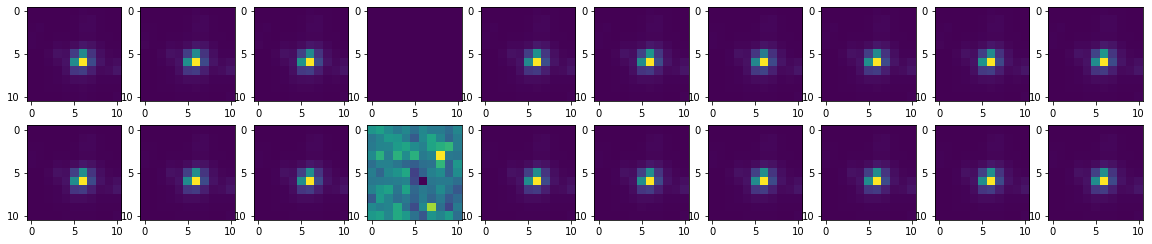

Epoch:  1
Total Loss: 2.585589647293091


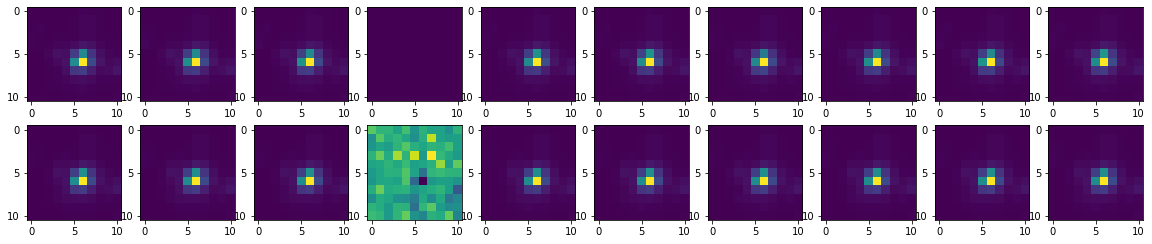

Epoch:  2
Total Loss: 2.3964858055114746


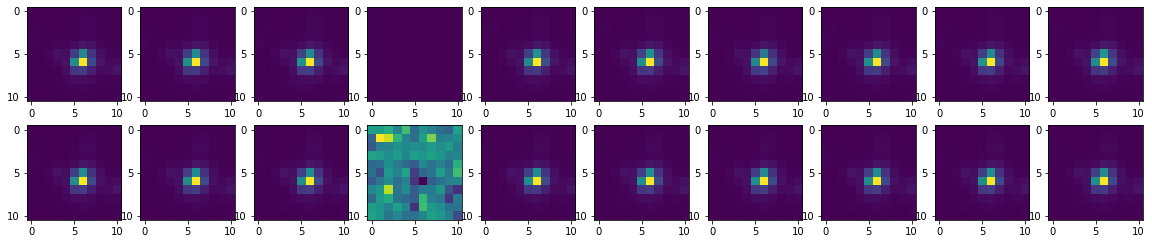

Epoch:  3
Total Loss: 2.7329025268554688


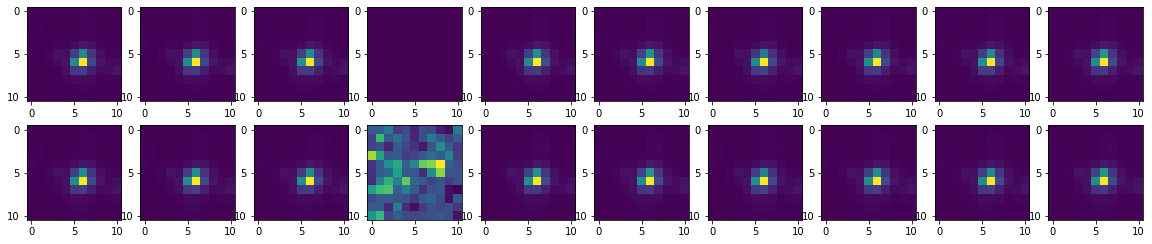

Epoch:  4
Total Loss: 8.487018585205078


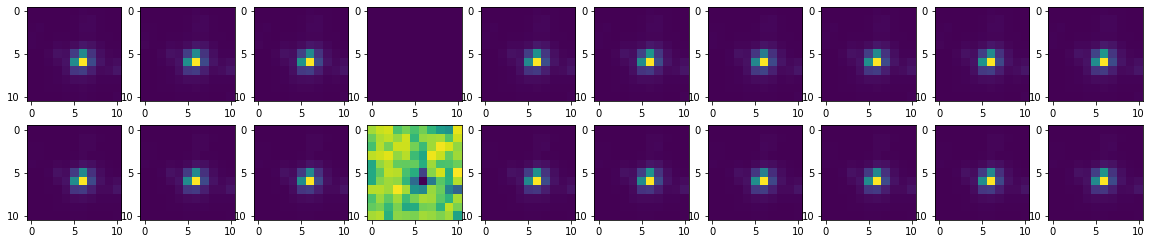

Epoch:  5
Total Loss: 3.319660186767578


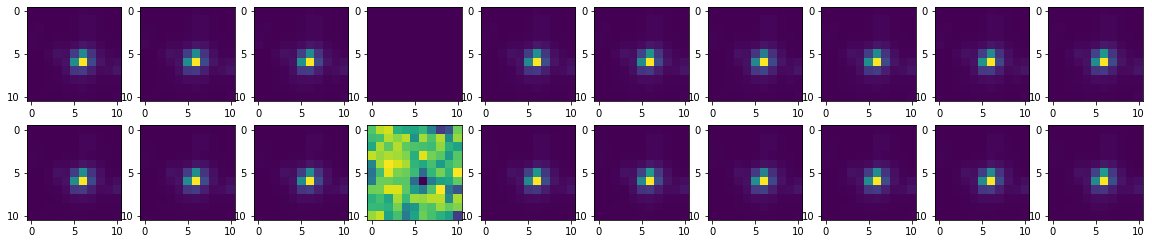

Epoch:  6
Total Loss: 3.334291934967041


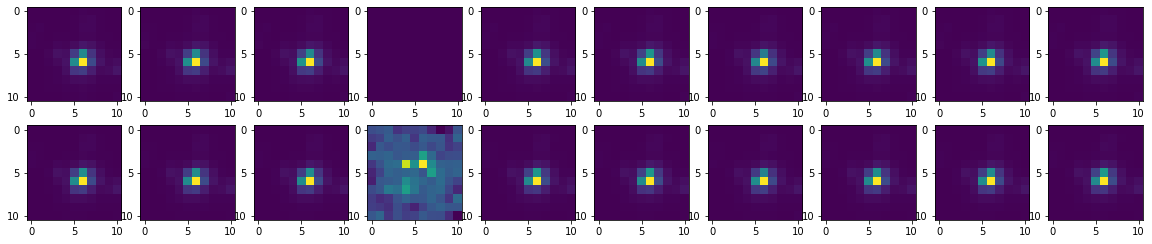

Epoch:  7
Total Loss: 2.303121328353882


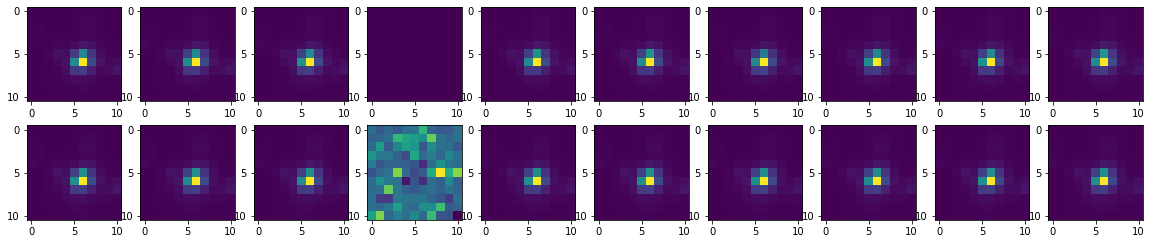

Epoch:  8
Total Loss: 1.98606276512146


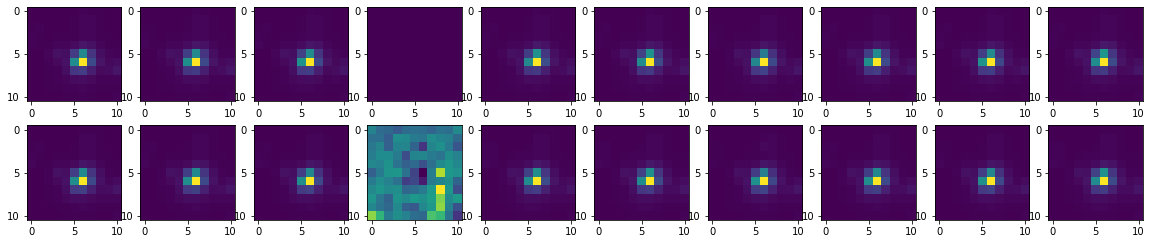

Epoch:  9
Total Loss: 2.192192554473877


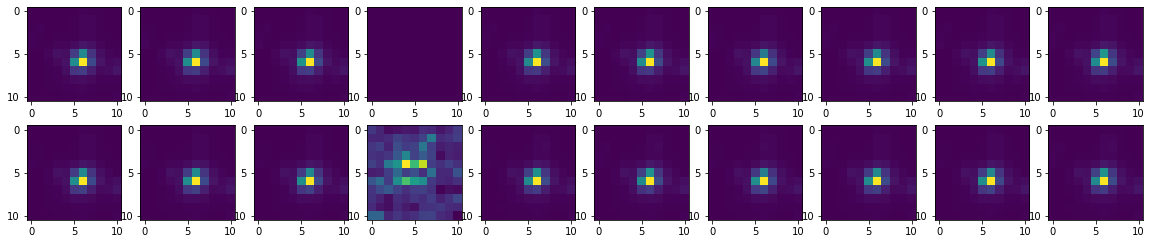

In [48]:
EPOCHES = 10
BATCH_SIZE = 30

#download training data HATP-11
tpf = lk.search_targetpixelfile('HAT-P-11', sector=14, cadence='short').download()

#init model
model_part2 = AutoEncoder()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

#prepare training data
flux_images = np.nan_to_num(tpf.hdu[1].data["FLUX"],nan=0)
flux_images = tf.random.shuffle(flux_images)  
train_images = flux_images[:int(flux_images.shape[0] * 0.9)]
test_images = flux_images[int(flux_images.shape[0] * 0.9):]

#scale image to 0 and 1
test_images = test_images / np.max(np.abs(flux_images))
train_images = train_images / np.max(np.abs(flux_images))

#show exmple images, note the differences are small
example_images = test_images[:EXAMPLES]
print("Difference between test images shown",np.sum(np.abs(test_images[2]-test_images[1])))

# uncomment below to see if the network is doing sth
#for noise_function in [random_noise, no_noise]:
for noise_function in [no_noise]:  
  for i in range(EPOCHES):
    for j in range(0, len(train_images), BATCH_SIZE):     
      train(model_part2, optimizer, train_images[j:j+BATCH_SIZE], noise_function)
  
    print("Epoch: ", i)
    sum_loss = total_loss(model_part2, test_images, noise_function)
    print("Total Loss: {0}".format(sum_loss))
    showImages(model_part2, noise_function, example_images)


### Training with 30 lightcurves to compare with part 3, takes 1 hour

TOI-163
HD_219666
TOI-640
TOI-157
LHS_1815
TOI-1235
TOI-251
LP_714-47
TOI-122
GJ_1252
TOI-172
TOI-169
TOI-674
TOI-954
TOI-1685
TOI-837
TOI-519
TOI-1728
TOI-540
TOI-824
LTT_9779
HIP_67522
LHS_1478
TOI-150
LHS_3844
TOI-132
L_168-9
TOI-905
HD_2685
TOI-269


TOI-237
difference between test images 0.035297293
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 1.0863683223724365


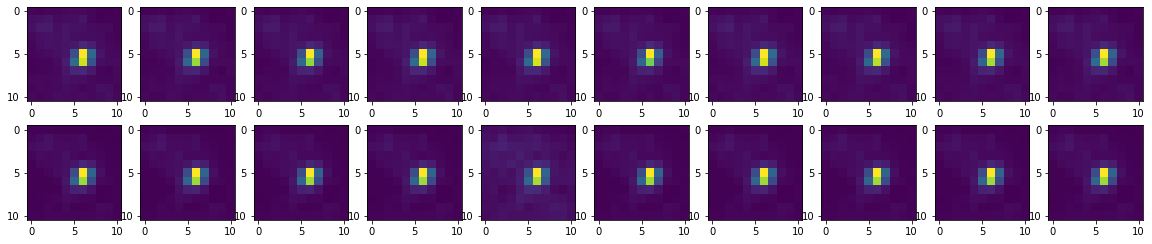

Epoch:  1
Total Loss: 9.980881690979004


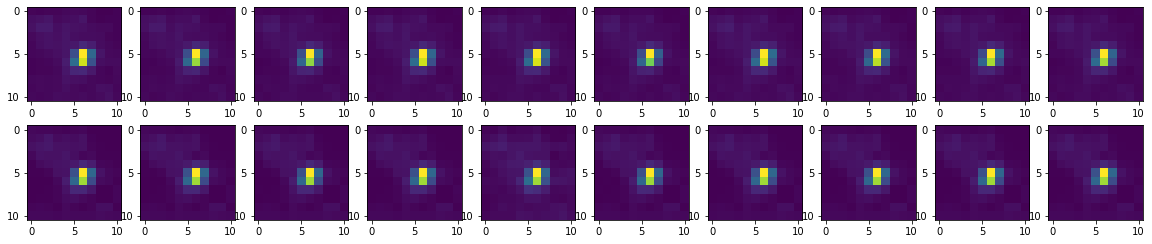

Epoch:  2
Total Loss: 2.0383567810058594


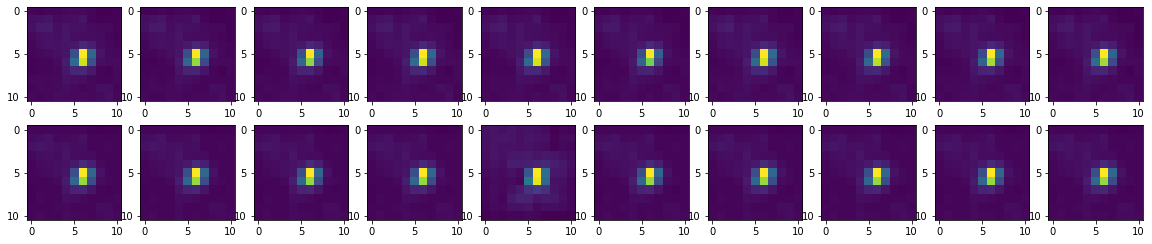

Epoch:  3
Total Loss: 2.4698166847229004


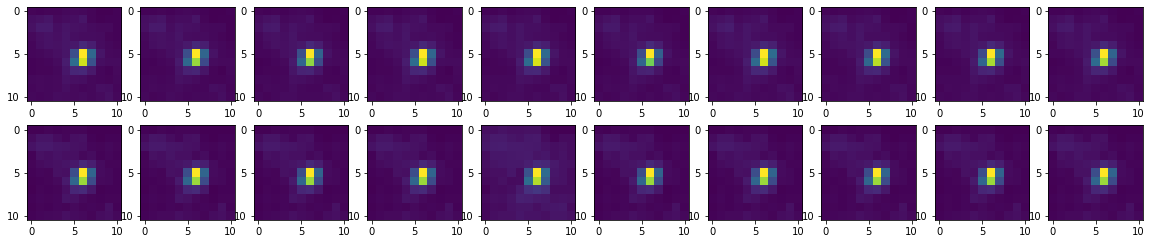

Epoch:  4
Total Loss: 1.996415376663208


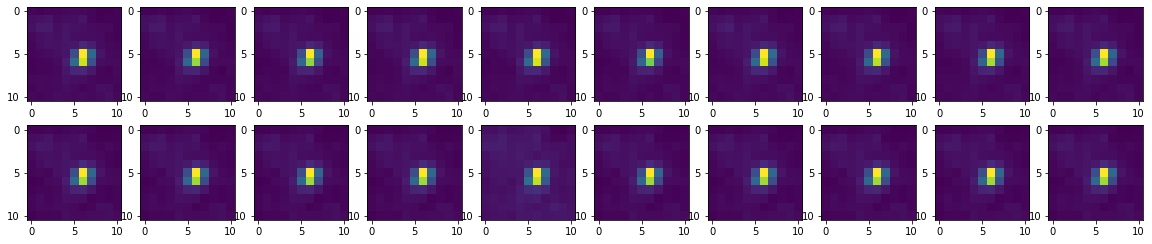

Epoch:  5
Total Loss: 4.514509201049805


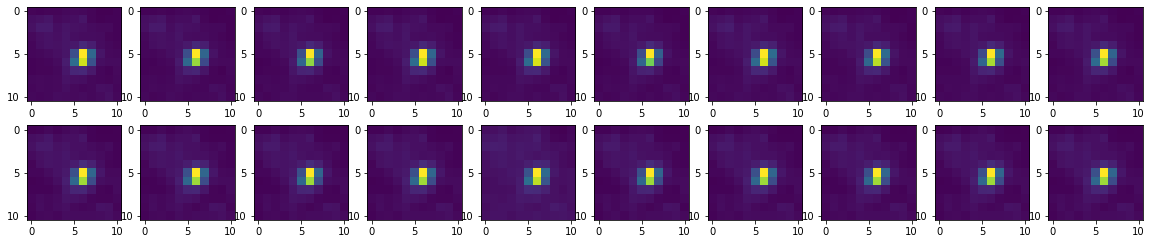

Epoch:  6
Total Loss: 0.8744900226593018


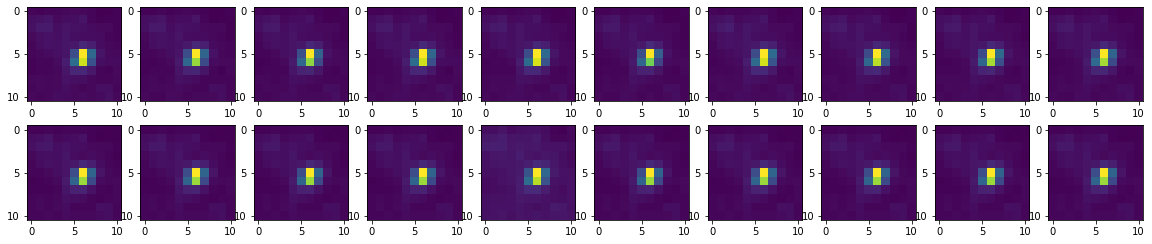

Epoch:  7
Total Loss: 6.560091495513916


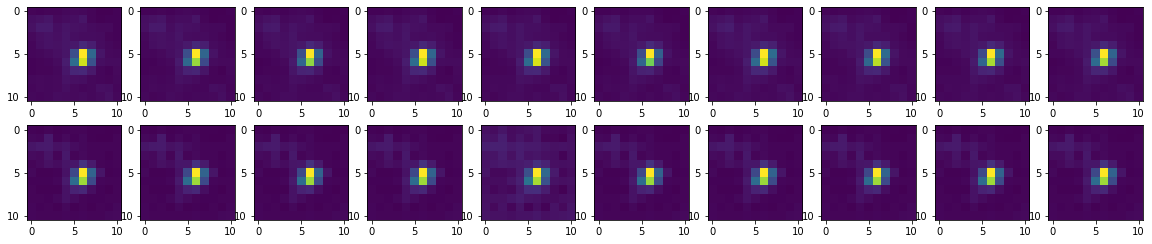

Epoch:  8
Total Loss: 0.8386210203170776


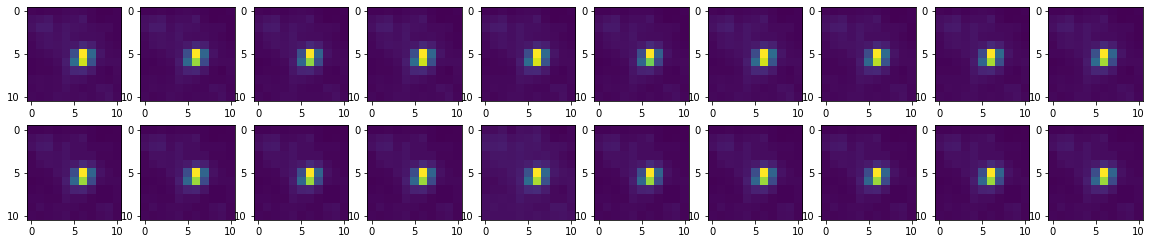

Epoch:  9
Total Loss: 15.427249908447266


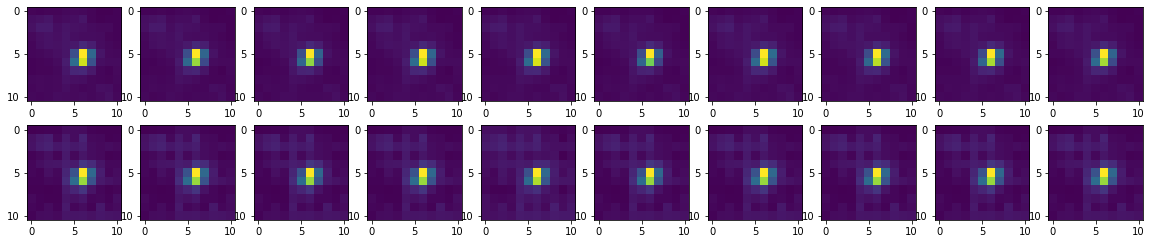

difference between test images 0.04610487
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 2.0058364868164062


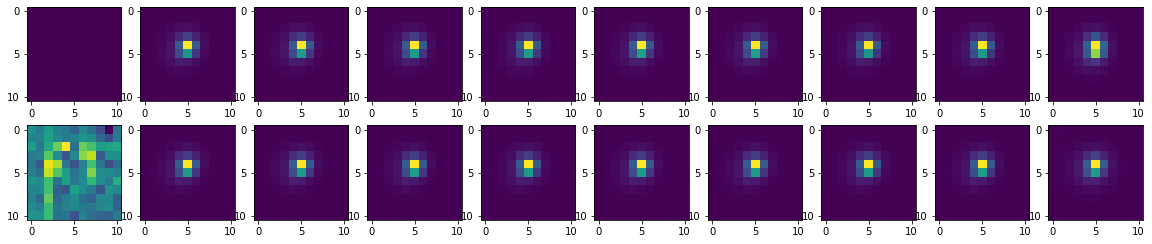

Epoch:  1
Total Loss: 1.7099504470825195


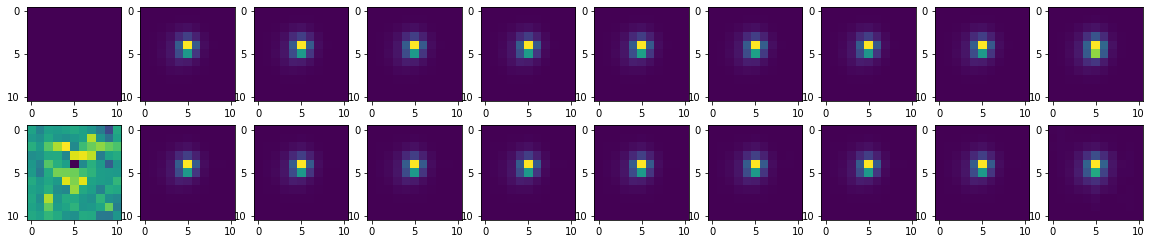

Epoch:  2
Total Loss: 1.8018481731414795


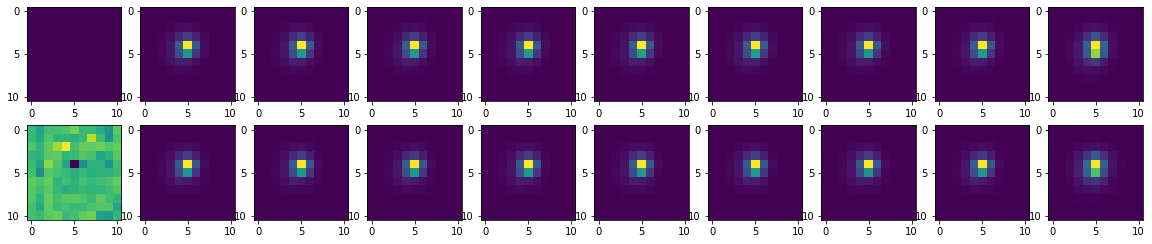

Epoch:  3
Total Loss: 1.6865538358688354


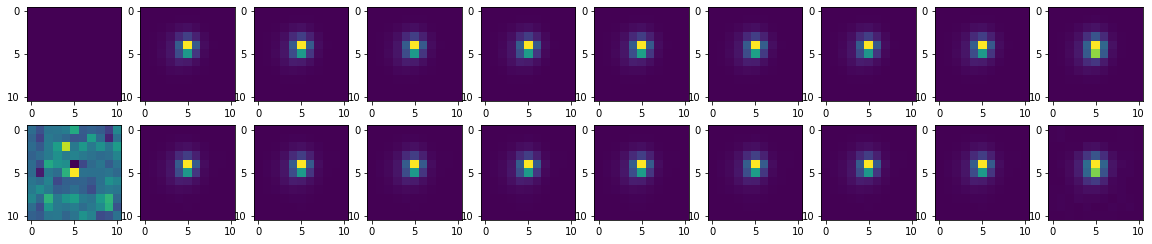

Epoch:  4
Total Loss: 1.4019355773925781


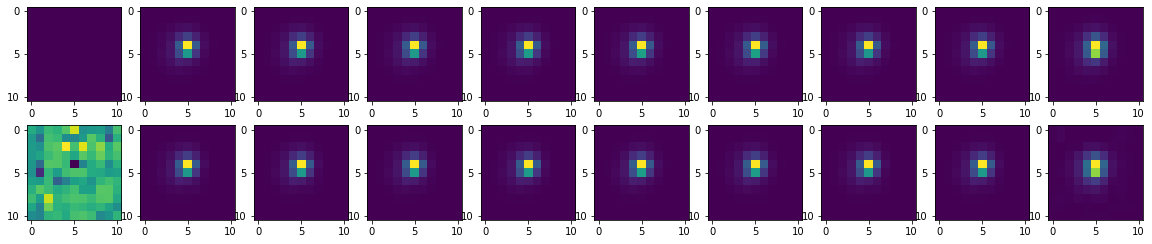

Epoch:  5
Total Loss: 2.6237916946411133


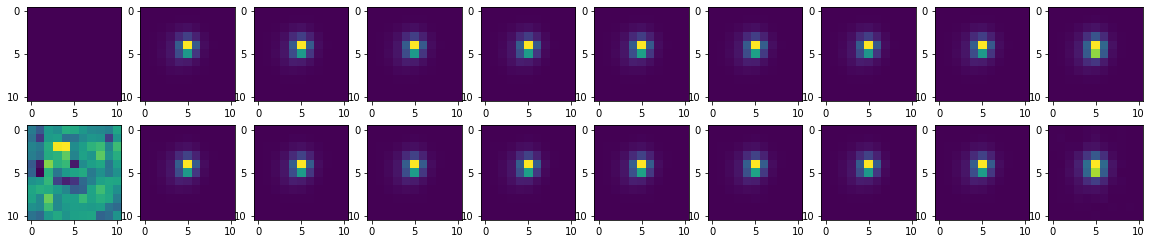

Epoch:  6
Total Loss: 2.439873218536377


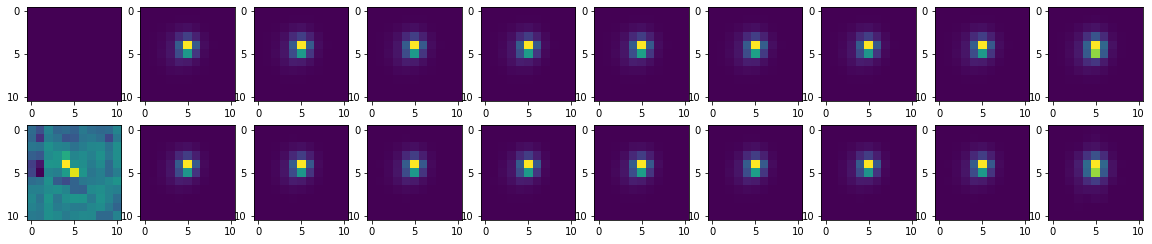

Epoch:  7
Total Loss: 0.7853174209594727


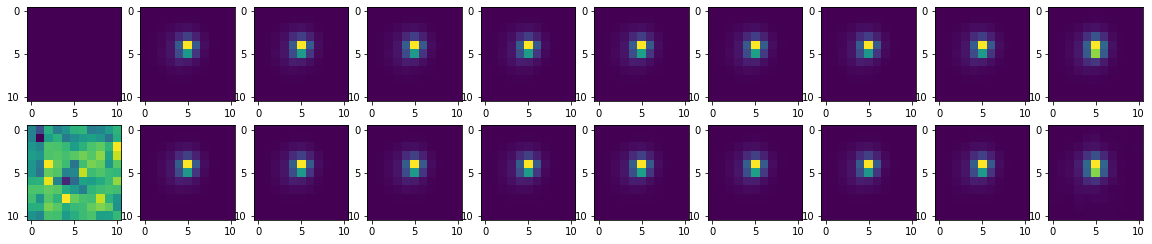

Epoch:  8
Total Loss: 1.033494472503662


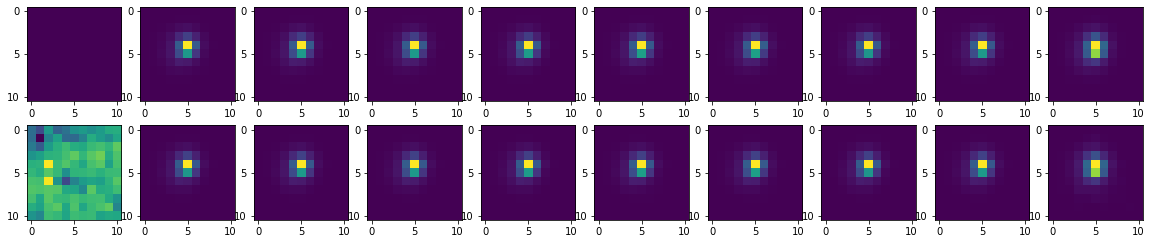

Epoch:  9
Total Loss: 1.8659234046936035


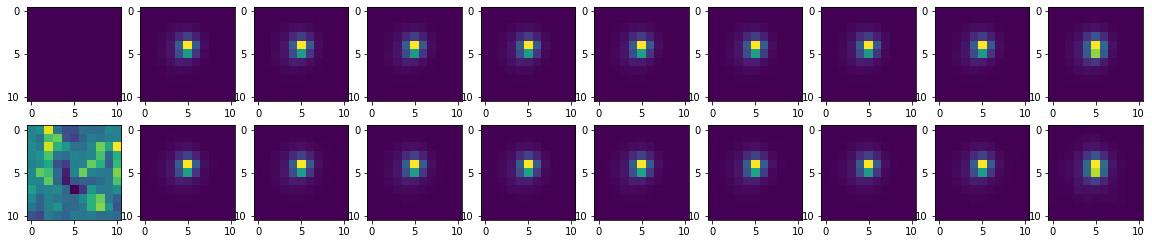

difference between test images 0.22985677
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 0.48629677295684814


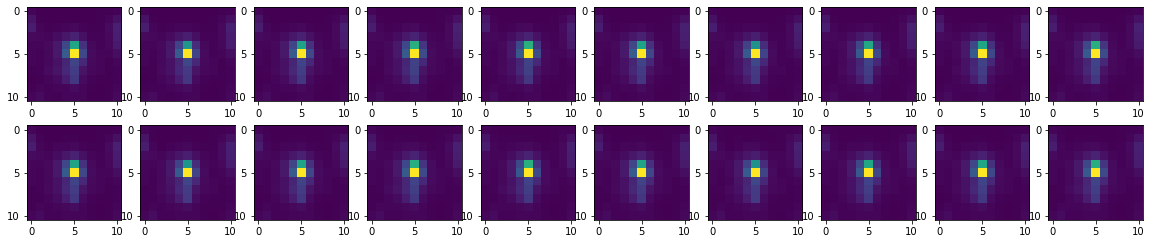

Epoch:  1
Total Loss: 0.27388811111450195


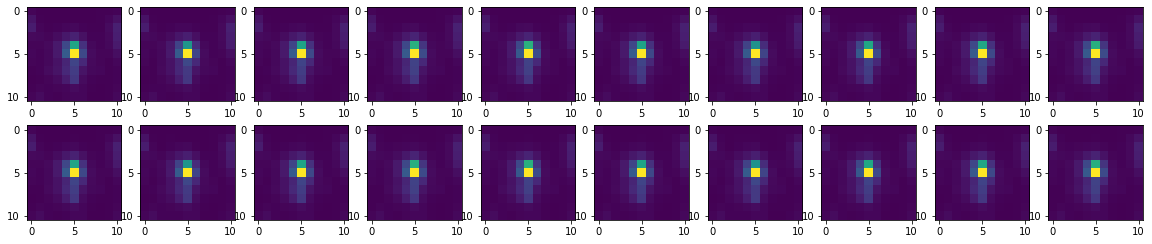

Epoch:  2
Total Loss: 0.722322404384613


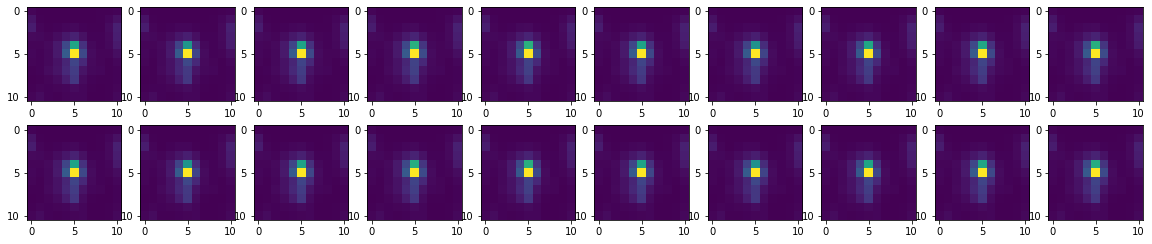

Epoch:  3
Total Loss: 0.44053393602371216


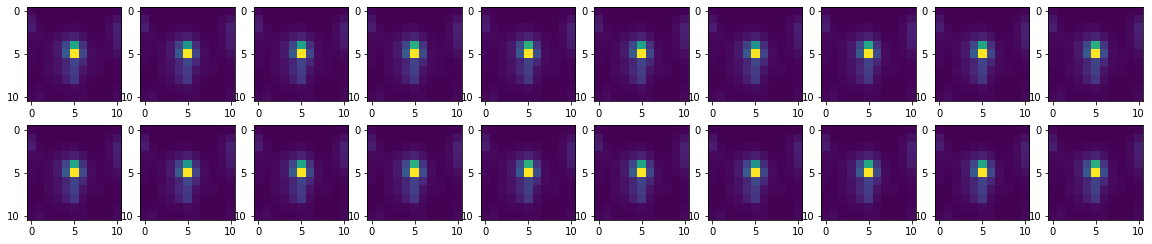

Epoch:  4
Total Loss: 0.6731692552566528


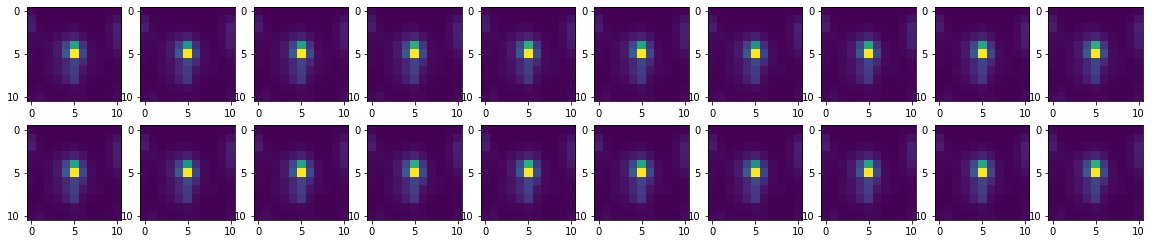

Epoch:  5
Total Loss: 0.3550857901573181


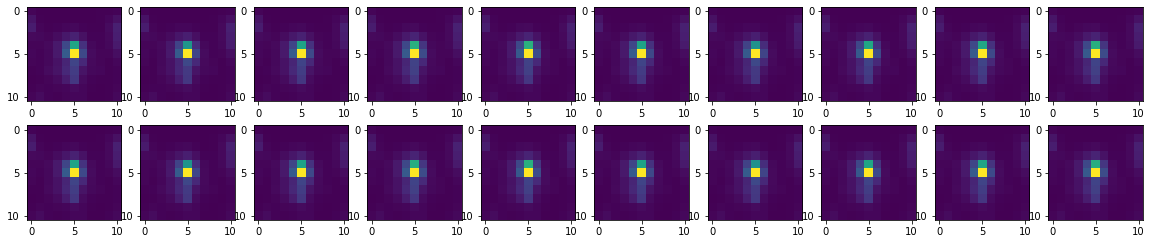

Epoch:  6
Total Loss: 0.6510649919509888


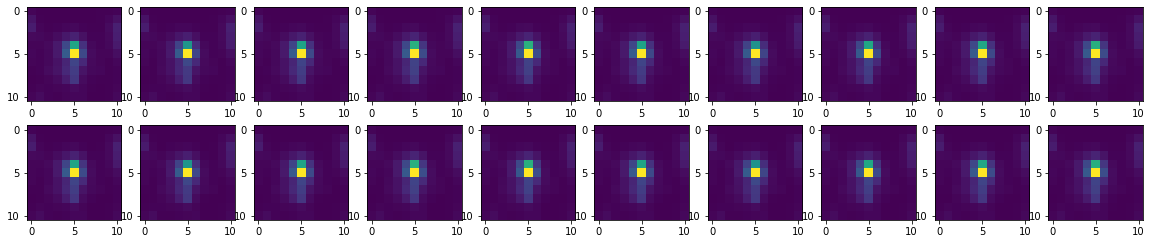

Epoch:  7
Total Loss: 1.2381682395935059


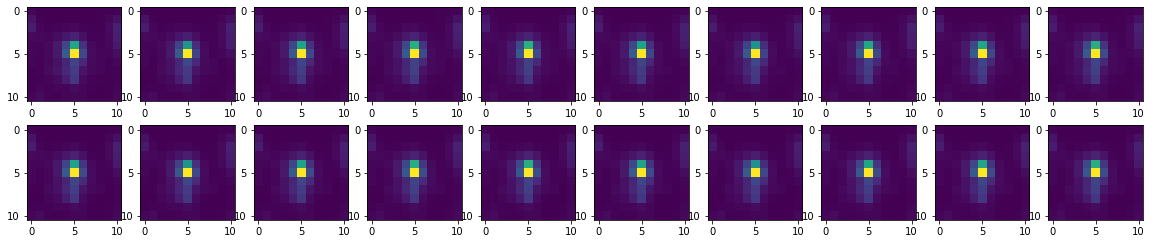

Epoch:  8
Total Loss: 1.0129159688949585


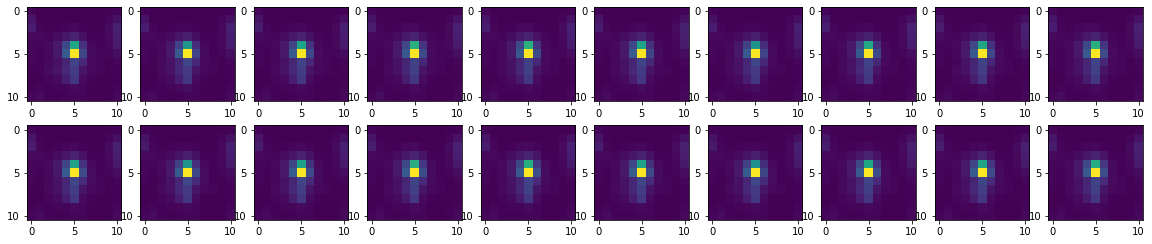

Epoch:  9
Total Loss: 0.7333786487579346


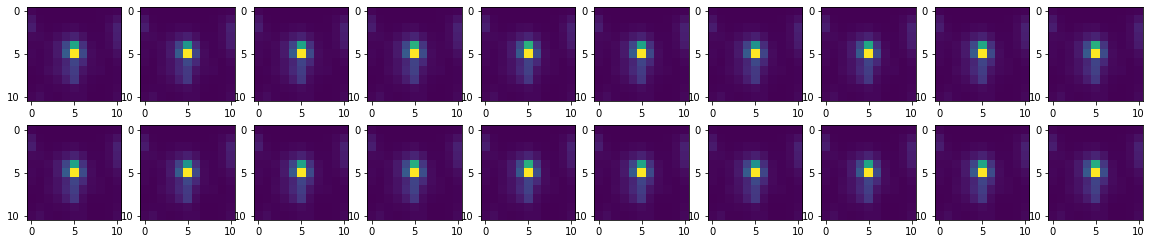

difference between test images 0.073132135
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 7.485708236694336


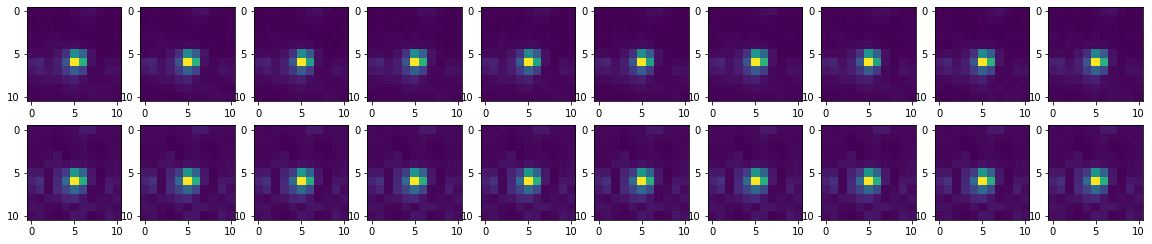

Epoch:  1
Total Loss: 4.268545150756836


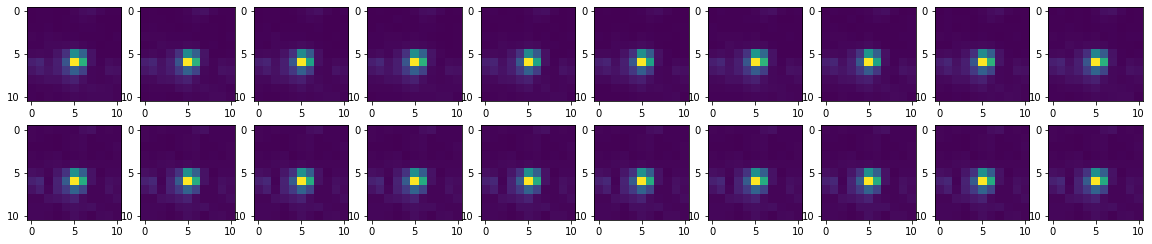

Epoch:  2
Total Loss: 3.167508363723755


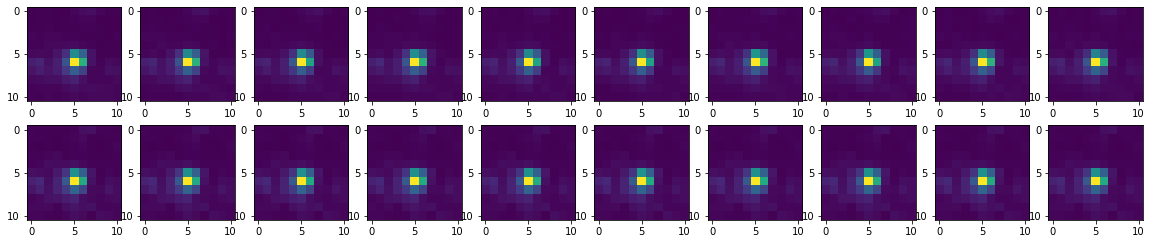

Epoch:  3
Total Loss: 4.571345806121826


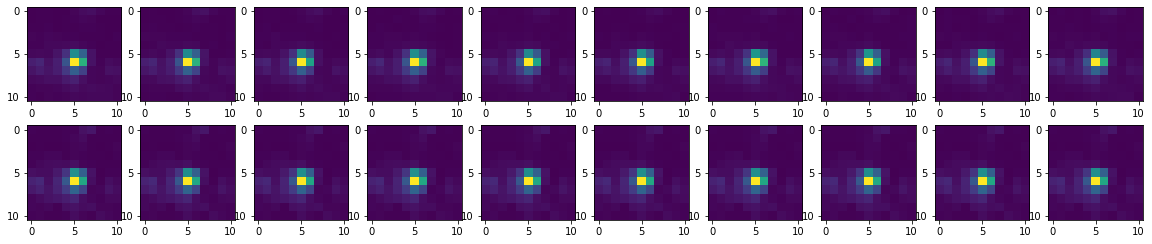

Epoch:  4
Total Loss: 103.92095947265625


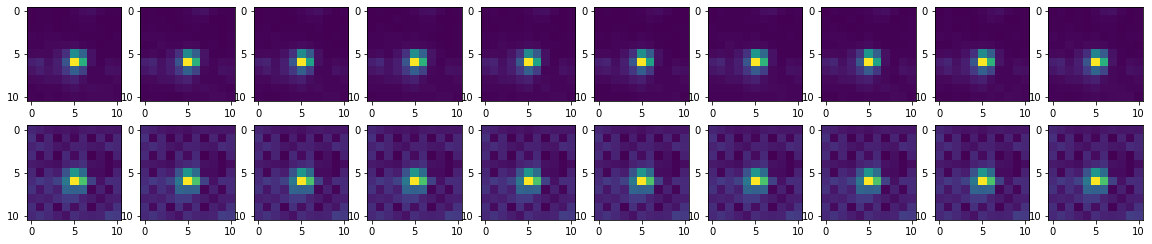

Epoch:  5
Total Loss: 0.9942477941513062


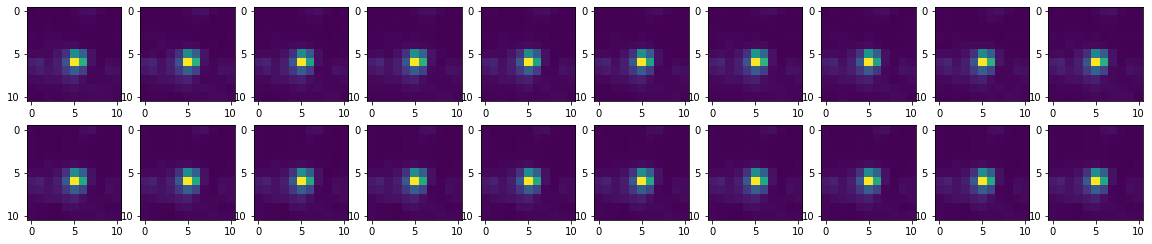

Epoch:  6
Total Loss: 506.64794921875


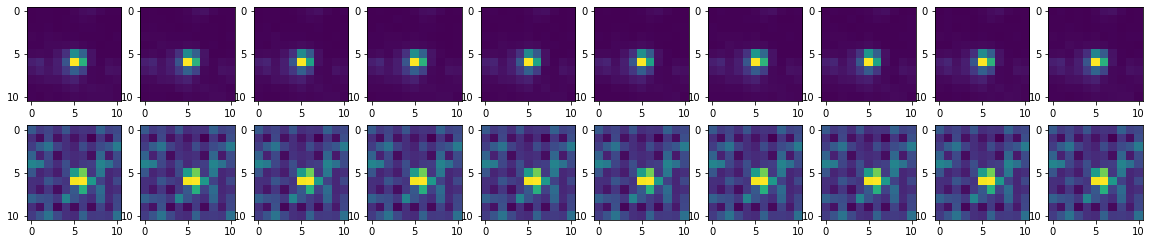

Epoch:  7
Total Loss: 1.2983717918395996


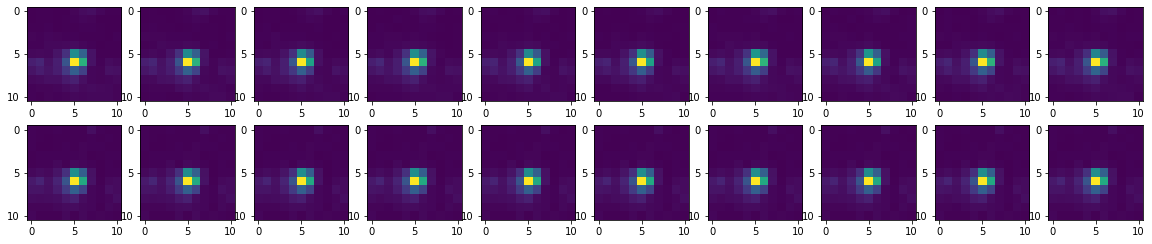

Epoch:  8
Total Loss: 0.6408851742744446


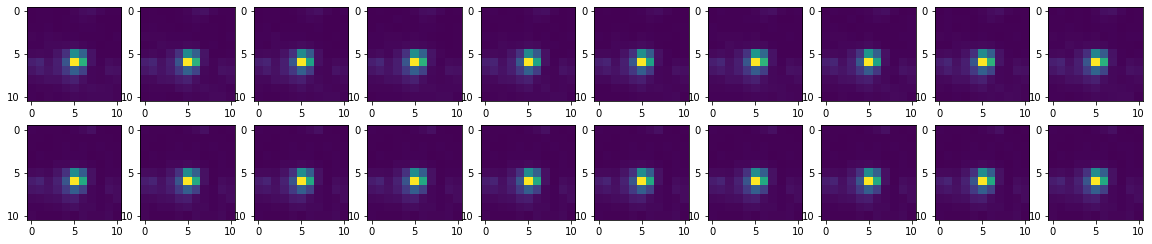

Epoch:  9
Total Loss: 0.5951798558235168


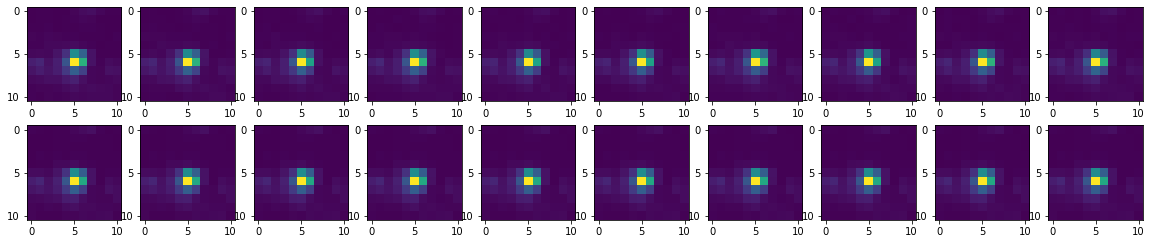

difference between test images 0.2552451
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 7.611799716949463


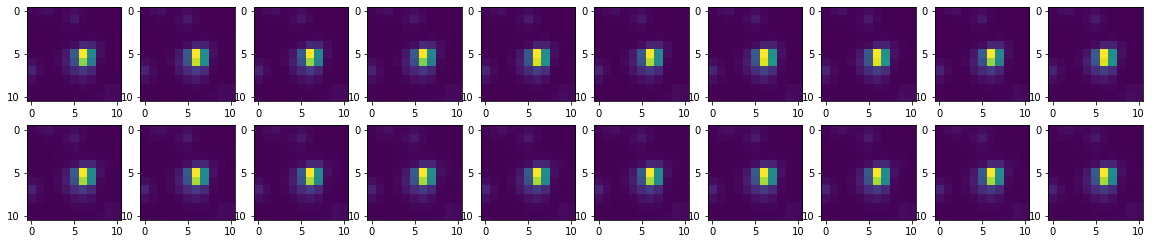

Epoch:  1
Total Loss: 6.729345798492432


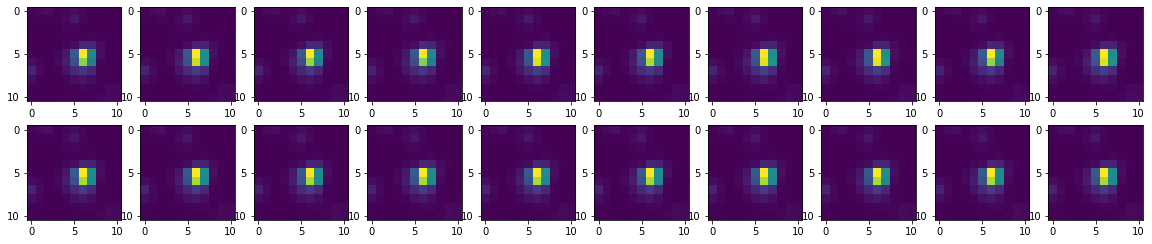

Epoch:  2
Total Loss: 6.450536727905273


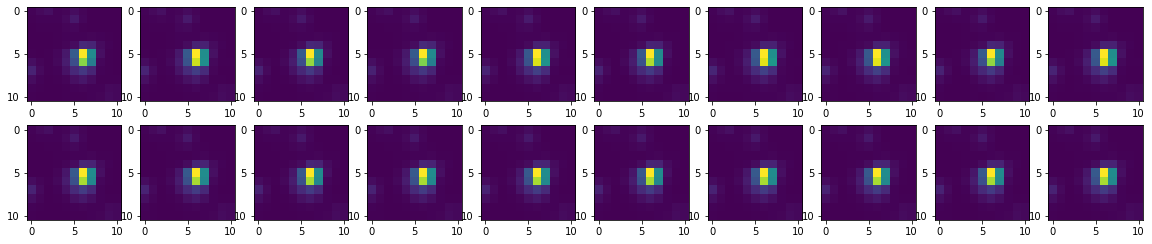

Epoch:  3
Total Loss: 2.4223015308380127


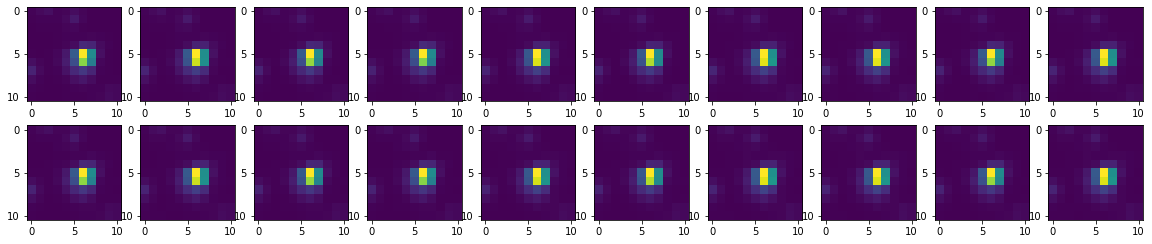

Epoch:  4
Total Loss: 1.908886432647705


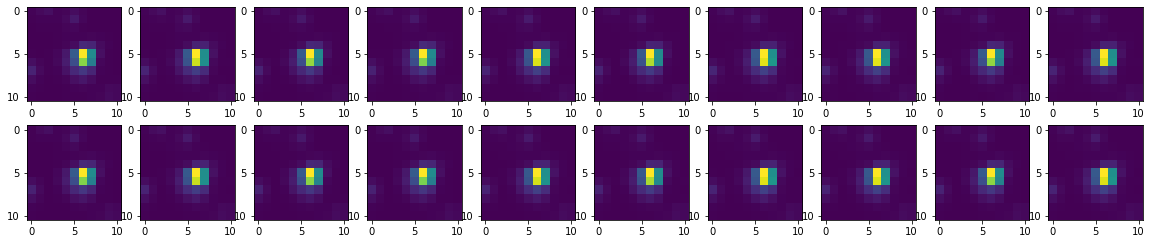

Epoch:  5
Total Loss: 1.8333076238632202


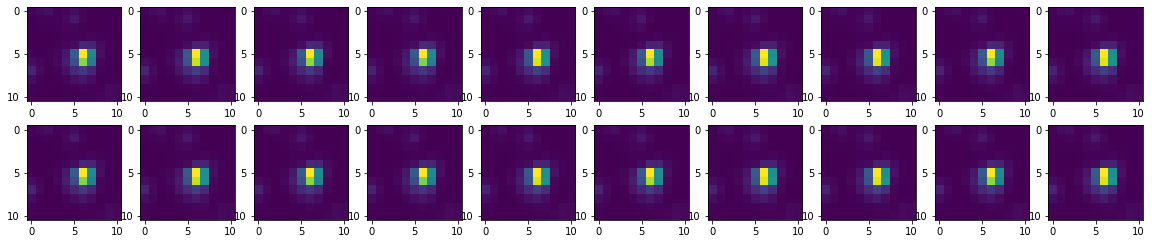

Epoch:  6
Total Loss: 1.7647674083709717


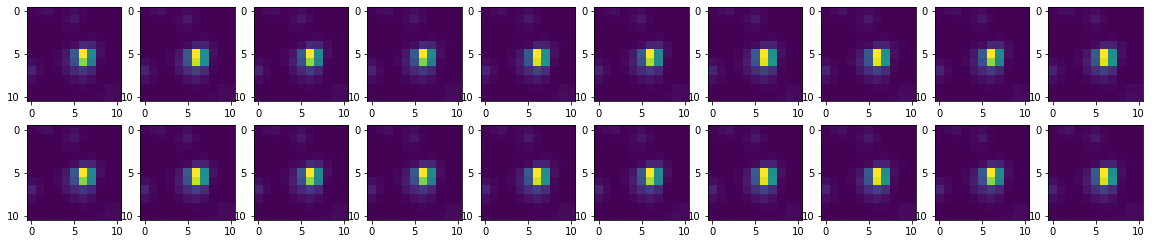

Epoch:  7
Total Loss: 1.6630669832229614


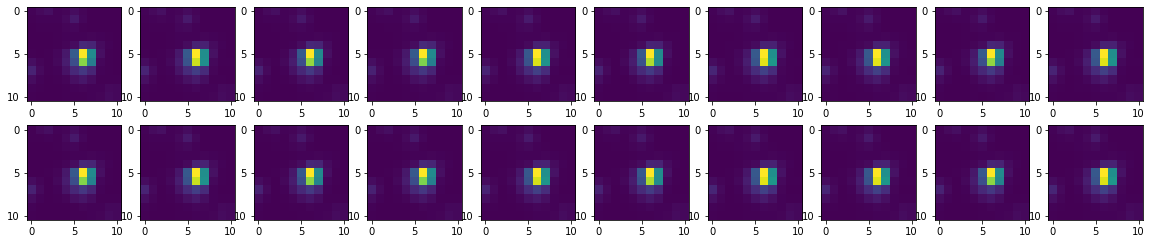

Epoch:  8
Total Loss: 1.5843396186828613


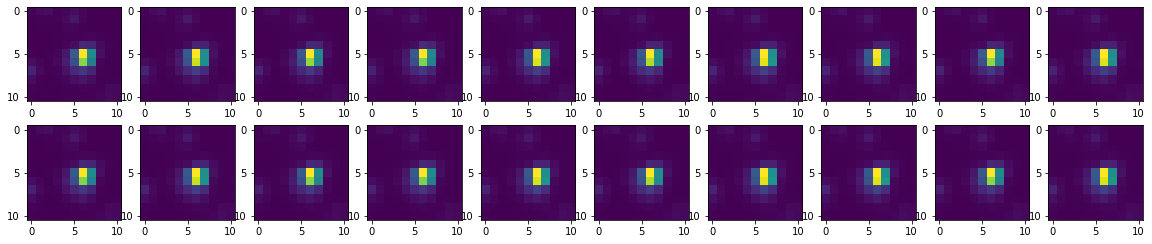

Epoch:  9
Total Loss: 1.6638083457946777


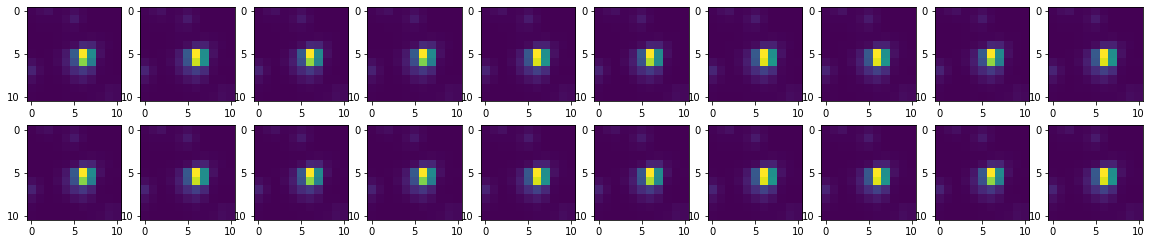

difference between test images 0.23224878
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 2.168304443359375


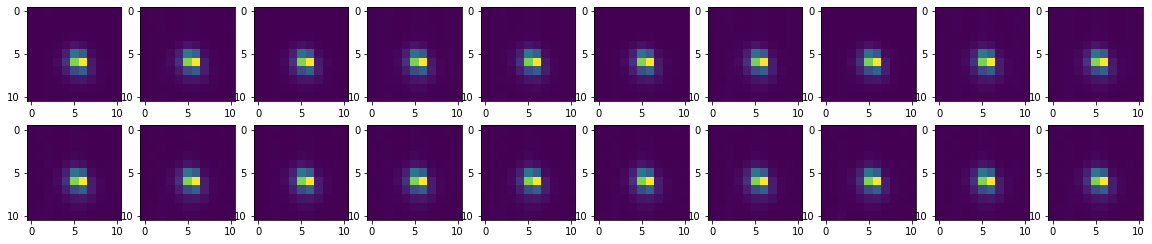

Epoch:  1
Total Loss: 1.4940203428268433


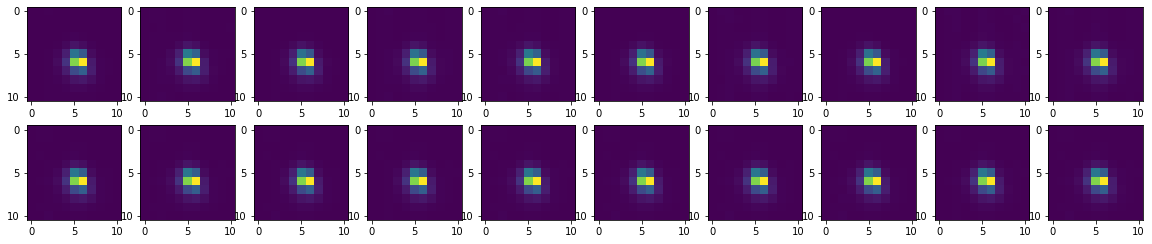

Epoch:  2
Total Loss: 1.427499532699585


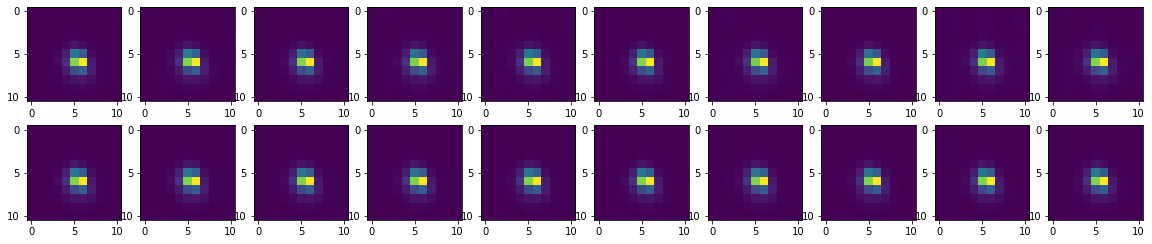

Epoch:  3
Total Loss: 1.4927408695220947


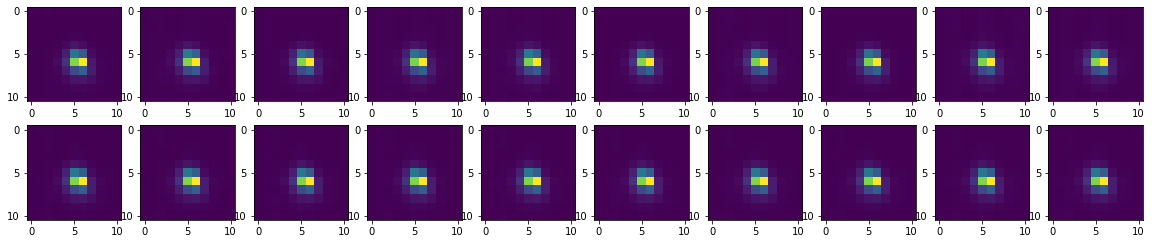

Epoch:  4
Total Loss: 1.3864989280700684


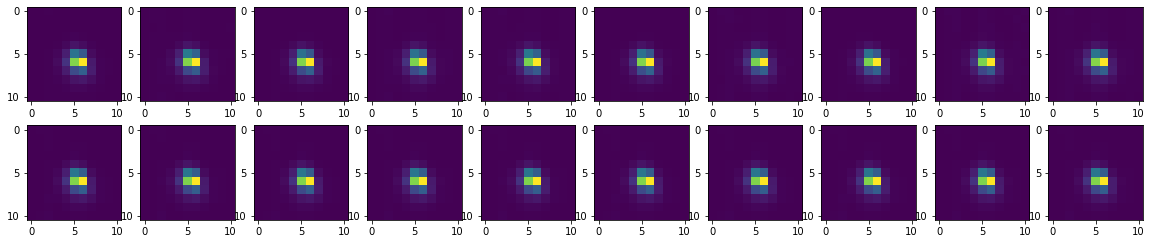

Epoch:  5
Total Loss: 1.3733837604522705


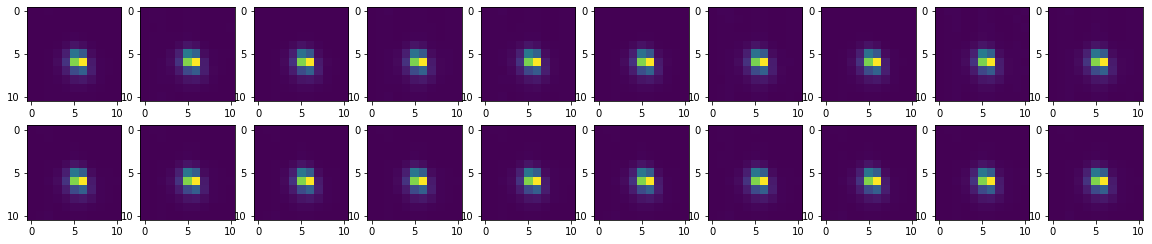

Epoch:  6
Total Loss: 1.3818367719650269


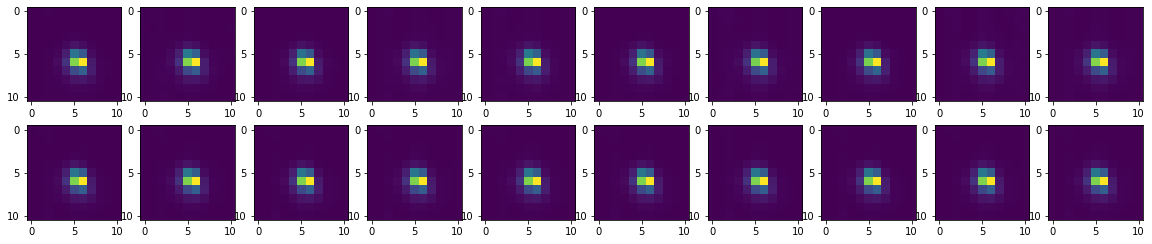

Epoch:  7
Total Loss: 0.35864612460136414


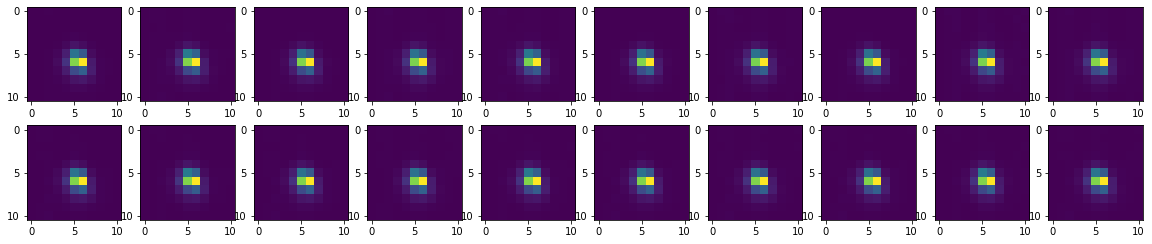

Epoch:  8
Total Loss: 0.374323308467865


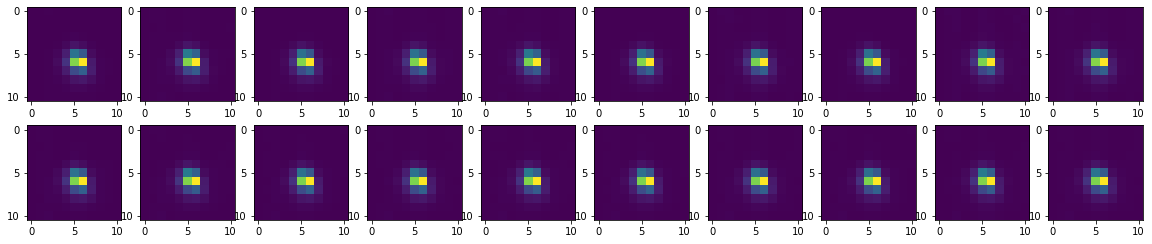

Epoch:  9
Total Loss: 0.4862329959869385


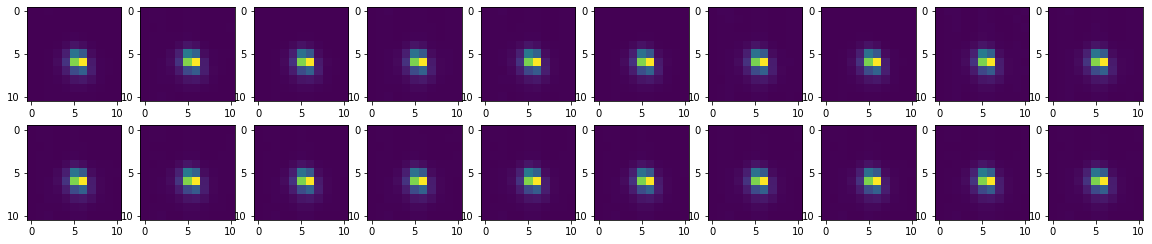

difference between test images 0.3000031
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 4.263097763061523


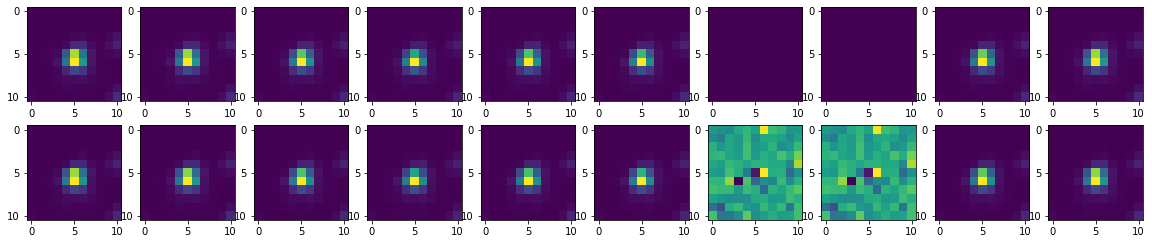

Epoch:  1
Total Loss: 2.002305030822754


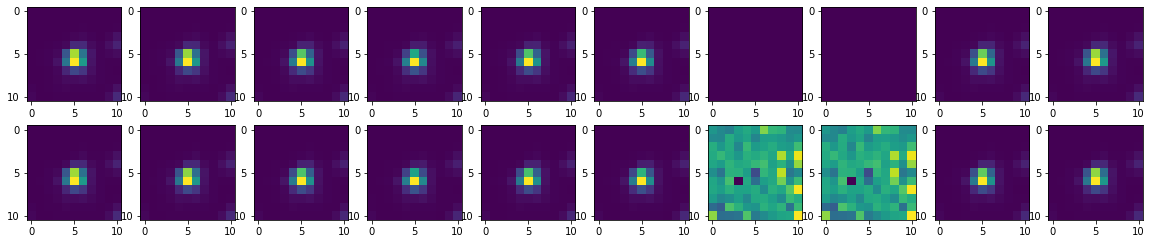

Epoch:  2
Total Loss: 2.4386839866638184


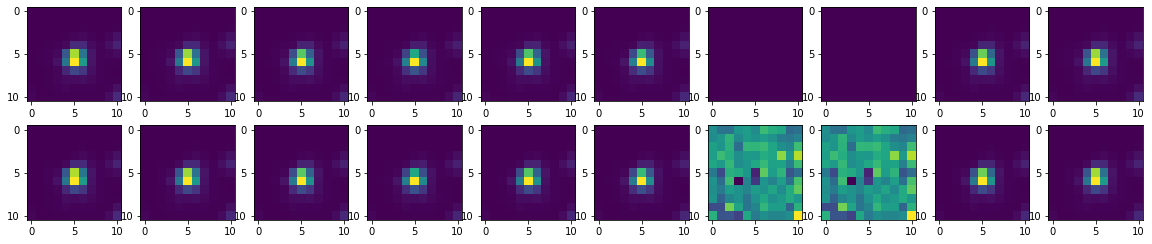

Epoch:  3
Total Loss: 1.8151180744171143


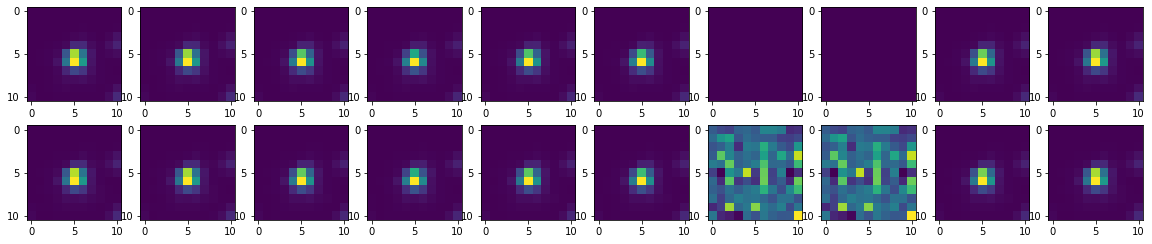

Epoch:  4
Total Loss: 1.8751661777496338


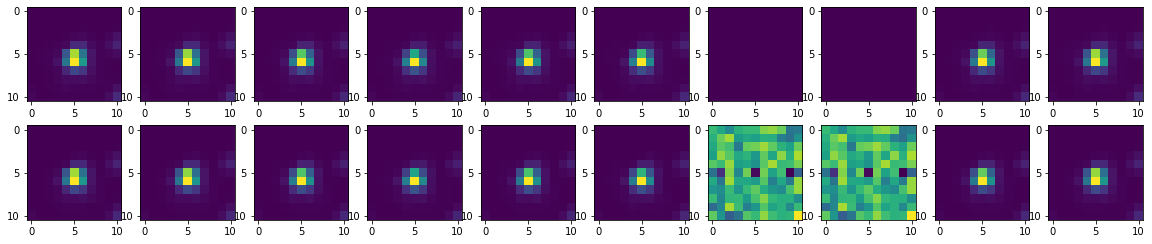

Epoch:  5
Total Loss: 1.1392416954040527


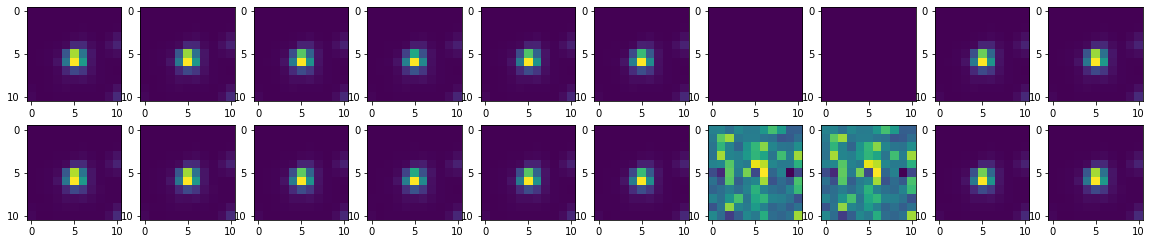

Epoch:  6
Total Loss: 1.553077220916748


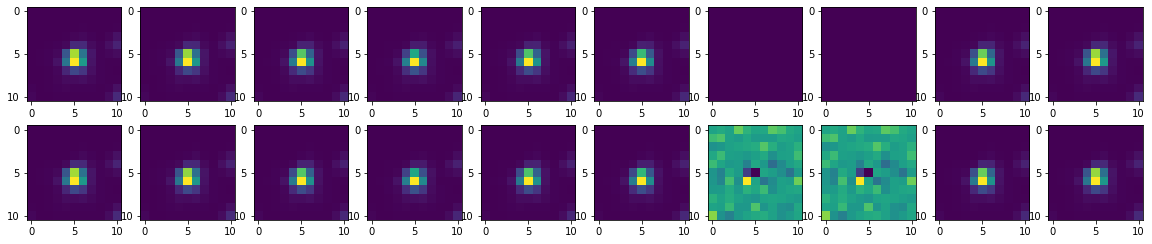

Epoch:  7
Total Loss: 2.2084734439849854


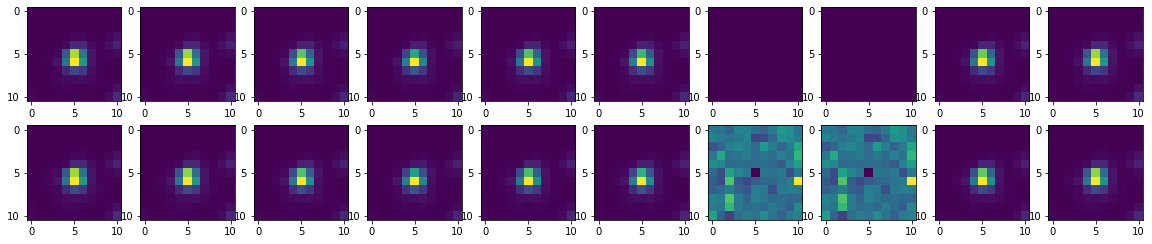

Epoch:  8
Total Loss: 2.794440507888794


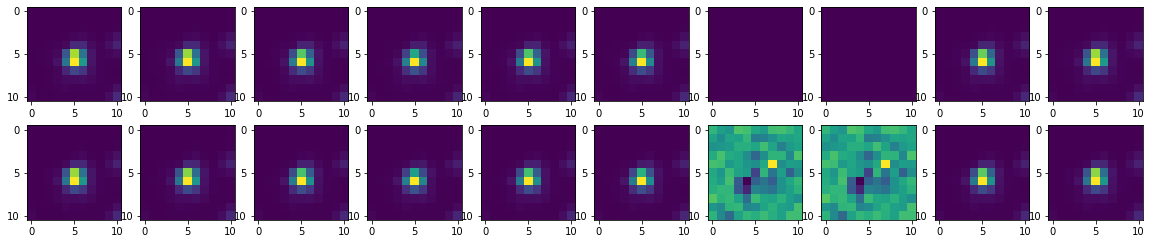

Epoch:  9
Total Loss: 2.8730244636535645


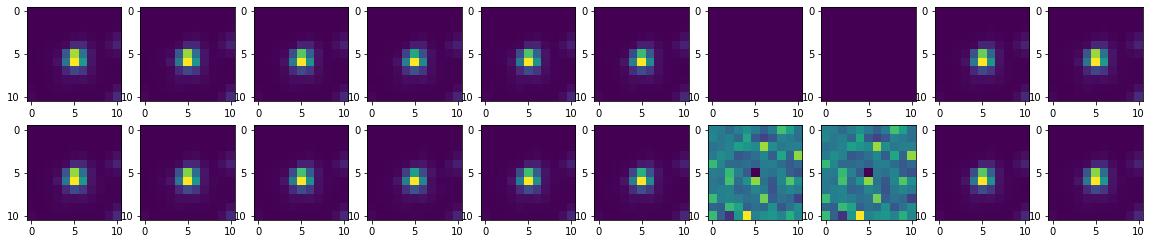

difference between test images 0.40169227
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 6.453516006469727


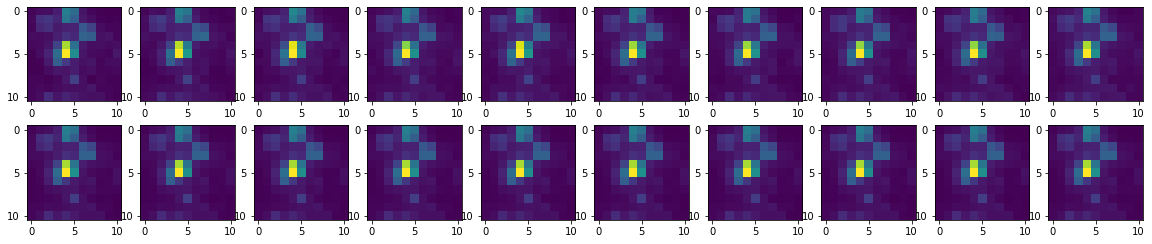

Epoch:  1
Total Loss: 4.421089172363281


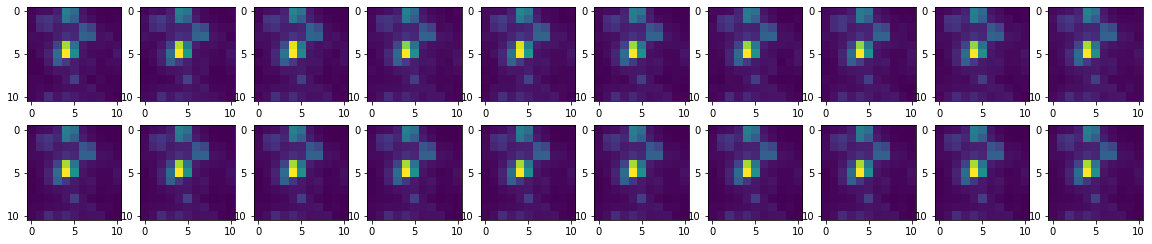

Epoch:  2
Total Loss: 3.9969189167022705


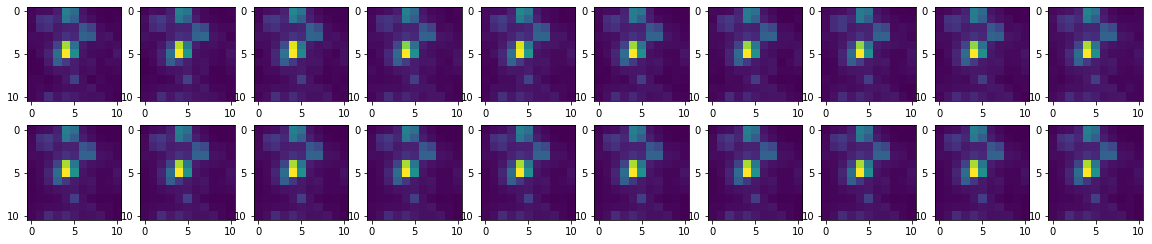

Epoch:  3
Total Loss: 3.9178237915039062


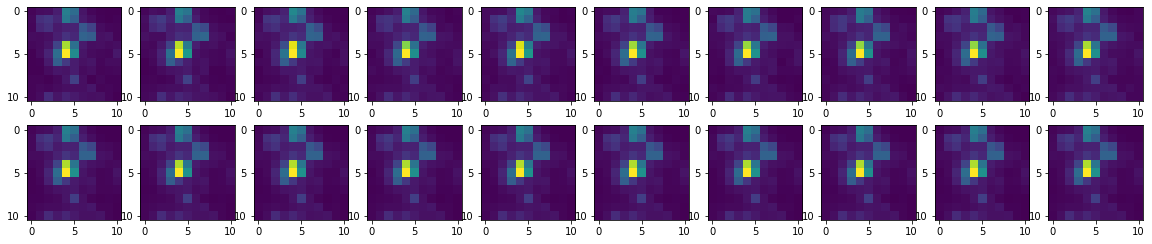

Epoch:  4
Total Loss: 4.109524250030518


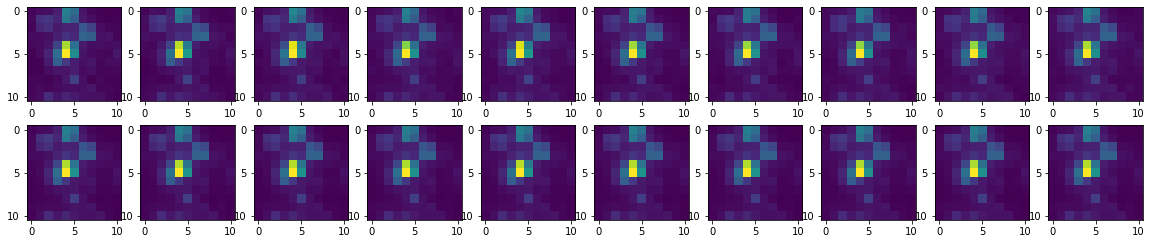

Epoch:  5
Total Loss: 6.848241329193115


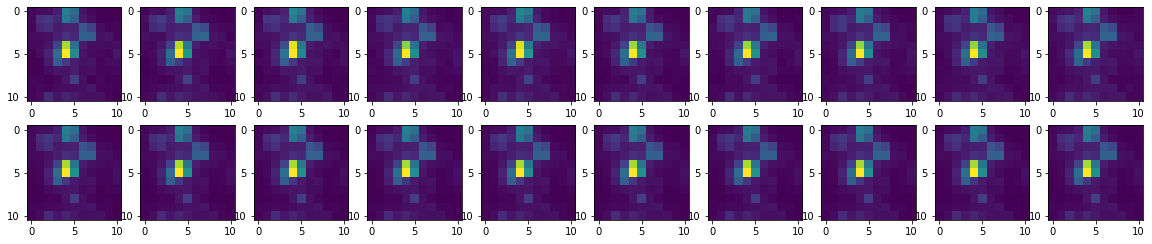

Epoch:  6
Total Loss: 6.269698143005371


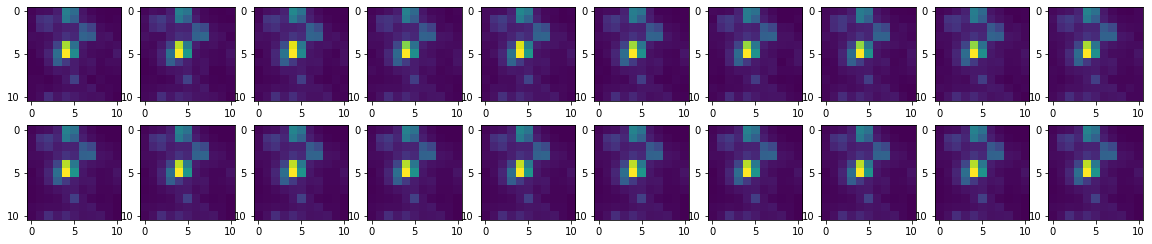

Epoch:  7
Total Loss: 4.593101978302002


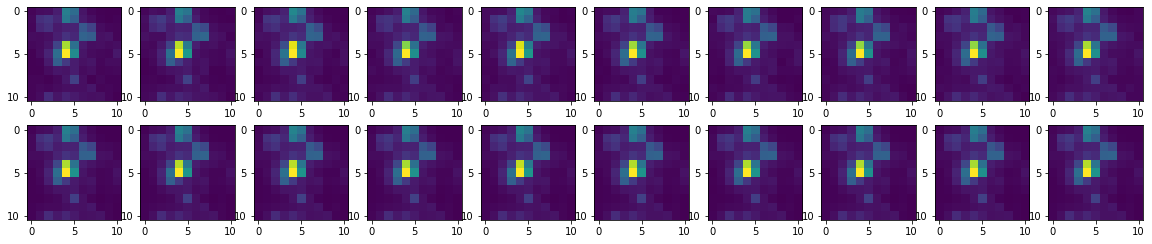

Epoch:  8
Total Loss: 4.894050598144531


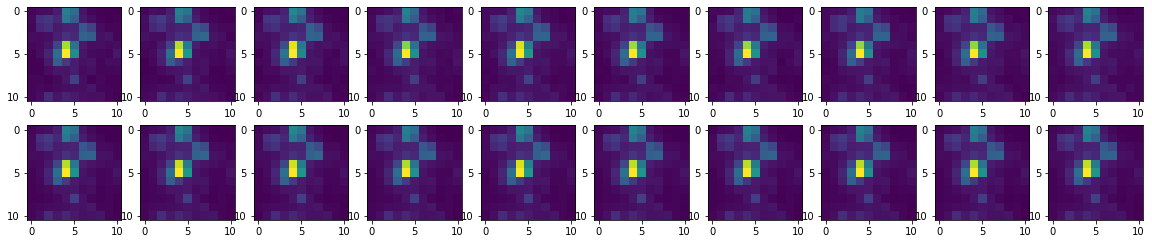

Epoch:  9
Total Loss: 3.8752622604370117


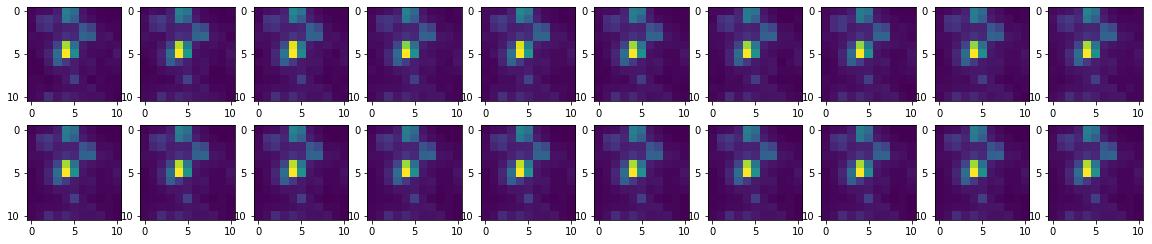

difference between test images 0.13319235
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 6.2085652351379395


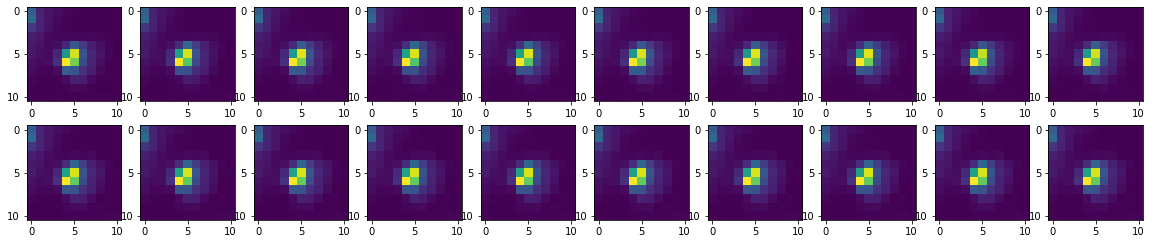

Epoch:  1
Total Loss: 4.235345363616943


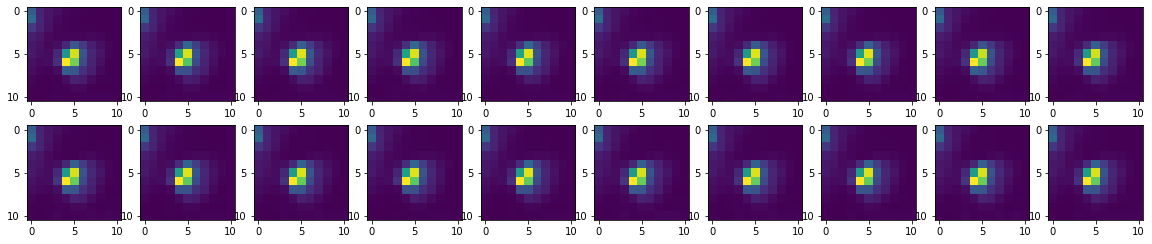

Epoch:  2
Total Loss: 8.511674880981445


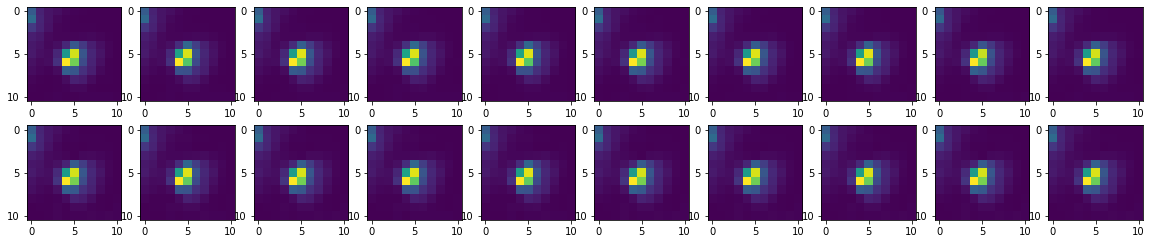

Epoch:  3
Total Loss: 5.648746013641357


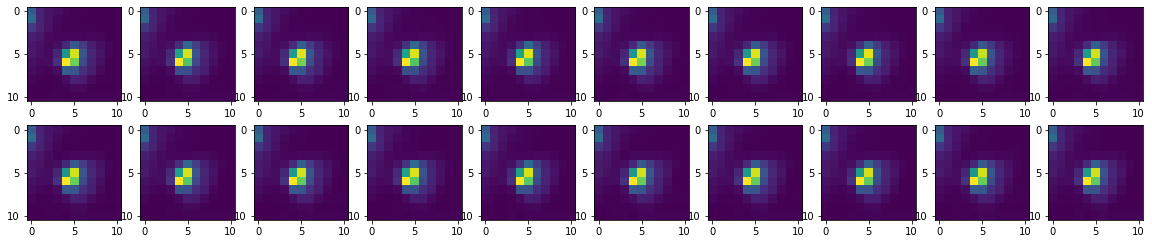

Epoch:  4
Total Loss: 5.352285385131836


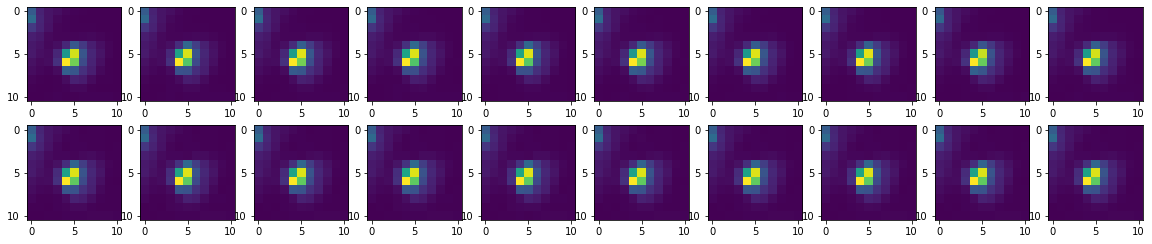

Epoch:  5
Total Loss: 6.9636921882629395


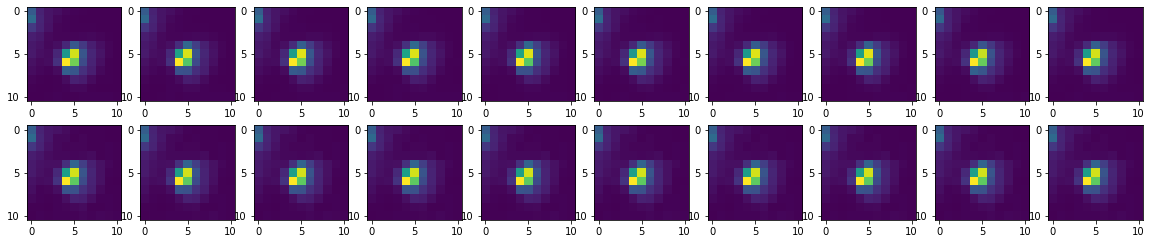

Epoch:  6
Total Loss: 5.509391784667969


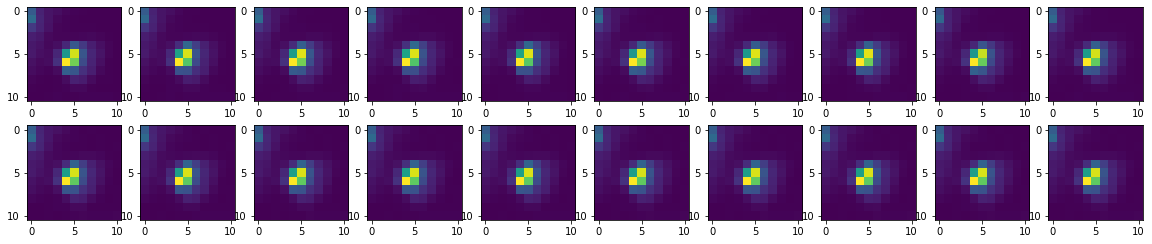

Epoch:  7
Total Loss: 4.721823215484619


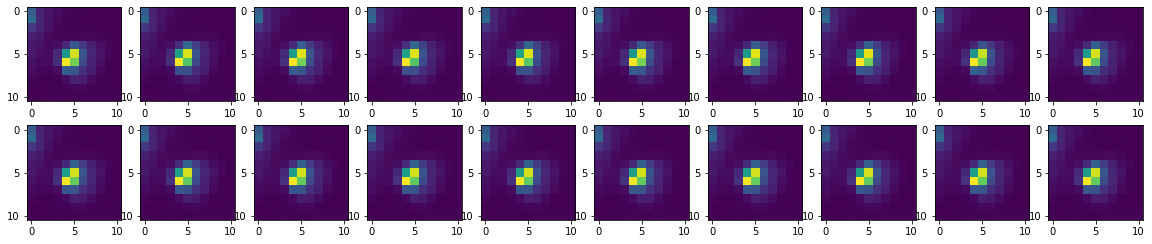

Epoch:  8
Total Loss: 4.623144626617432


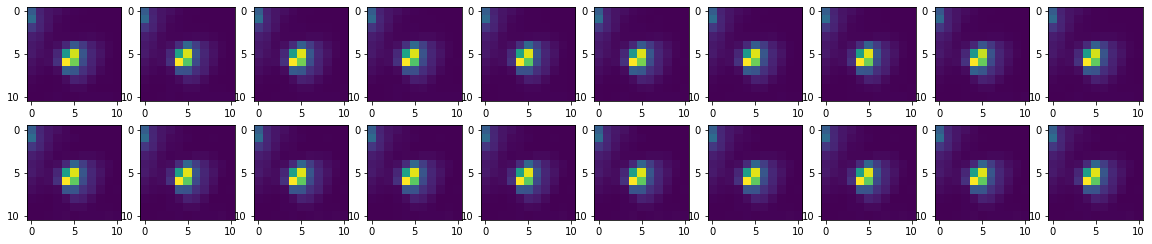

Epoch:  9
Total Loss: 4.56439733505249


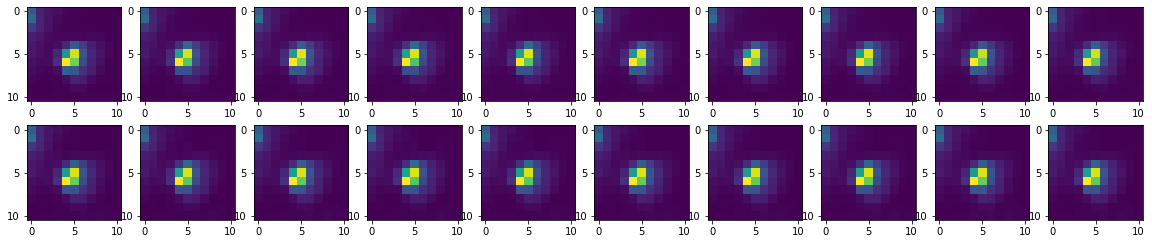

difference between test images 0.5988277
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 2.726863145828247


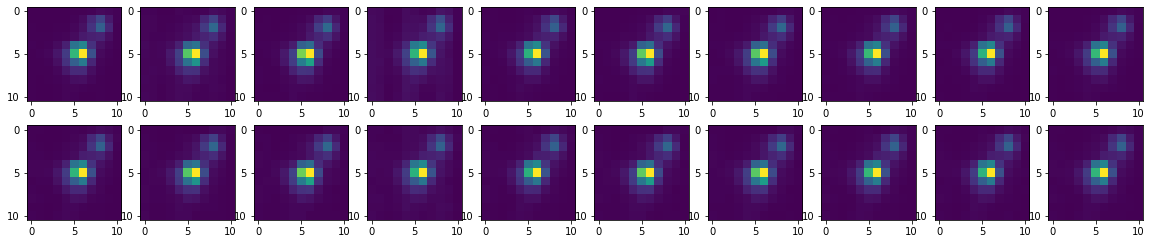

Epoch:  1
Total Loss: 1.863403558731079


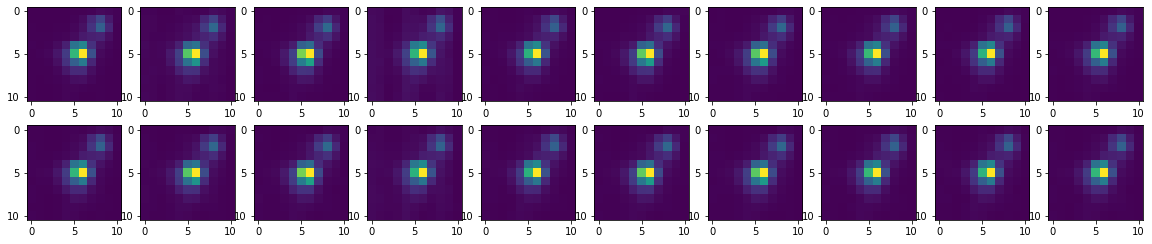

Epoch:  2
Total Loss: 2.1881215572357178


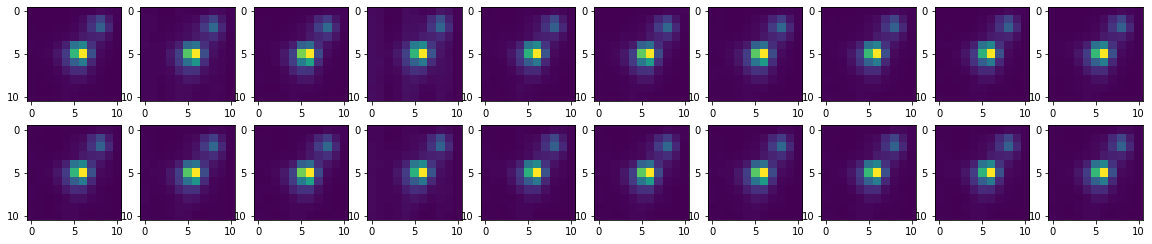

Epoch:  3
Total Loss: 1.3514199256896973


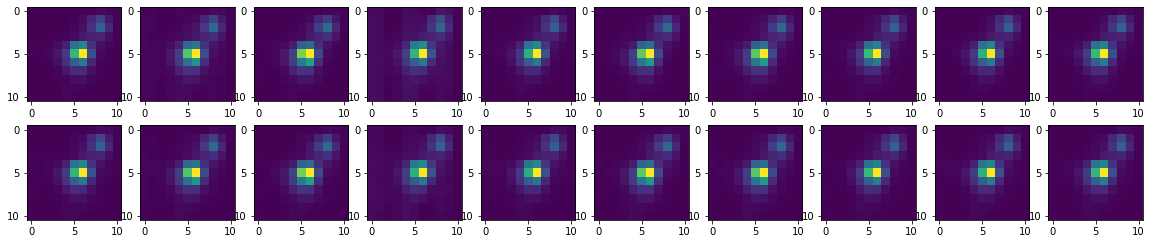

Epoch:  4
Total Loss: 1.3448455333709717


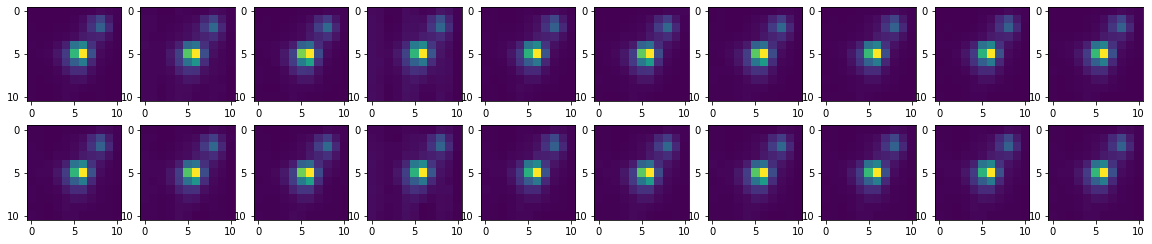

Epoch:  5
Total Loss: 0.9922677278518677


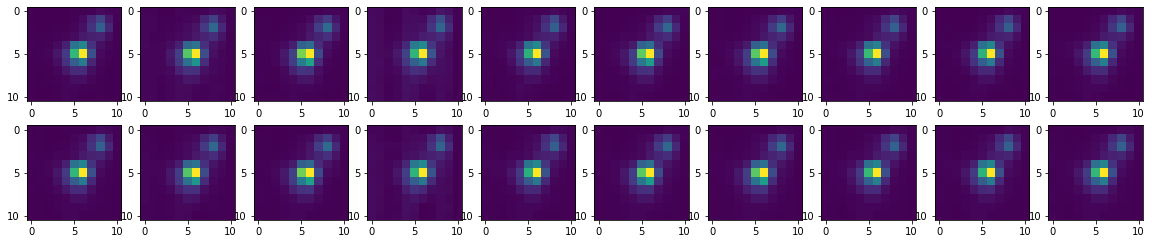

Epoch:  6
Total Loss: 0.6921271085739136


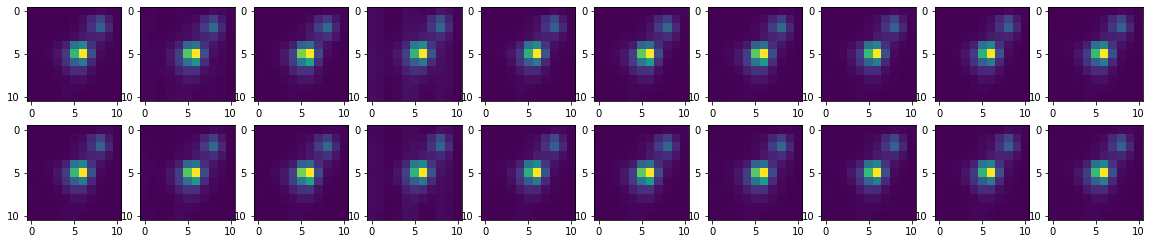

Epoch:  7
Total Loss: 0.7166827917098999


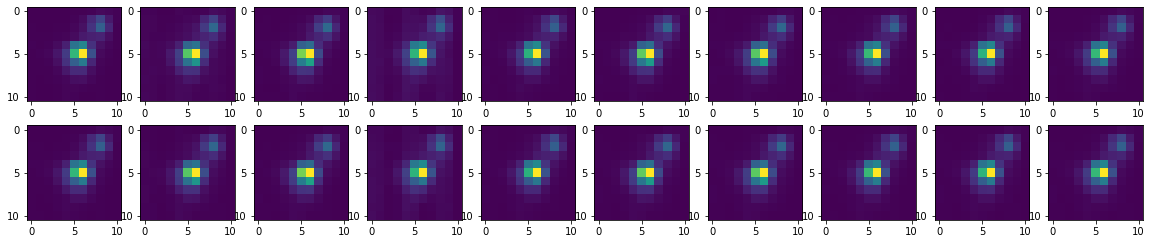

Epoch:  8
Total Loss: 1.581546425819397


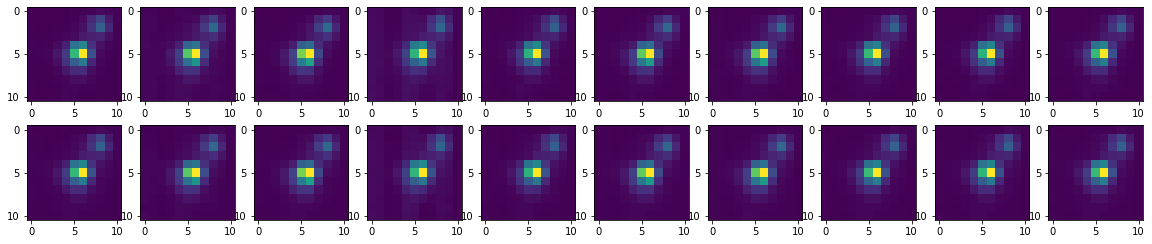

Epoch:  9
Total Loss: 0.8450993299484253


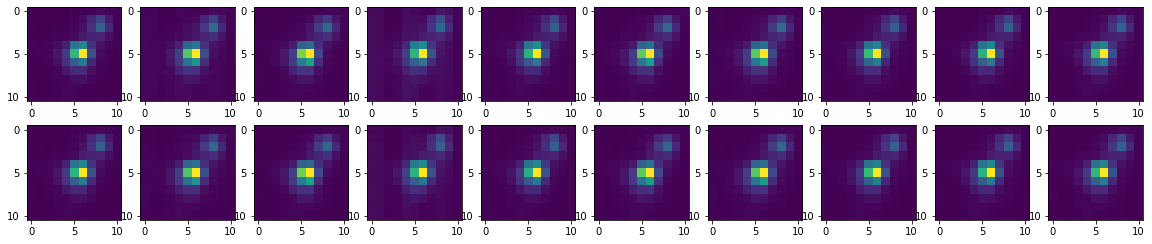

difference between test images 0.30737075
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 2.617915153503418


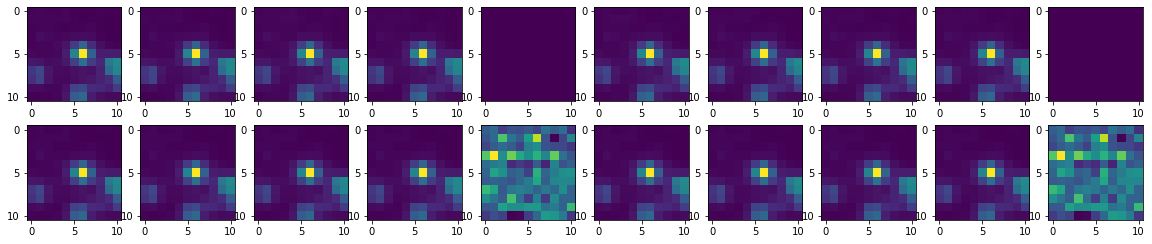

Epoch:  1
Total Loss: 4.877864837646484


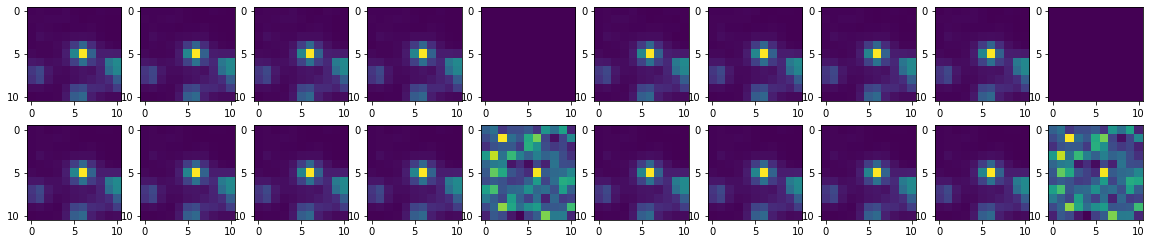

Epoch:  2
Total Loss: 2.419851779937744


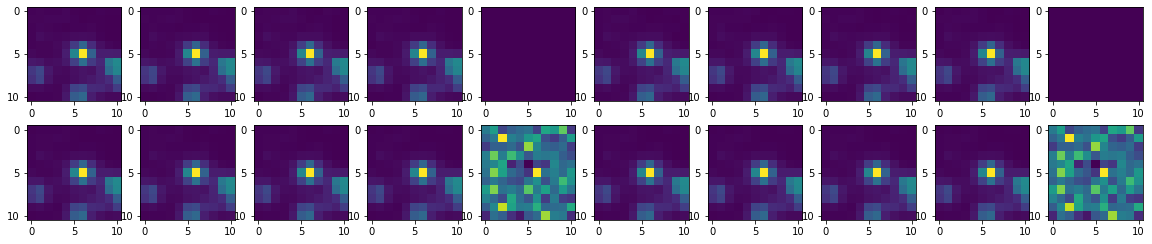

Epoch:  3
Total Loss: 1.6160013675689697


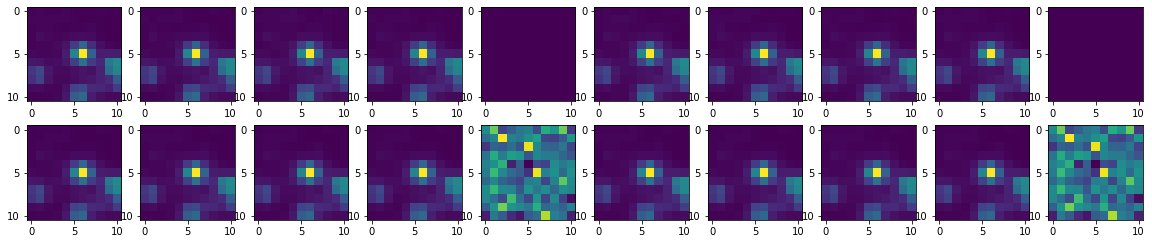

Epoch:  4
Total Loss: 2.2776012420654297


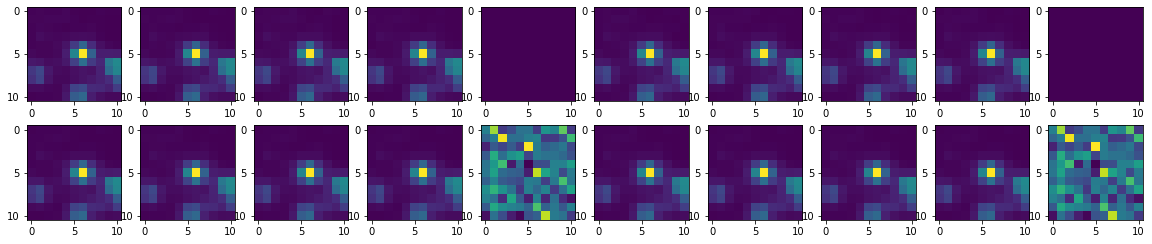

Epoch:  5
Total Loss: 2.2689030170440674


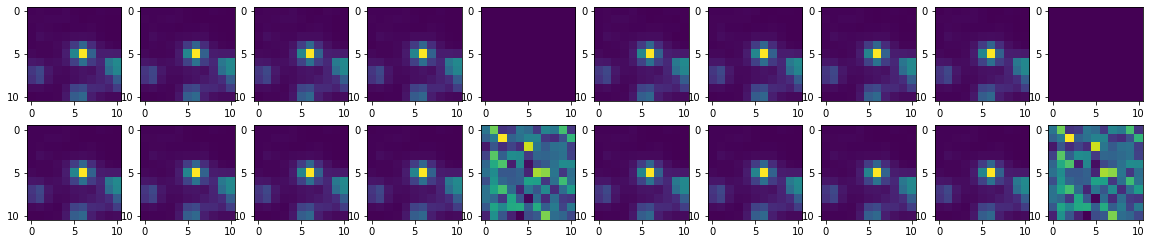

Epoch:  6
Total Loss: 2.168999671936035


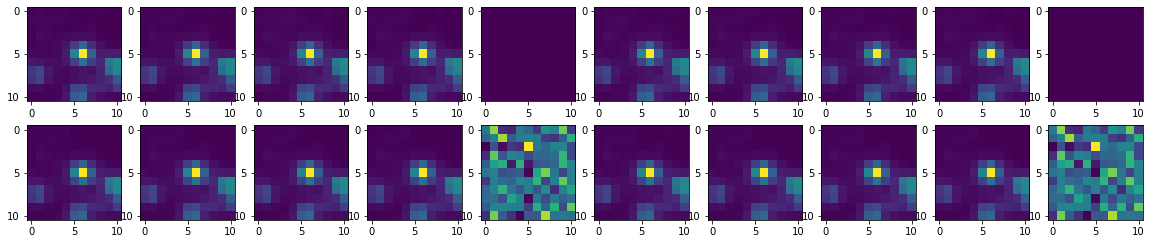

Epoch:  7
Total Loss: 1.8081122636795044


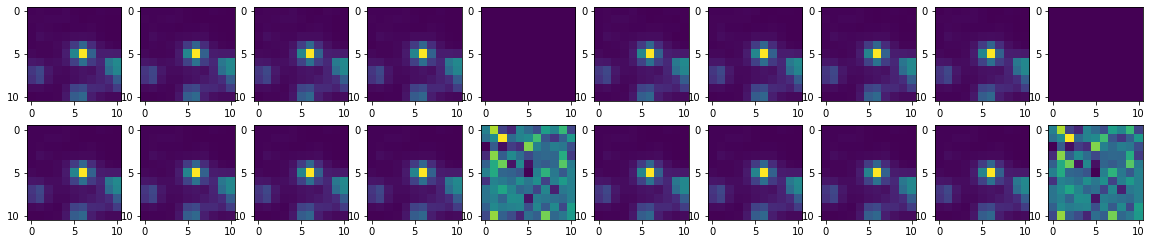

Epoch:  8
Total Loss: 1.6542937755584717


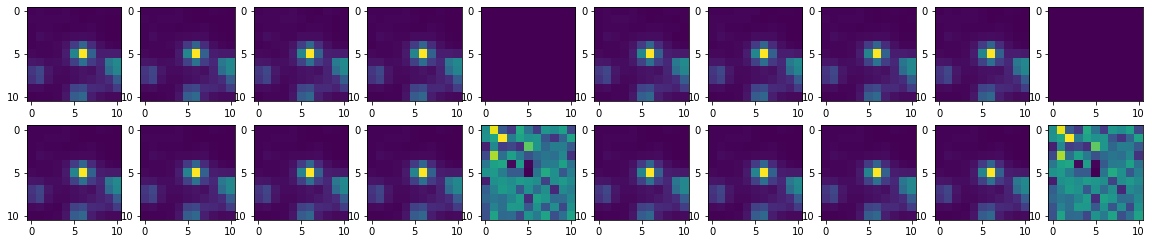

Epoch:  9
Total Loss: 1.9096572399139404


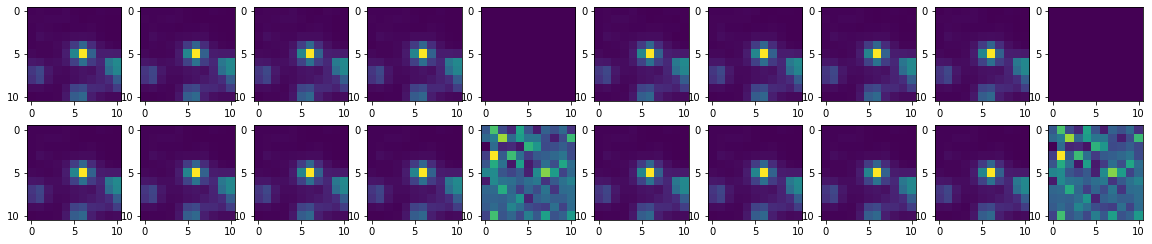

difference between test images 0.28332505
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 194.39816284179688


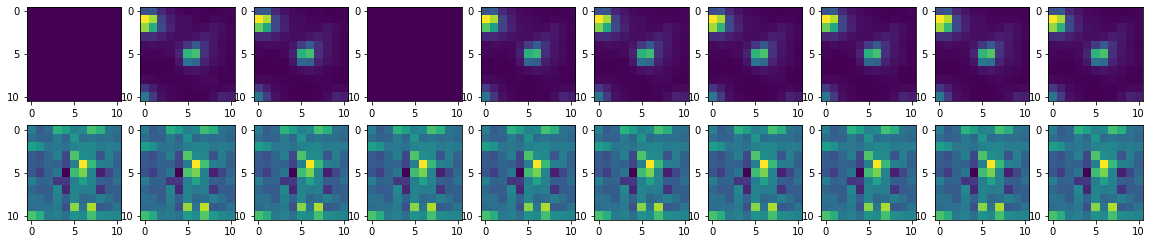

Epoch:  1
Total Loss: 1.8156274557113647


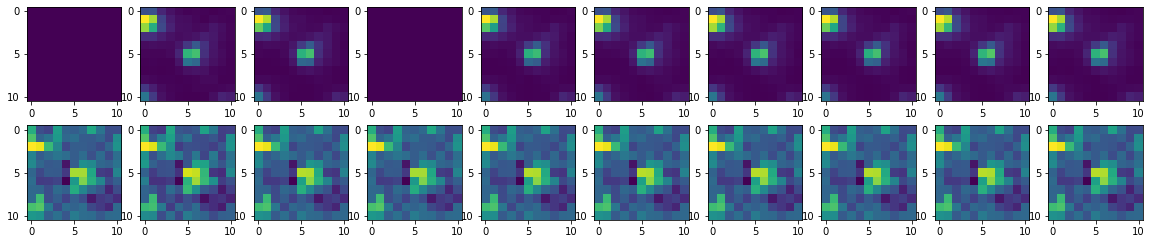

Epoch:  2
Total Loss: 1.2653459310531616


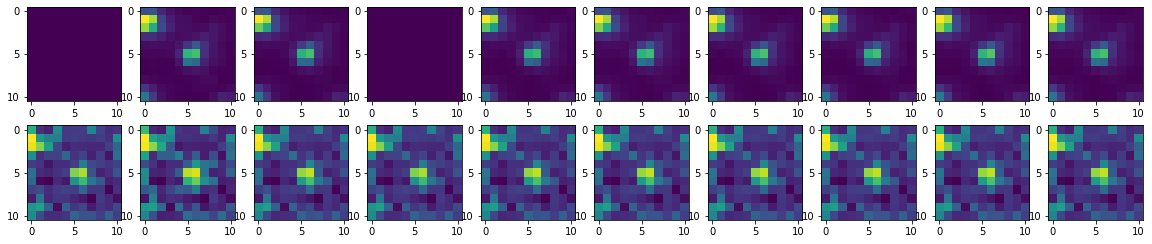

Epoch:  3
Total Loss: 32.900733947753906


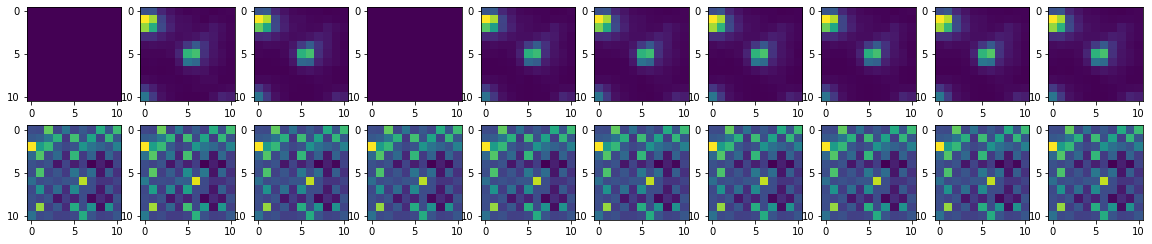

Epoch:  4
Total Loss: 1.446632742881775


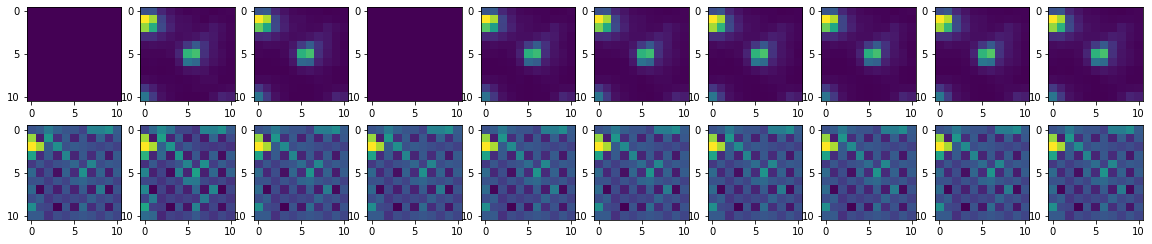

Epoch:  5
Total Loss: 2.2726805210113525


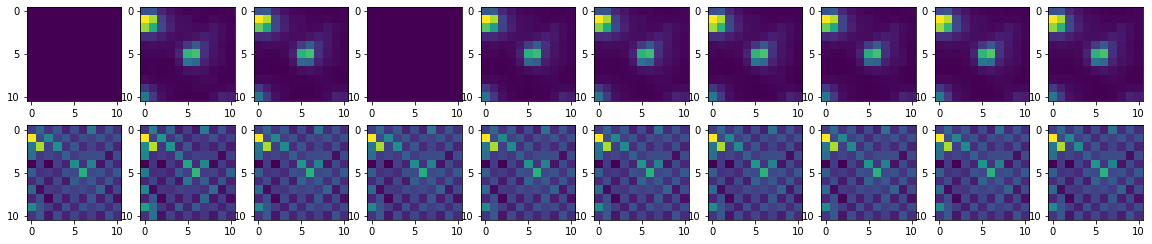

Epoch:  6
Total Loss: 9.781009674072266


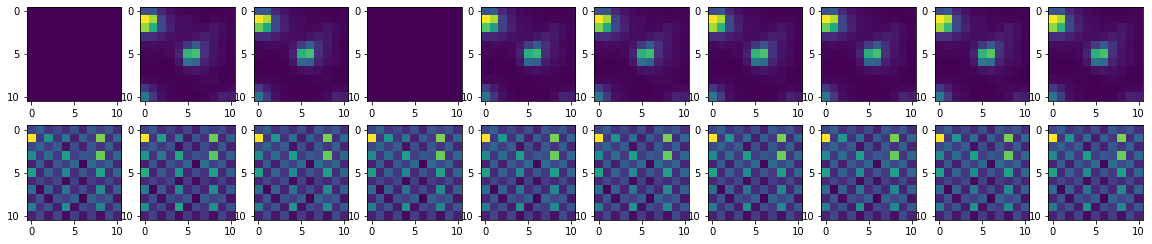

Epoch:  7
Total Loss: 9.50637435913086


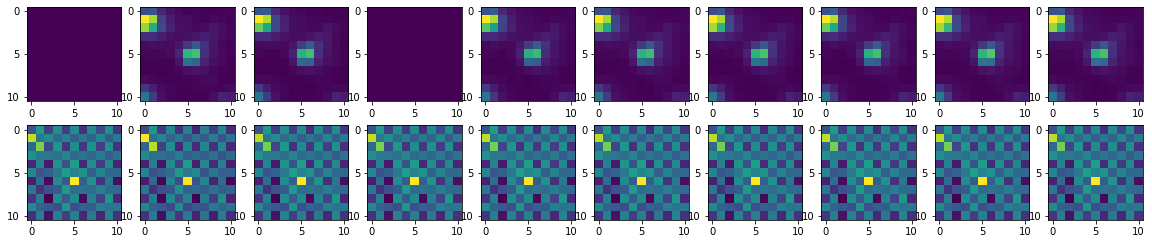

Epoch:  8
Total Loss: 11.33892822265625


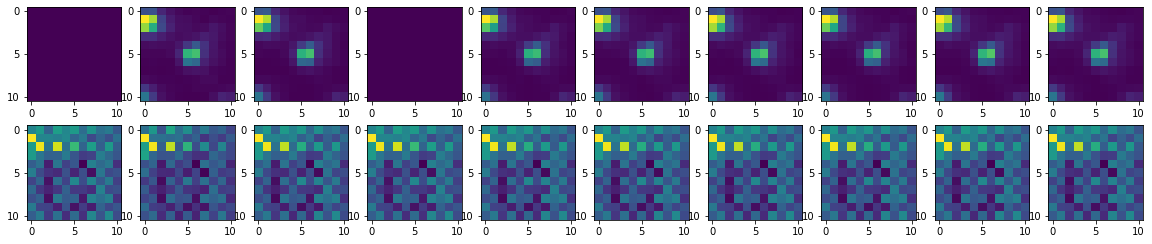

Epoch:  9
Total Loss: 13.778515815734863


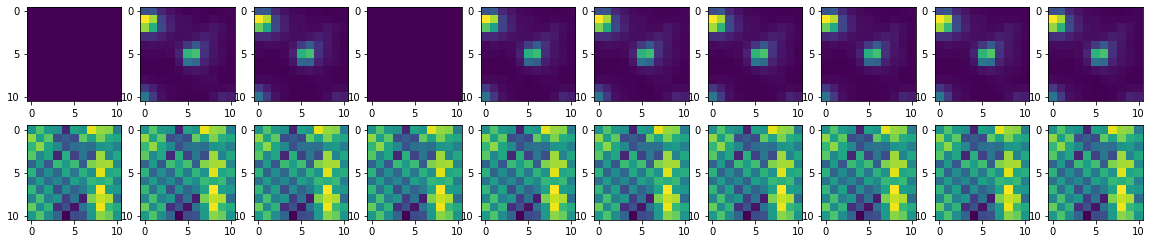

difference between test images 0.03643496
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 4.694011211395264


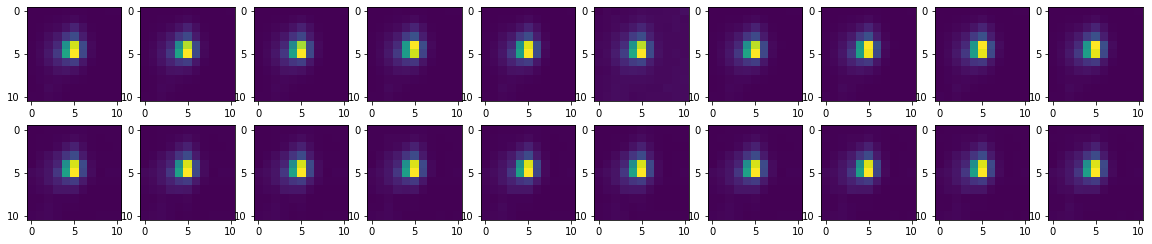

Epoch:  1
Total Loss: 51193.57421875


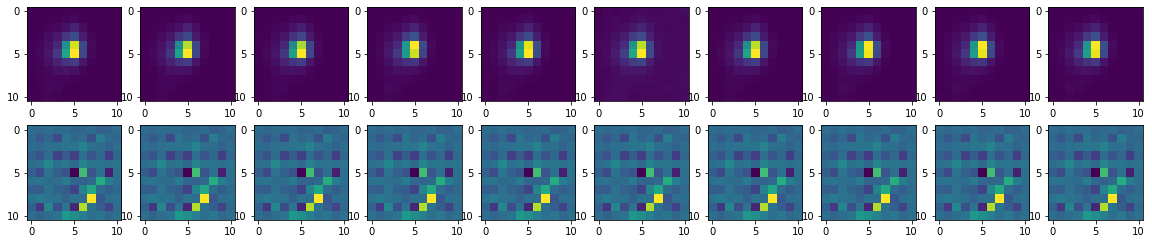

Epoch:  2
Total Loss: 505.89794921875


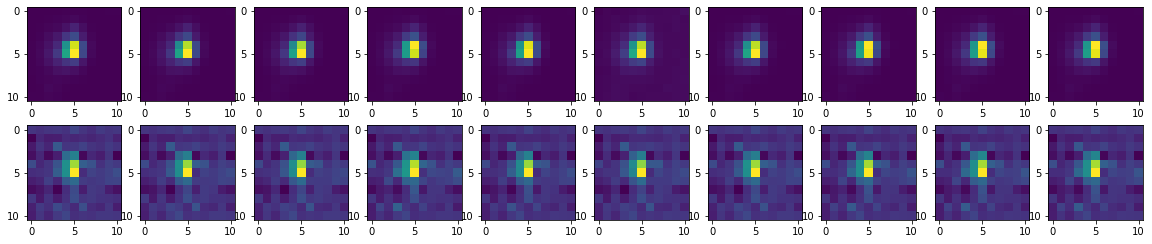

Epoch:  3
Total Loss: 263.120361328125


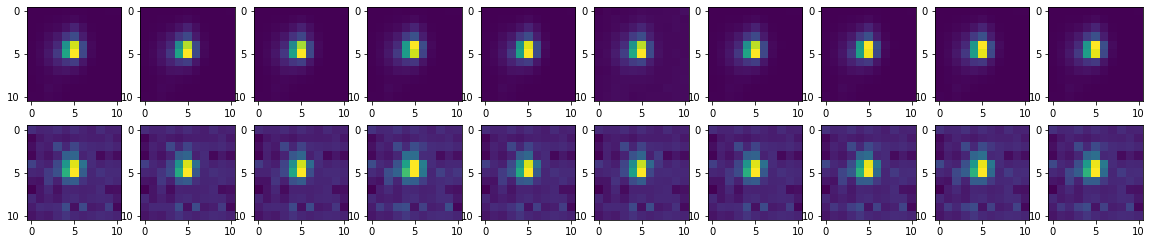

Epoch:  4
Total Loss: 236.36029052734375


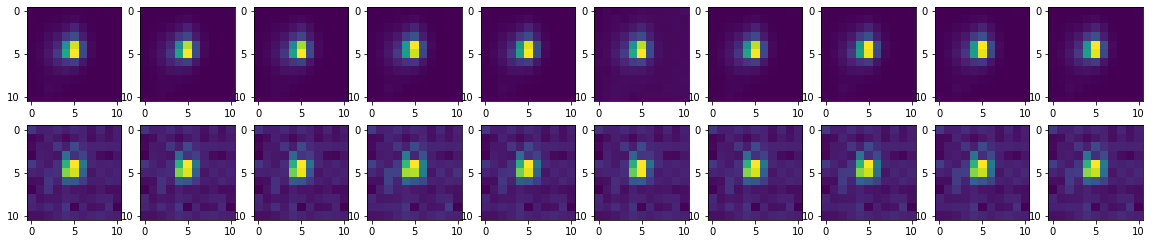

Epoch:  5
Total Loss: 216.62294006347656


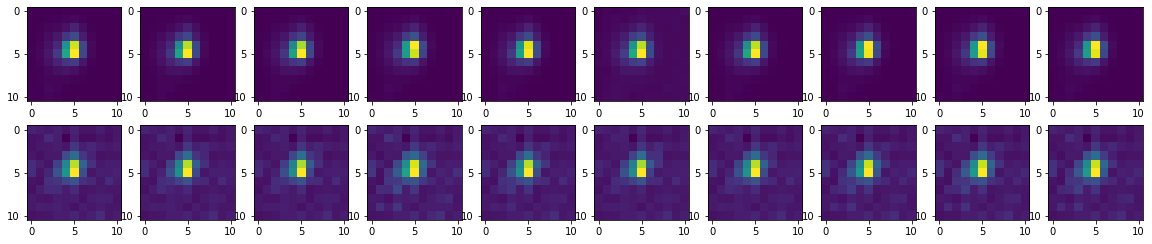

Epoch:  6
Total Loss: 131.49449157714844


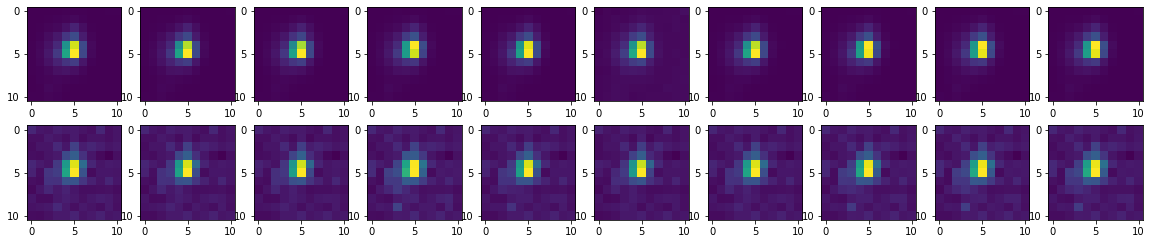

Epoch:  7
Total Loss: 100.42780303955078


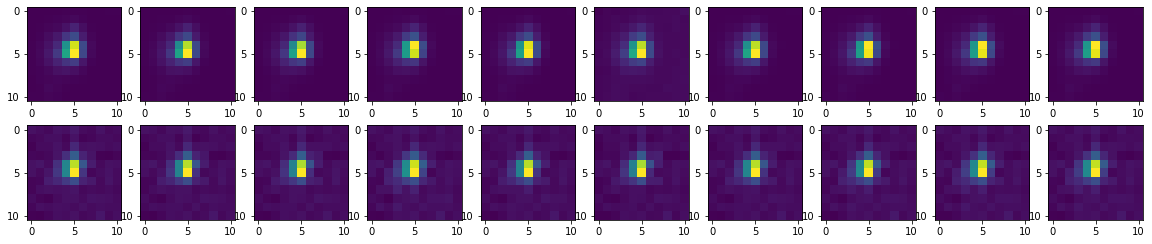

Epoch:  8
Total Loss: 98.04931640625


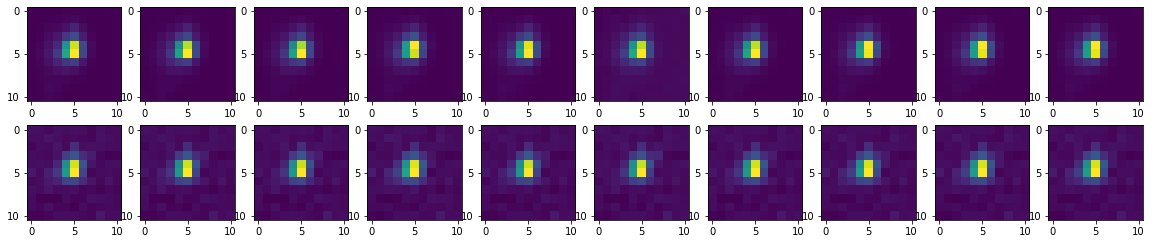

Epoch:  9
Total Loss: 75.56111907958984


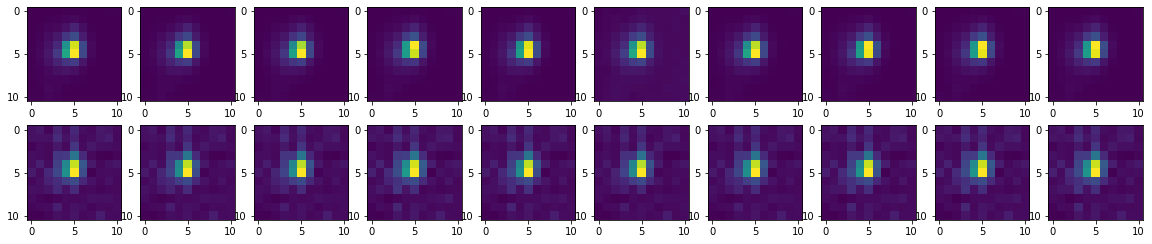

difference between test images 0.38413858
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 18.33159637451172


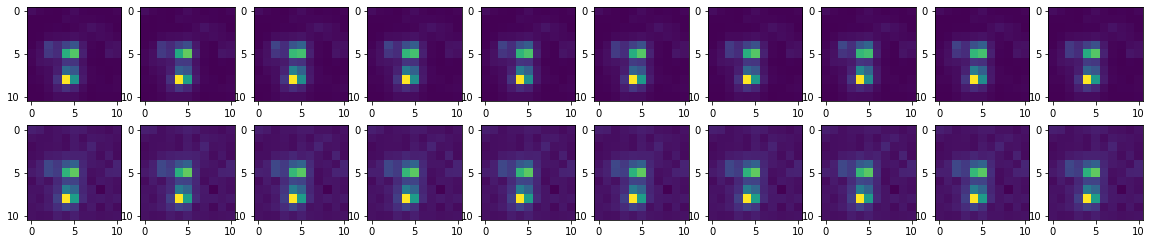

Epoch:  1
Total Loss: 11.78593921661377


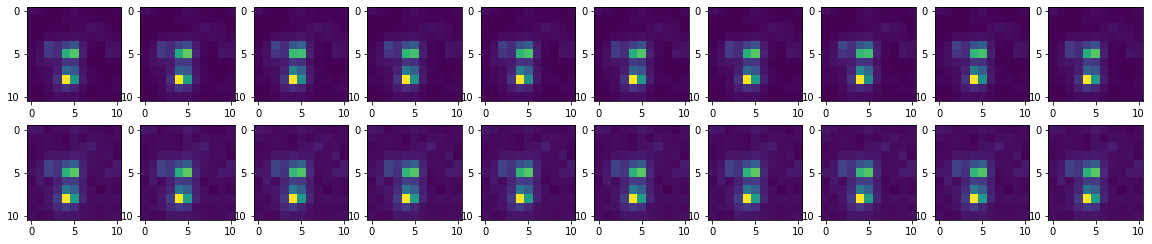

Epoch:  2
Total Loss: 8.589111328125


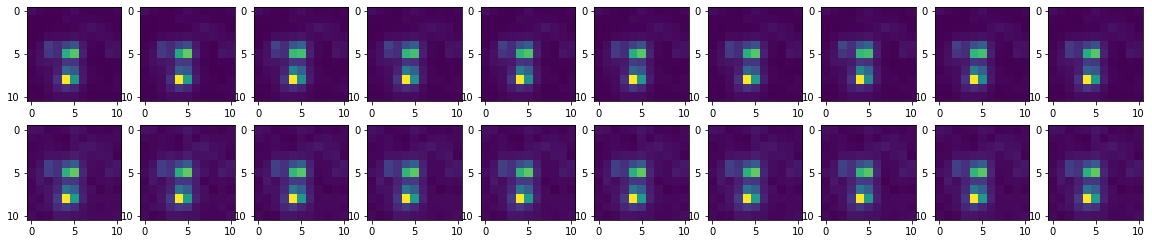

Epoch:  3
Total Loss: 6.43730354309082


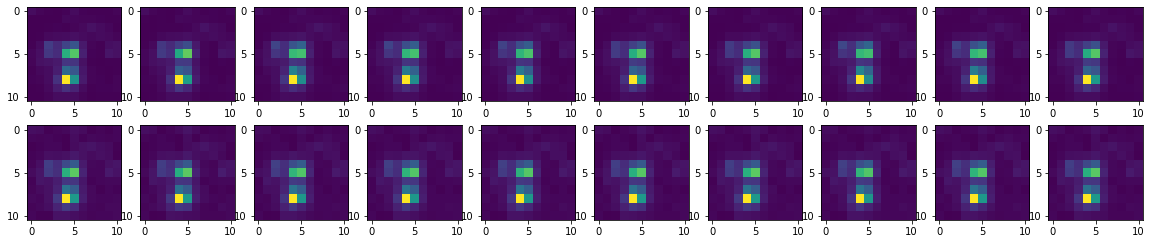

Epoch:  4
Total Loss: 5.28037166595459


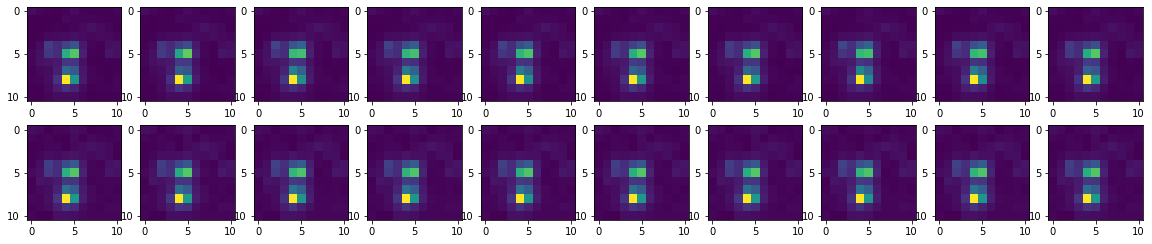

Epoch:  5
Total Loss: 4.491114139556885


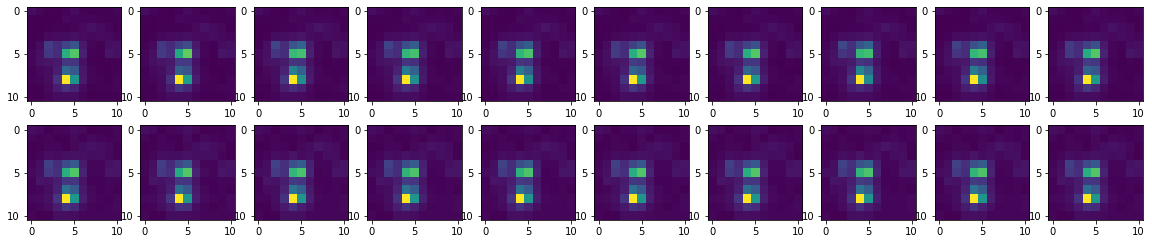

Epoch:  6
Total Loss: 3.870751142501831


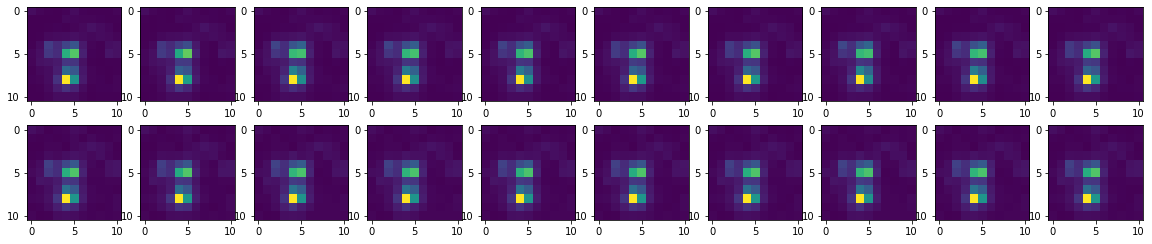

Epoch:  7
Total Loss: 3.643246650695801


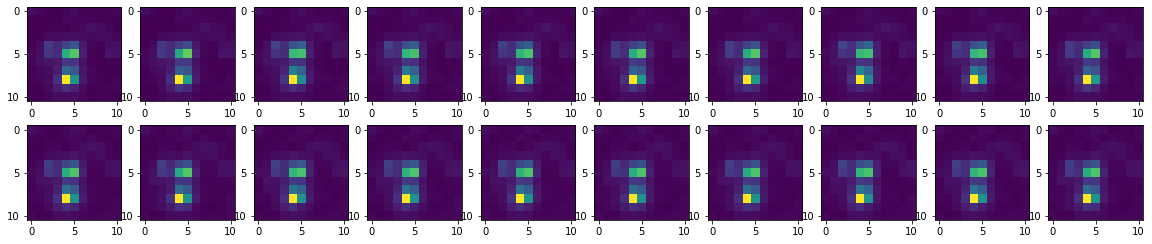

Epoch:  8
Total Loss: 5.9338059425354


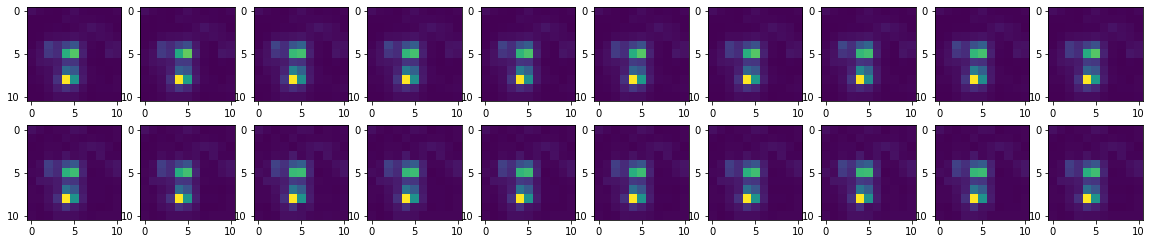

Epoch:  9
Total Loss: 4.92018461227417


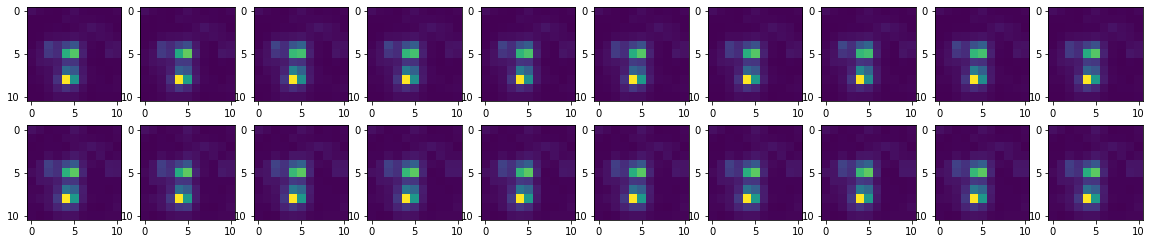

difference between test images 0.21583427
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 32.76311492919922


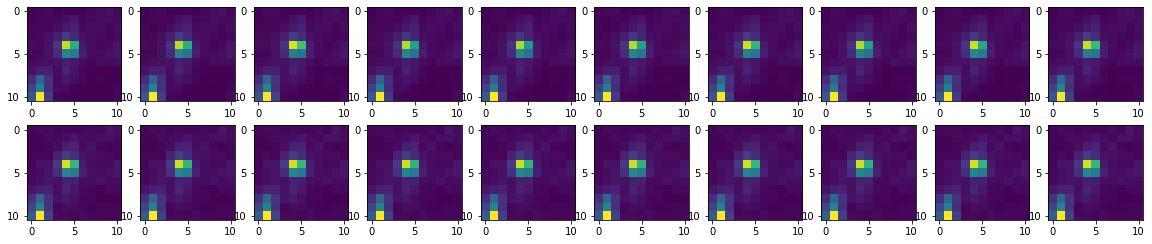

Epoch:  1
Total Loss: 11.306219100952148


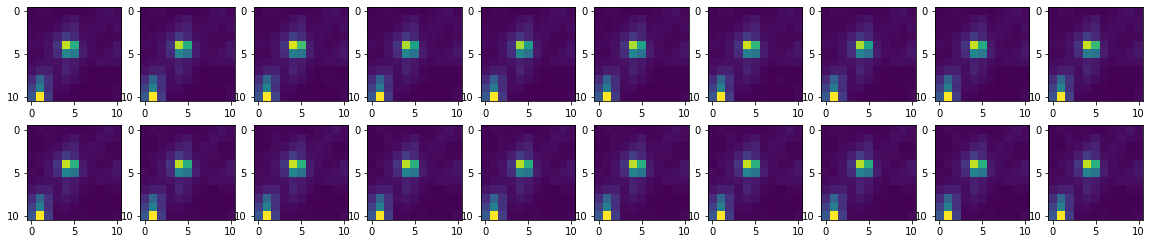

Epoch:  2
Total Loss: 8.008384704589844


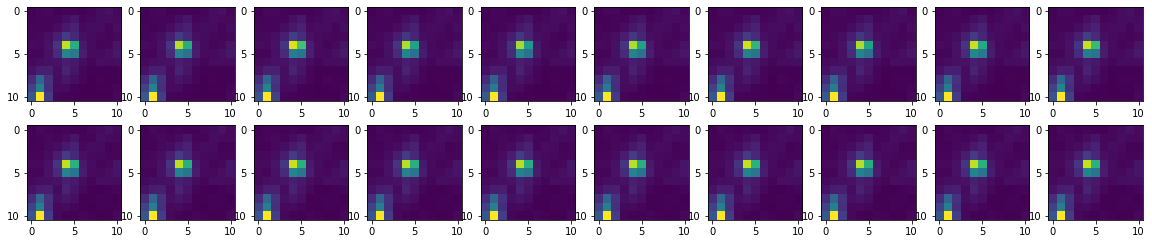

Epoch:  3
Total Loss: 6.44821834564209


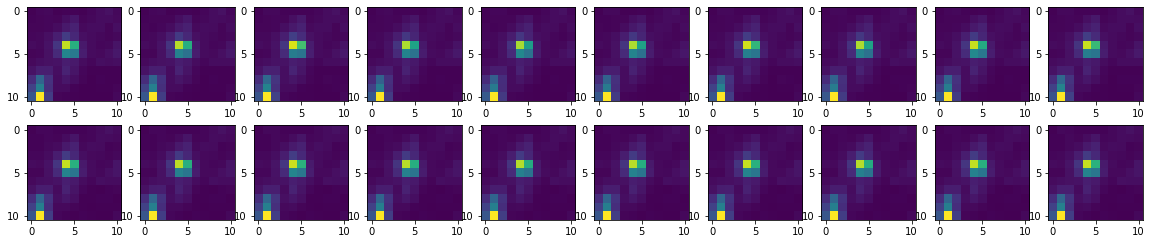

Epoch:  4
Total Loss: 5.485841274261475


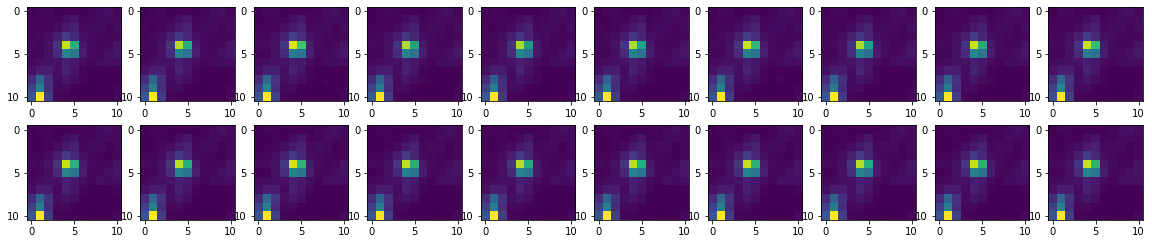

Epoch:  5
Total Loss: 5.255816459655762


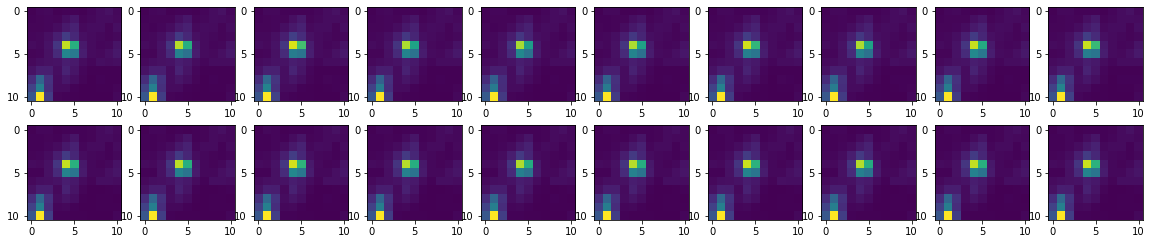

Epoch:  6
Total Loss: 8.934514045715332


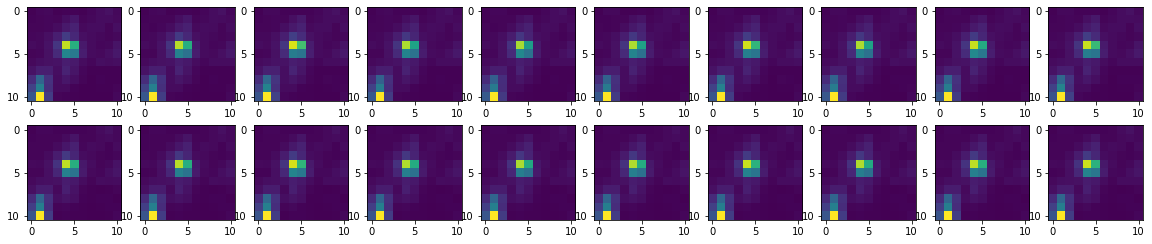

Epoch:  7
Total Loss: 9.691730499267578


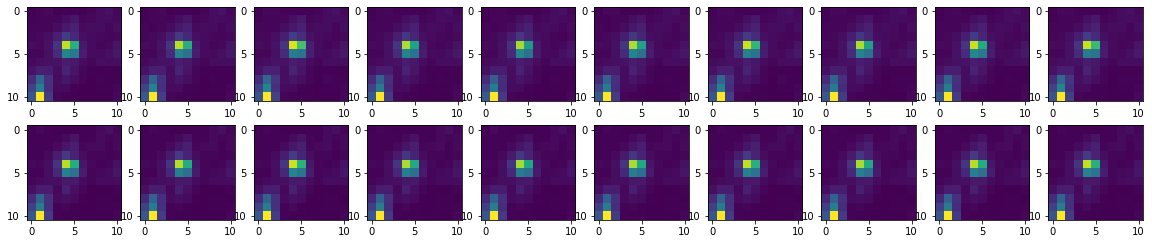

Epoch:  8
Total Loss: 3.8301644325256348


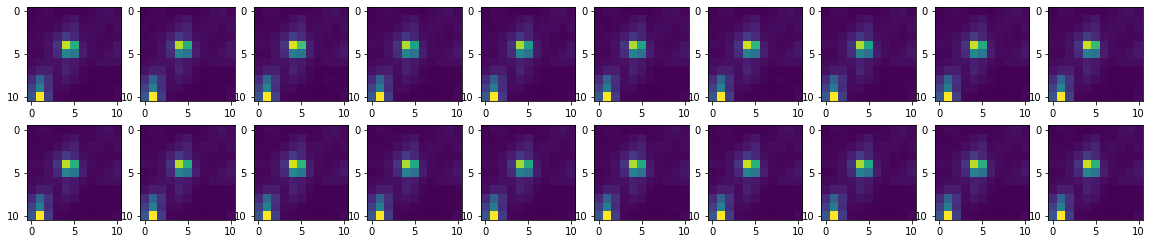

Epoch:  9
Total Loss: 13.095542907714844


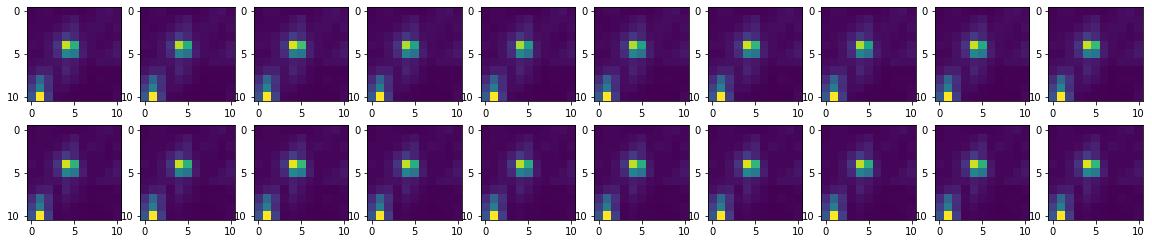

difference between test images 0.38793224
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 6.209604263305664


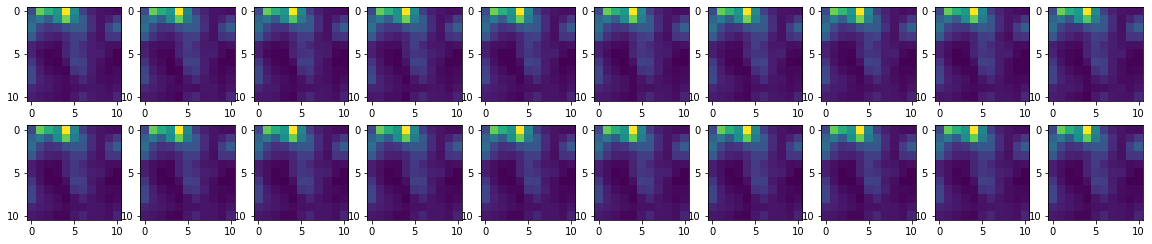

Epoch:  1
Total Loss: 4.031235694885254


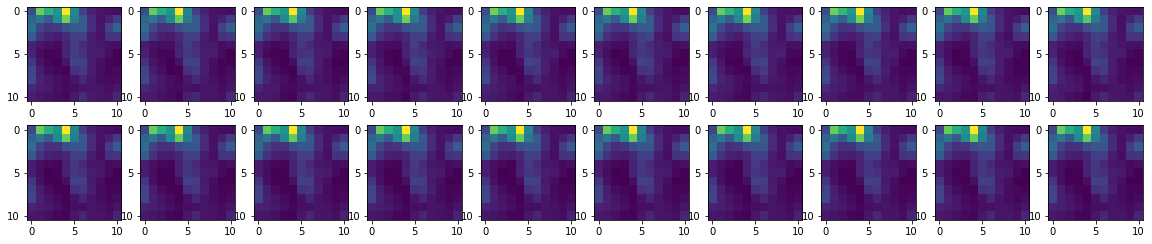

Epoch:  2
Total Loss: 3.065971851348877


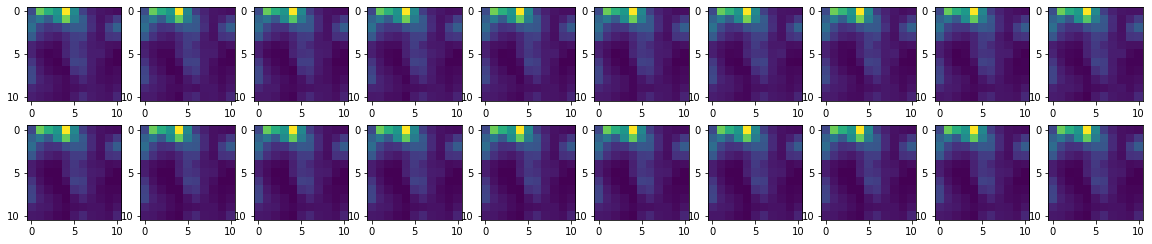

Epoch:  3
Total Loss: 3.4437339305877686


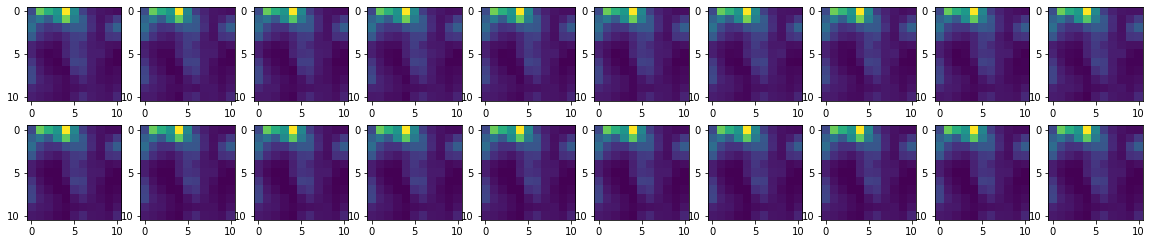

Epoch:  4
Total Loss: 2.9499402046203613


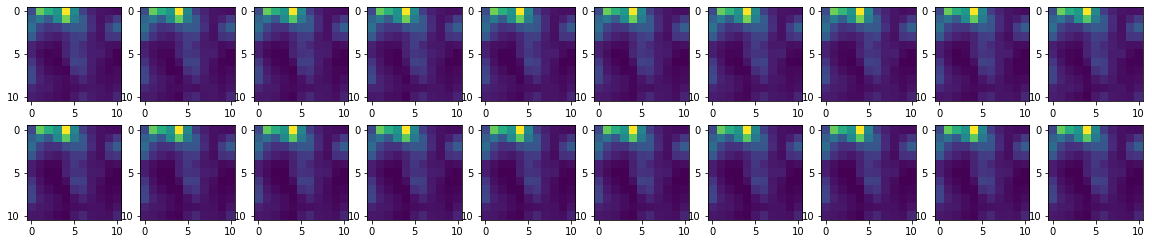

Epoch:  5
Total Loss: 3.5568113327026367


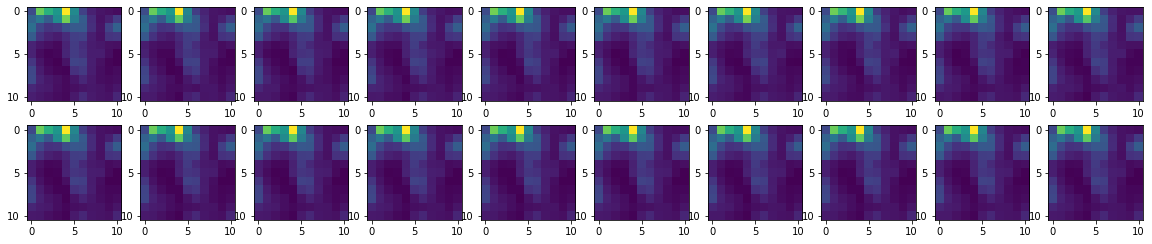

Epoch:  6
Total Loss: 3.127042055130005


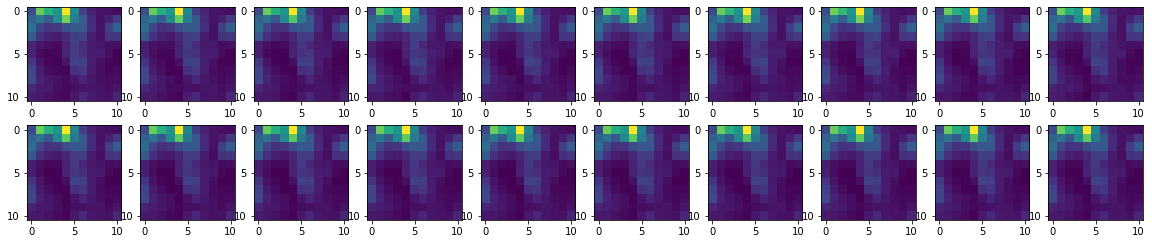

Epoch:  7
Total Loss: 2.7363710403442383


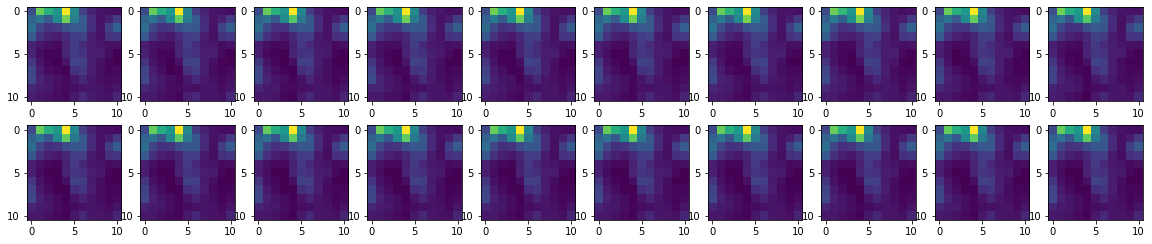

Epoch:  8
Total Loss: 5.0091328620910645


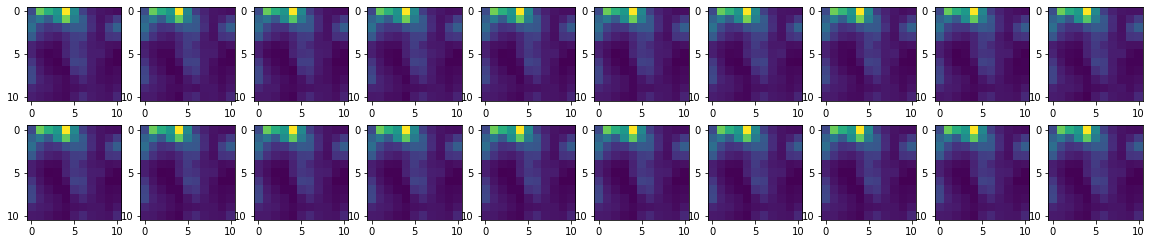

Epoch:  9
Total Loss: 3.099534511566162


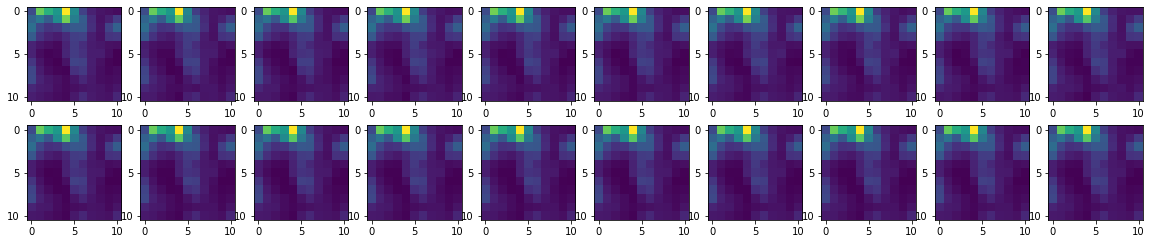

difference between test images 0.12834077
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 1.6440119743347168


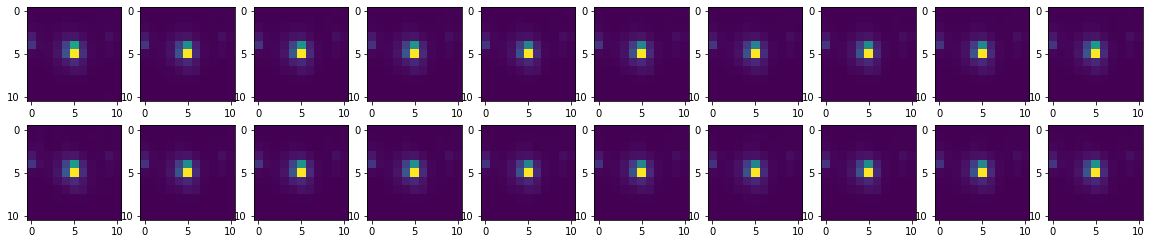

Epoch:  1
Total Loss: 1.4297664165496826


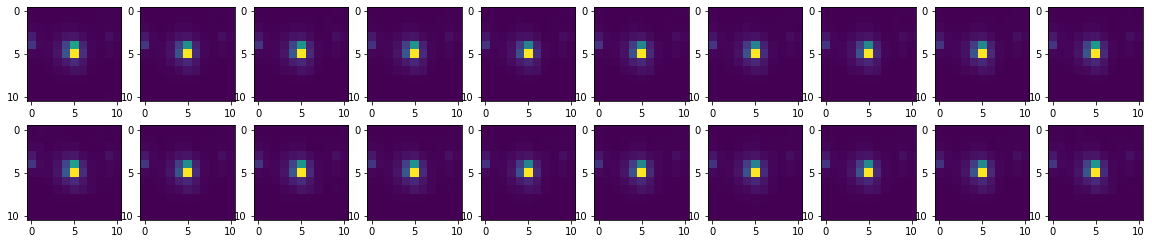

Epoch:  2
Total Loss: 1.1340548992156982


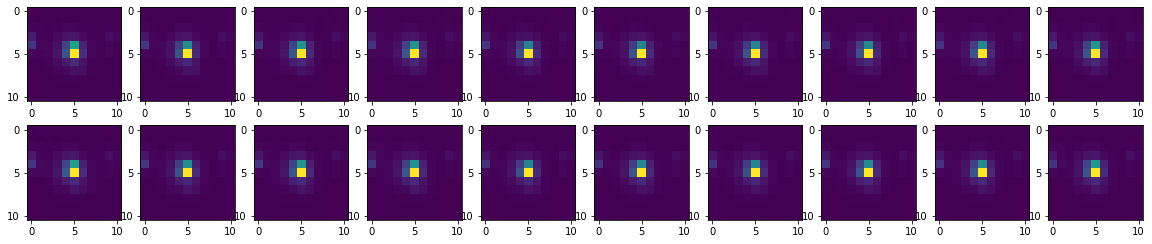

Epoch:  3
Total Loss: 0.8520483374595642


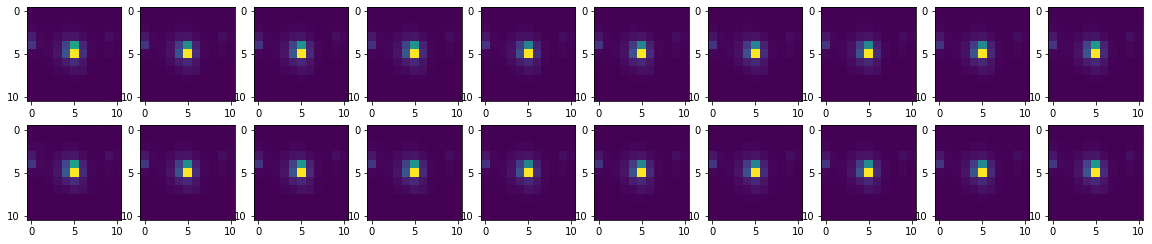

Epoch:  4
Total Loss: 0.7189755439758301


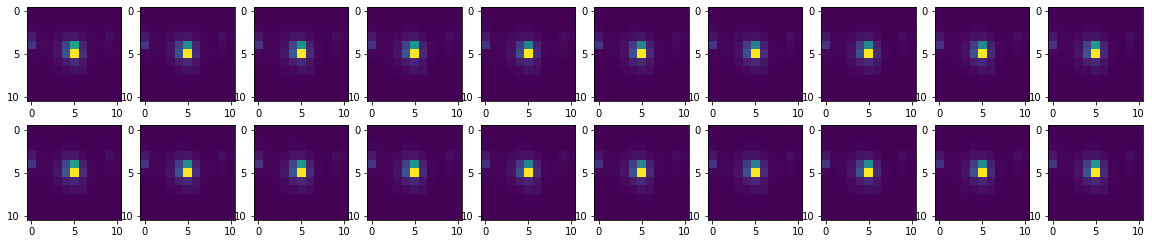

Epoch:  5
Total Loss: 0.5633659958839417


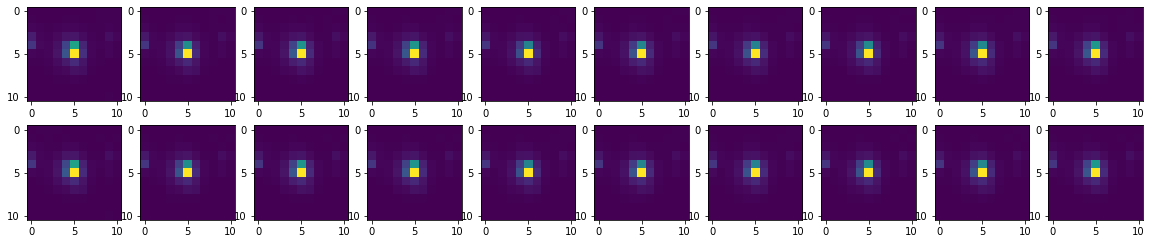

Epoch:  6
Total Loss: 0.708340048789978


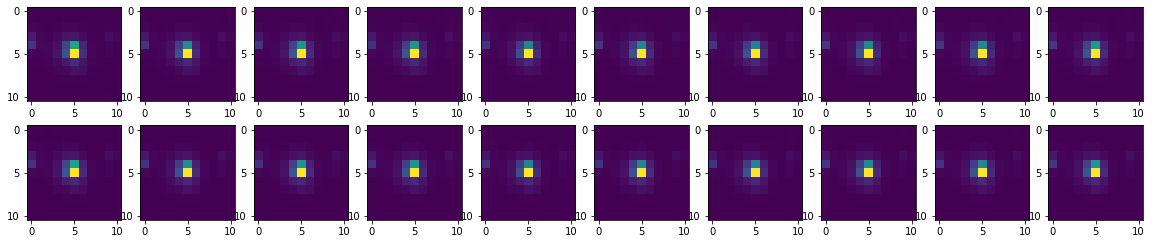

Epoch:  7
Total Loss: 0.6201204061508179


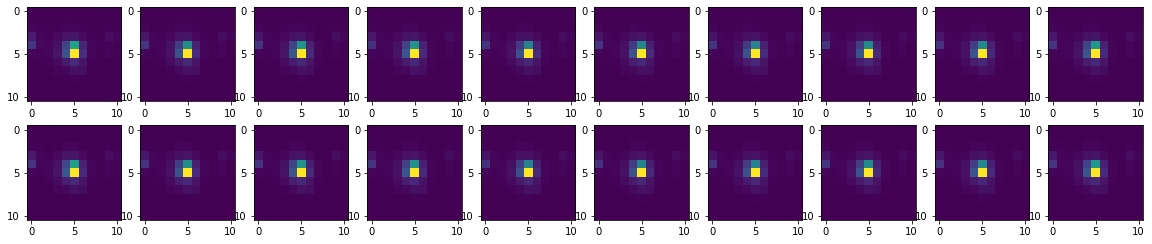

Epoch:  8
Total Loss: 0.7911698818206787


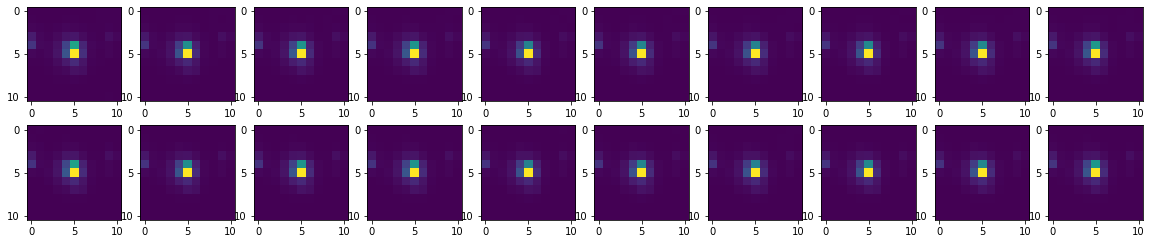

Epoch:  9
Total Loss: 0.5198848247528076


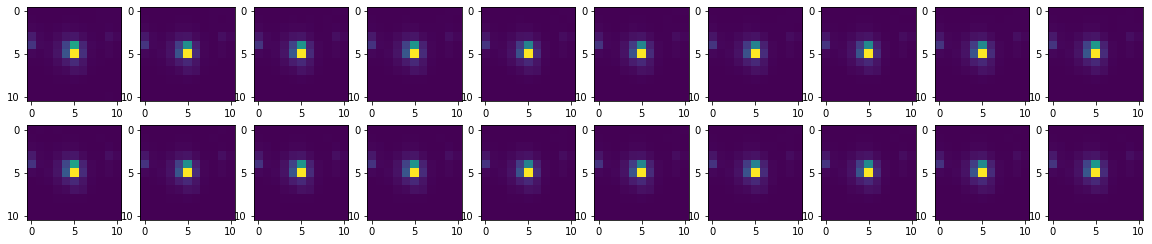

difference between test images 0.33628097
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 21.854101181030273


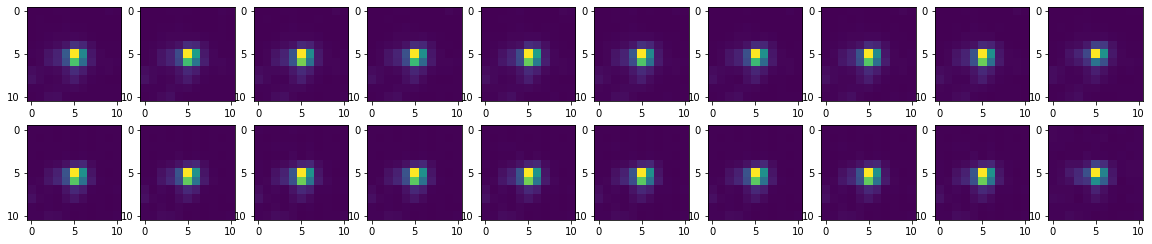

Epoch:  1
Total Loss: 2.7203316688537598


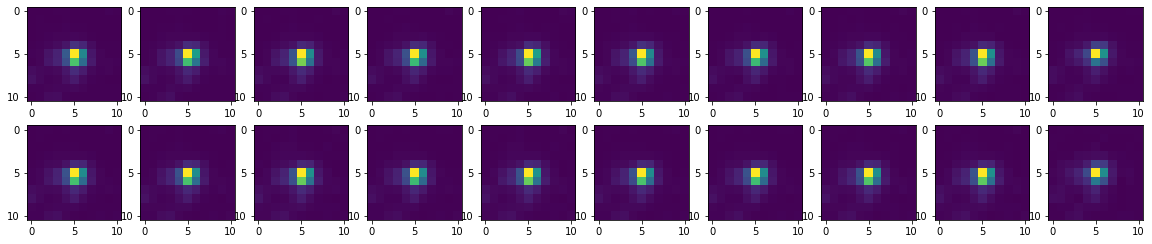

Epoch:  2
Total Loss: 2.4279661178588867


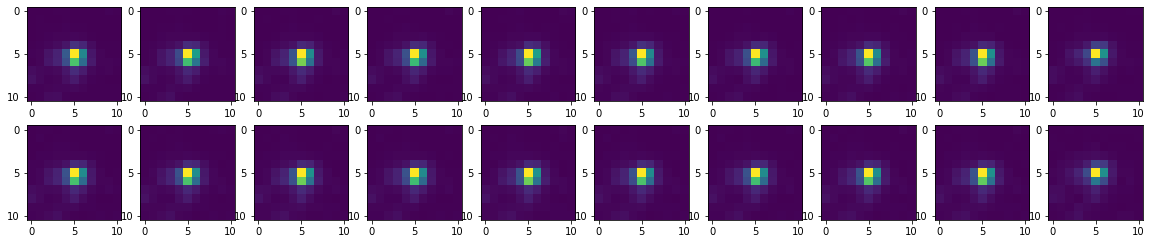

Epoch:  3
Total Loss: 1.9743797779083252


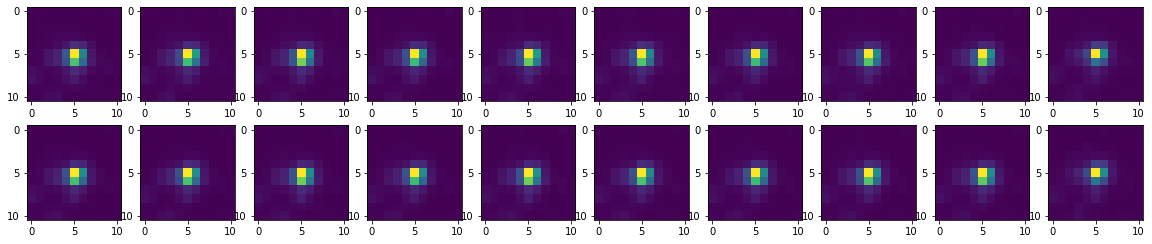

Epoch:  4
Total Loss: 7.534049987792969


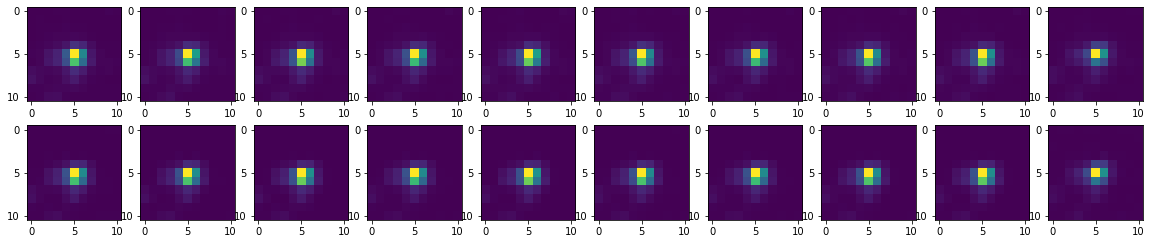

Epoch:  5
Total Loss: 11.016534805297852


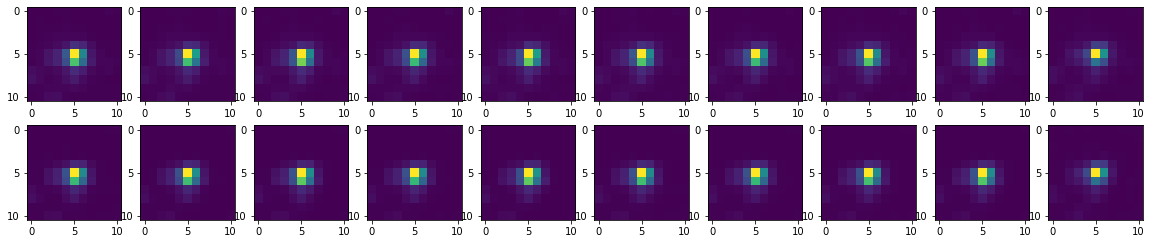

Epoch:  6
Total Loss: 1.2497435808181763


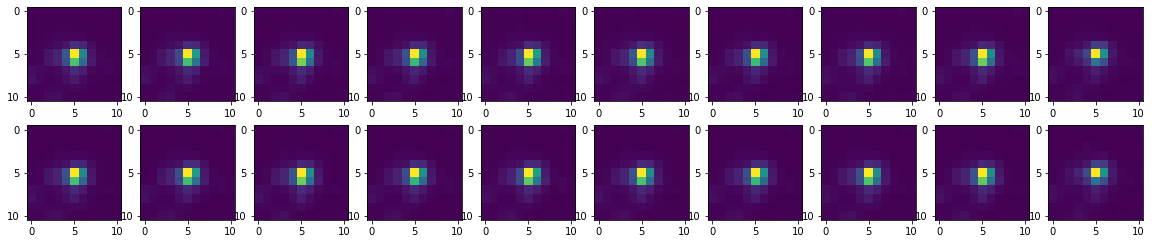

Epoch:  7
Total Loss: 11.194380760192871


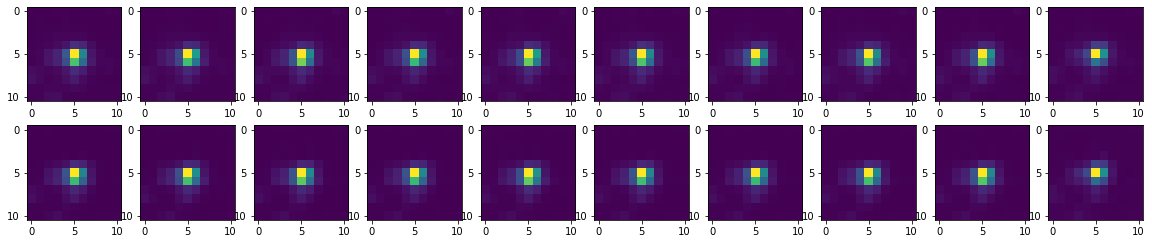

Epoch:  8
Total Loss: 7.330079555511475


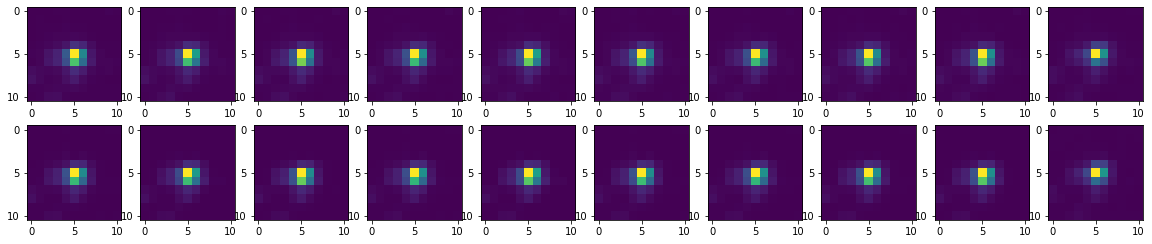

Epoch:  9
Total Loss: 0.6804507374763489


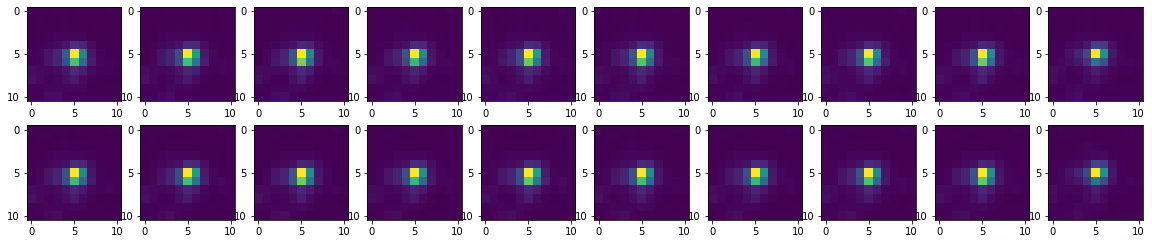

difference between test images 0.17552385
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 2.218214988708496


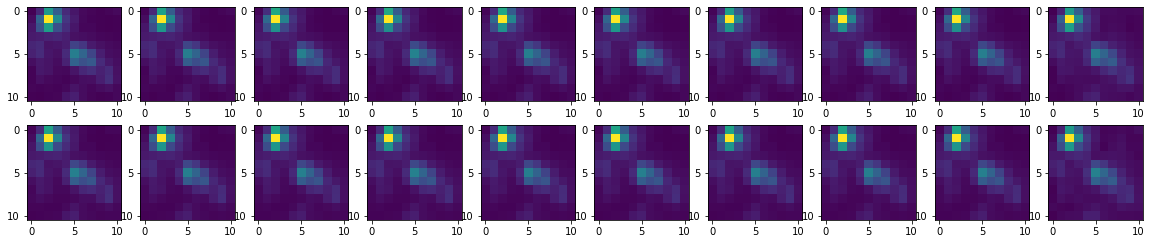

Epoch:  1
Total Loss: 1.5186347961425781


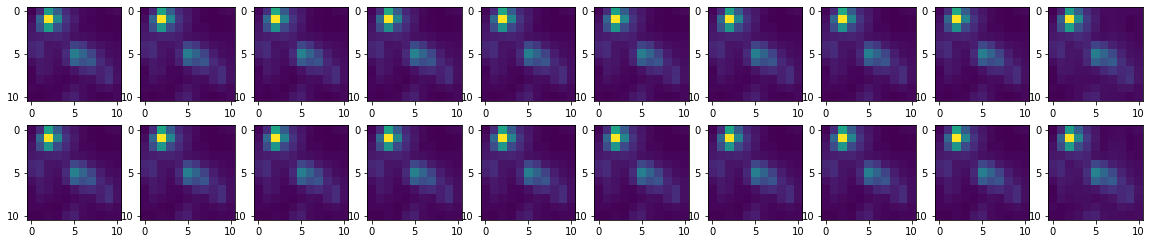

Epoch:  2
Total Loss: 1.2849271297454834


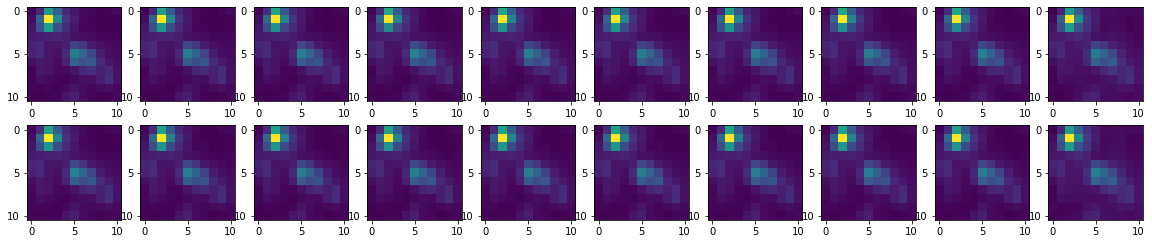

Epoch:  3
Total Loss: 1.047590732574463


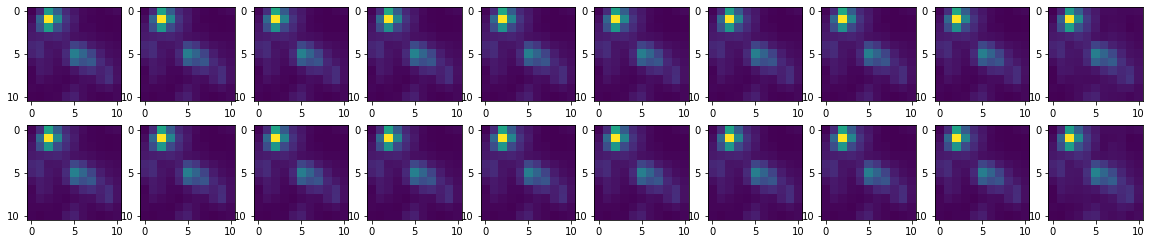

Epoch:  4
Total Loss: 1.0102258920669556


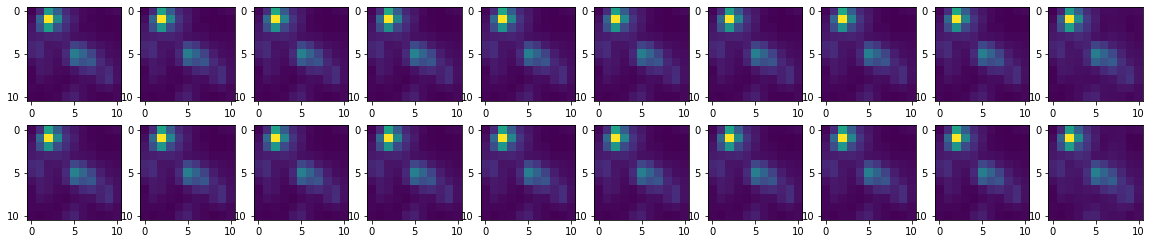

Epoch:  5
Total Loss: 0.9063888192176819


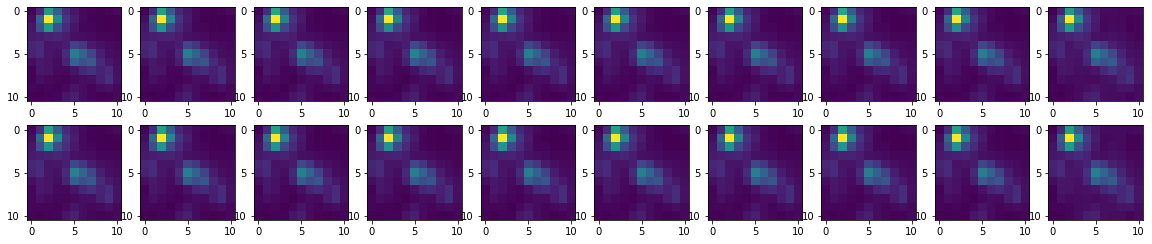

Epoch:  6
Total Loss: 0.8862401247024536


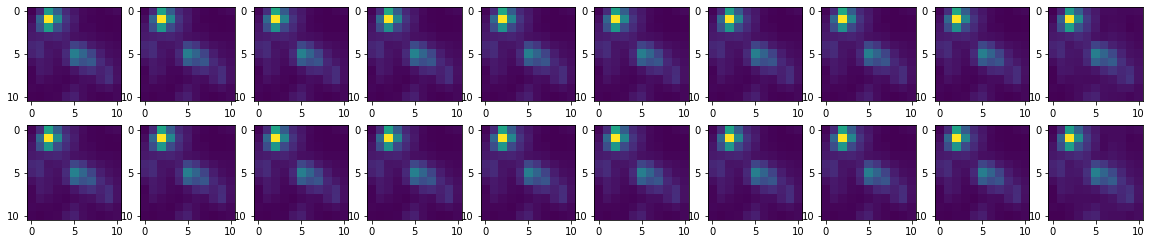

Epoch:  7
Total Loss: 1.4517300128936768


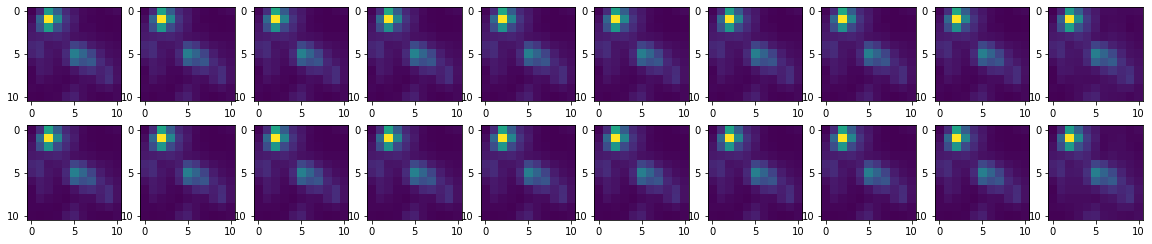

Epoch:  8
Total Loss: 0.8755083084106445


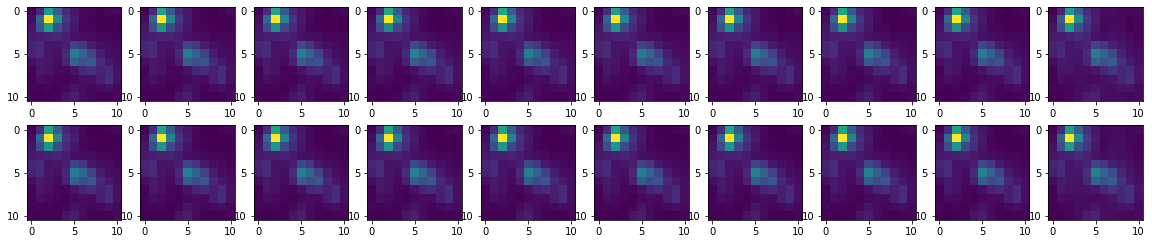

Epoch:  9
Total Loss: 0.7117068767547607


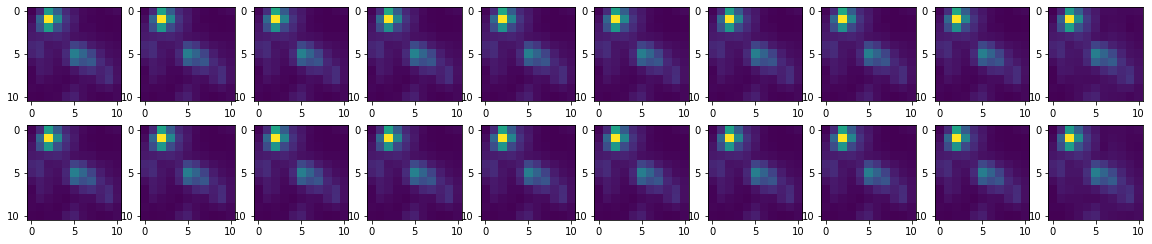

difference between test images 0.045363504
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 4.750009536743164


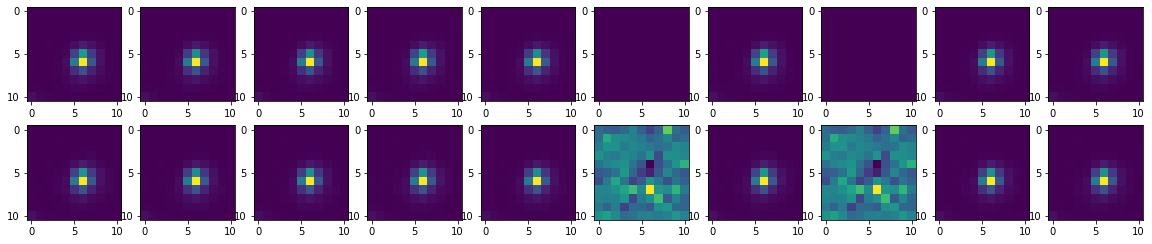

Epoch:  1
Total Loss: 4.427402496337891


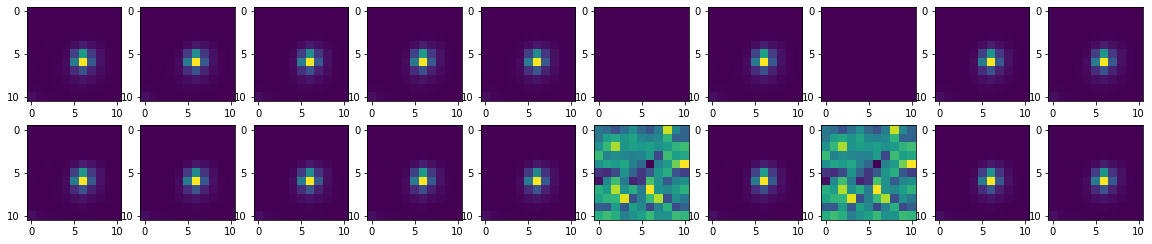

Epoch:  2
Total Loss: 8.951692581176758


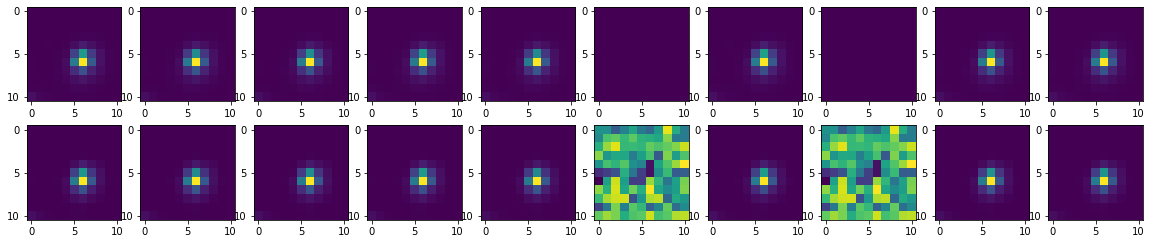

Epoch:  3
Total Loss: 52.78688430786133


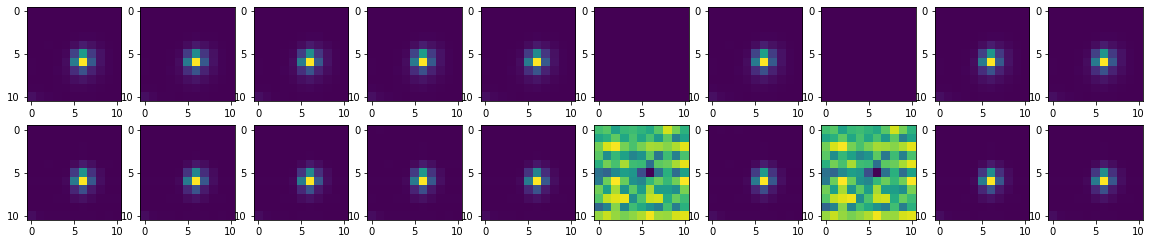

Epoch:  4
Total Loss: 4.410298824310303


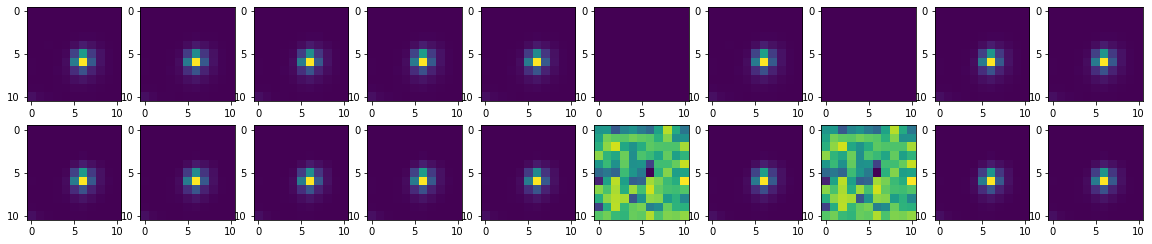

Epoch:  5
Total Loss: 2.251817226409912


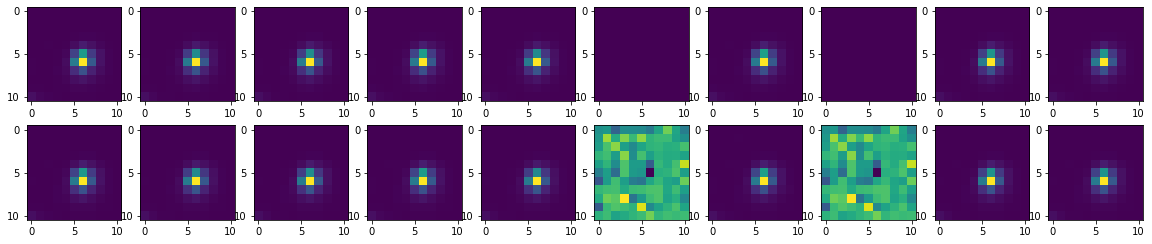

Epoch:  6
Total Loss: 1.471975326538086


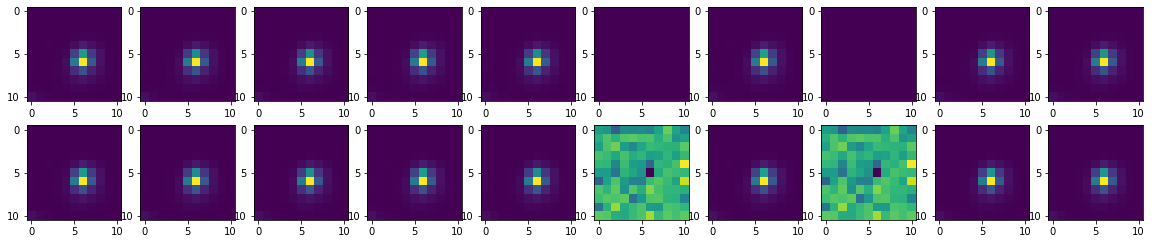

Epoch:  7
Total Loss: 2.099543809890747


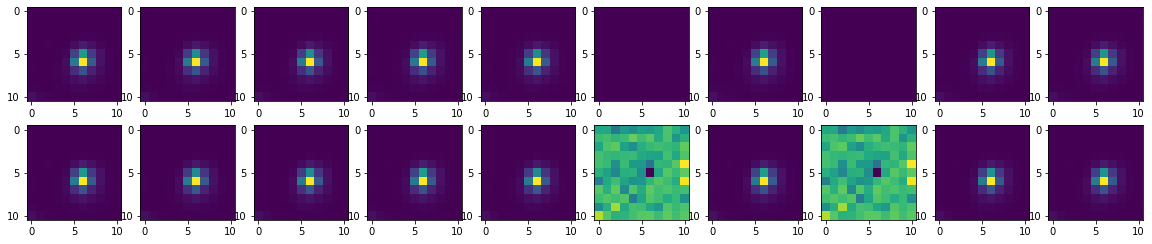

Epoch:  8
Total Loss: 1.2866430282592773


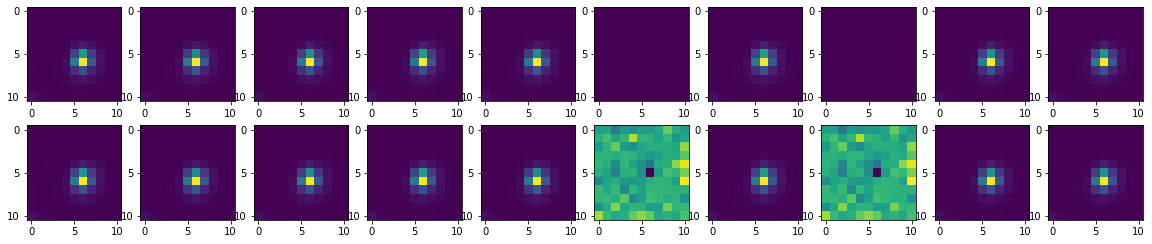

Epoch:  9
Total Loss: 2.257307291030884


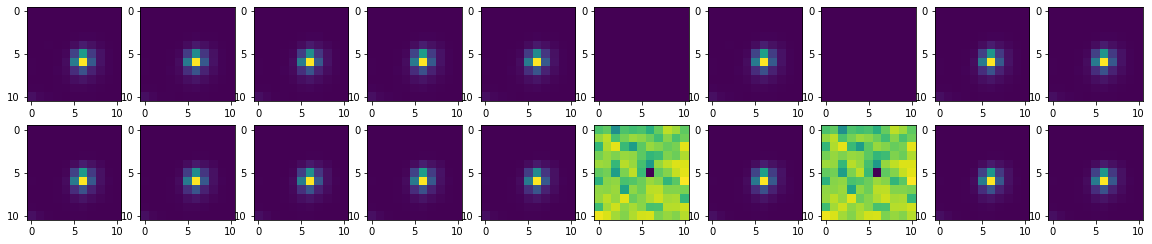

difference between test images 0.5040306
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 4865.80810546875


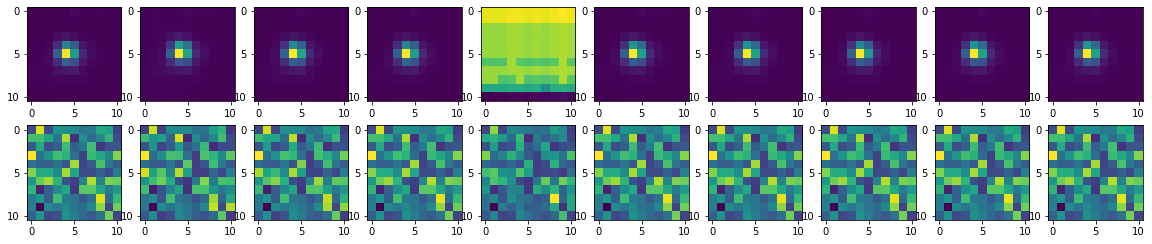

Epoch:  1
Total Loss: 2881.86865234375


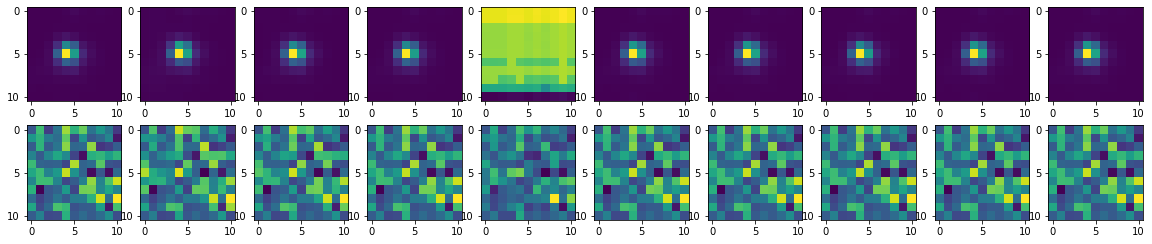

Epoch:  2
Total Loss: 1925.9385986328125


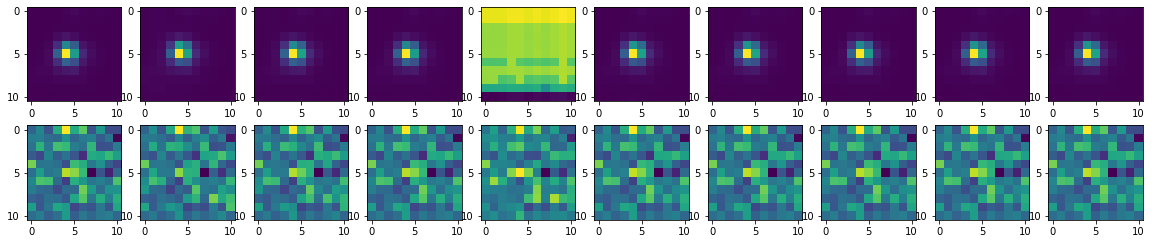

Epoch:  3
Total Loss: 1340.650146484375


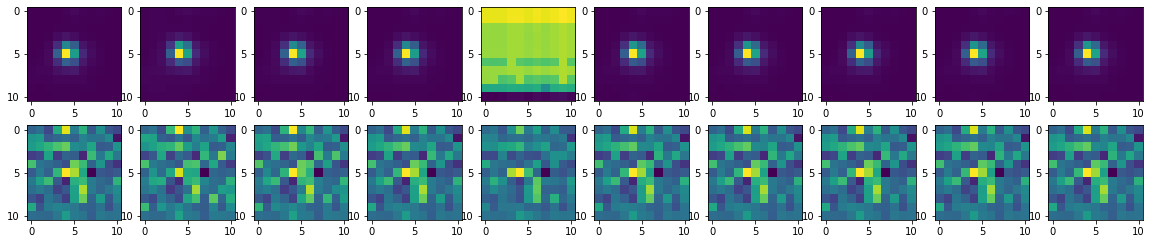

Epoch:  4
Total Loss: 1010.3148193359375


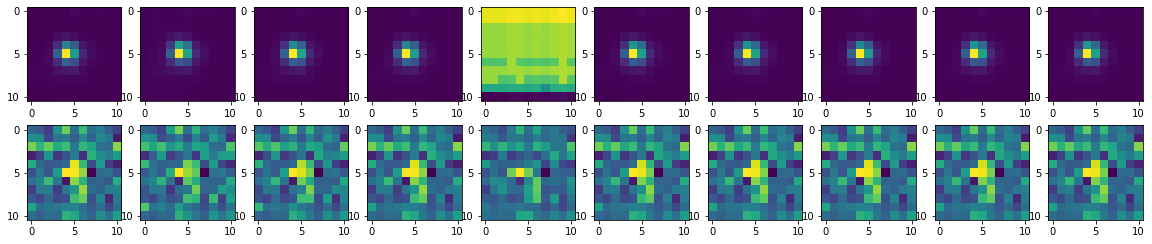

Epoch:  5
Total Loss: 675.9325561523438


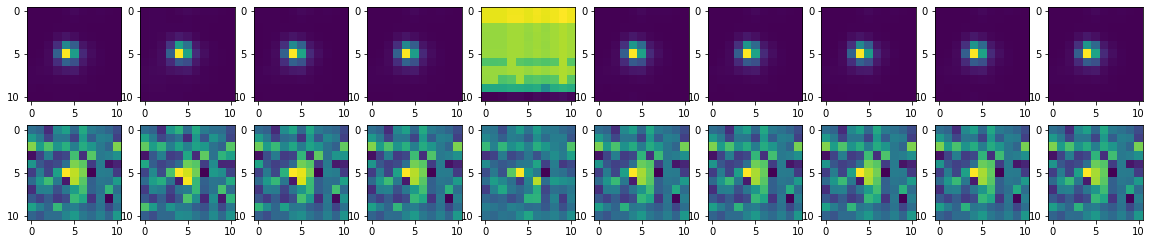

Epoch:  6
Total Loss: 419.449462890625


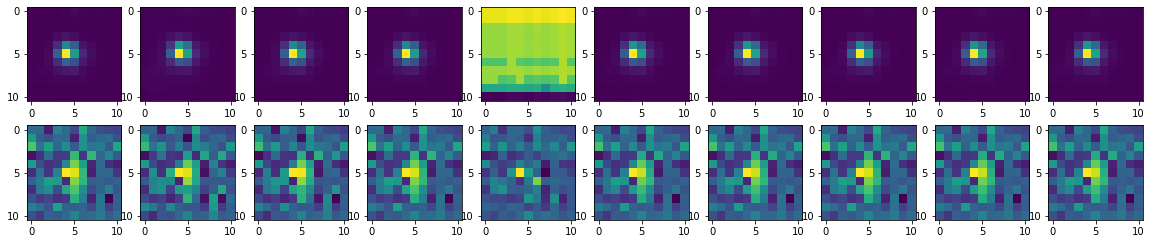

Epoch:  7
Total Loss: 284.7625732421875


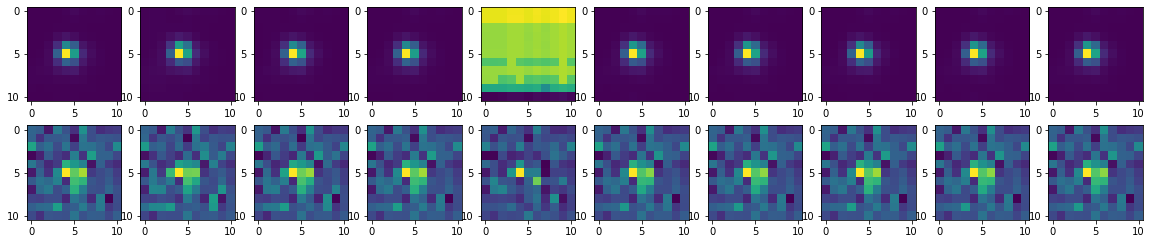

Epoch:  8
Total Loss: 195.3402862548828


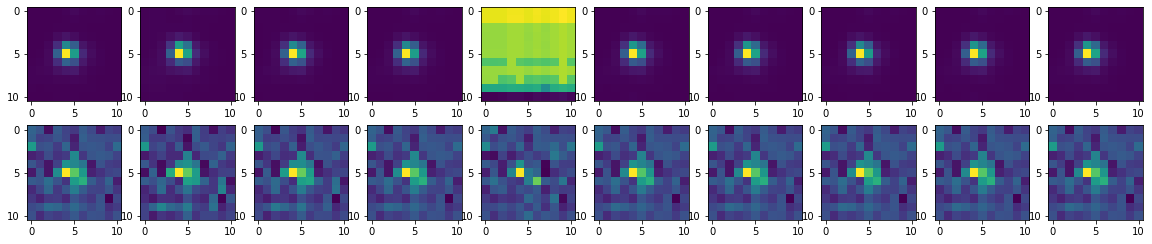

Epoch:  9
Total Loss: 159.25445556640625


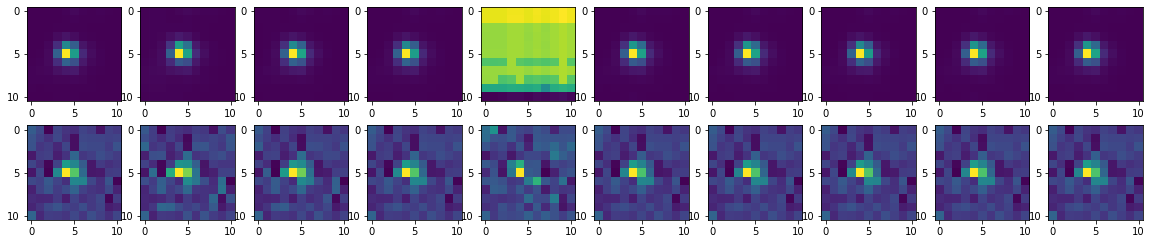

difference between test images 0.29458085
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 71.29402923583984


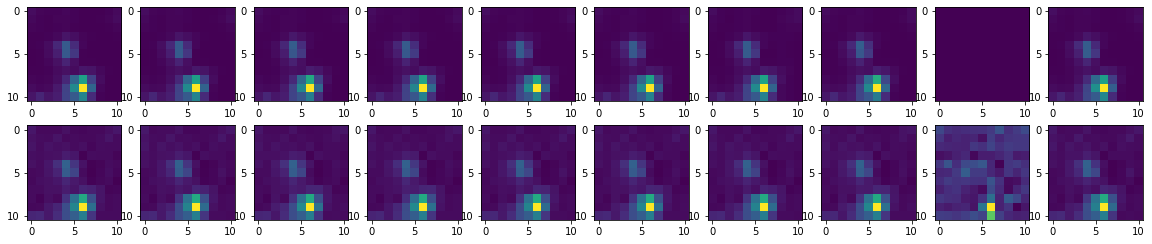

Epoch:  1
Total Loss: 44.260353088378906


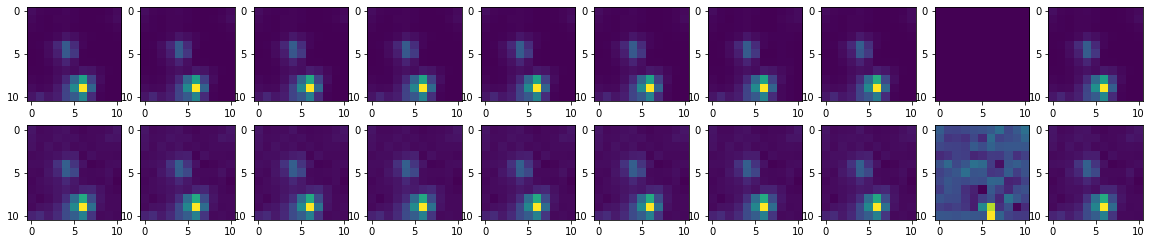

Epoch:  2
Total Loss: 30.957239151000977


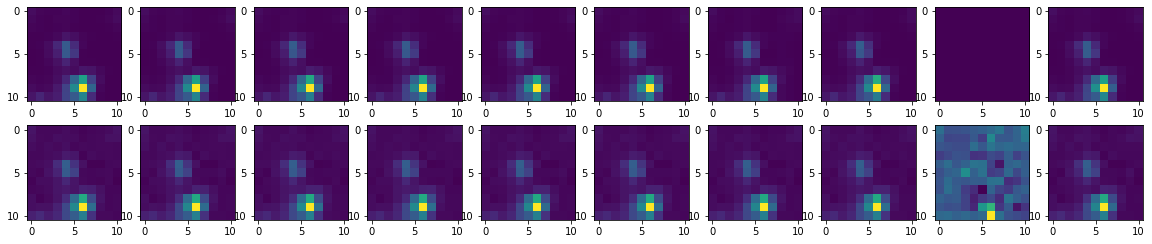

Epoch:  3
Total Loss: 24.011310577392578


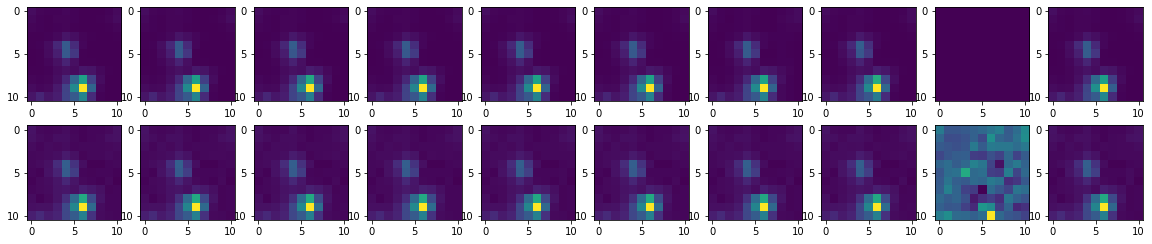

Epoch:  4
Total Loss: 20.433679580688477


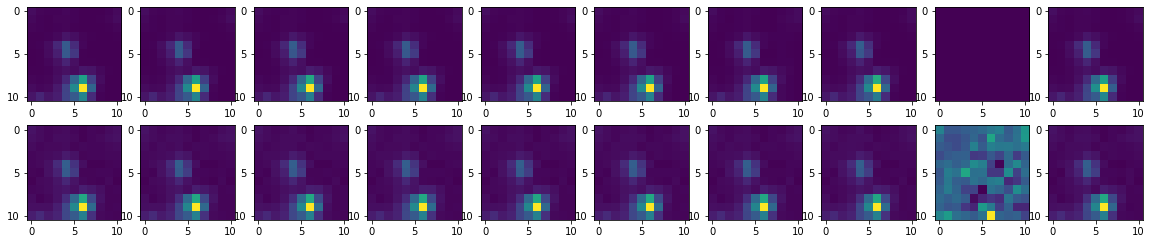

Epoch:  5
Total Loss: 34.39906692504883


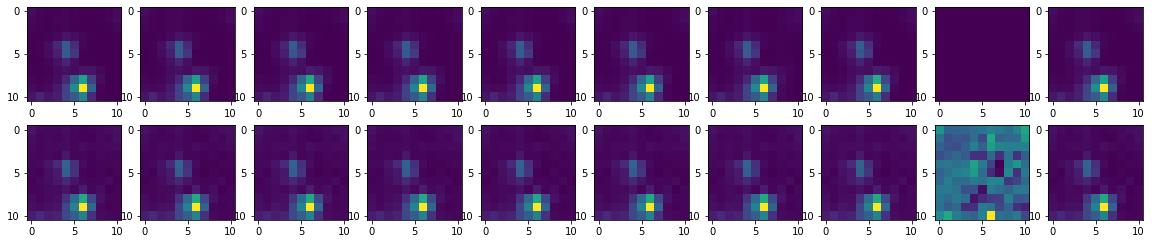

Epoch:  6
Total Loss: 15.894518852233887


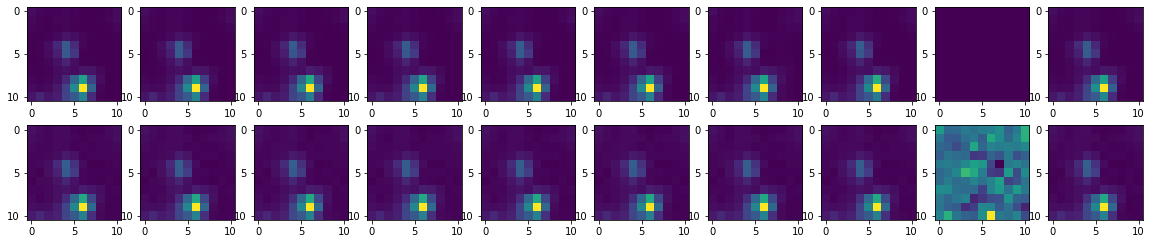

Epoch:  7
Total Loss: 16.396005630493164


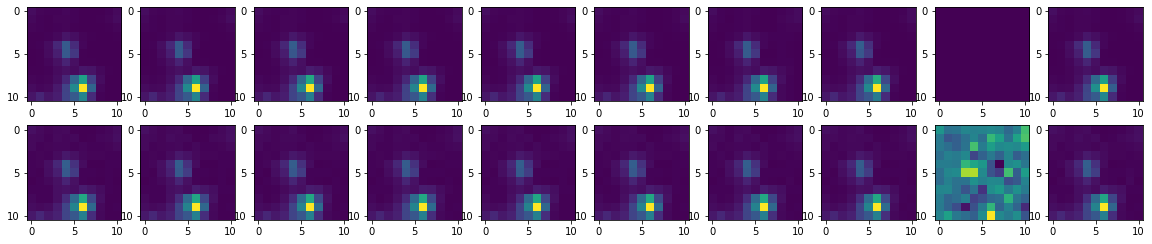

Epoch:  8
Total Loss: 14.451828002929688


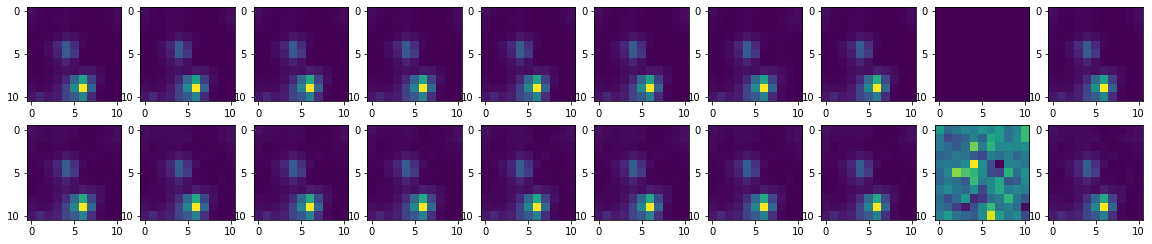

Epoch:  9
Total Loss: 13.890480995178223


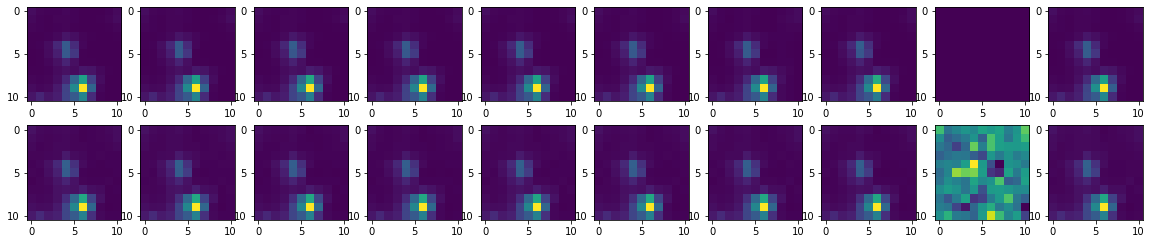

difference between test images 0.0726762
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 62.56611633300781


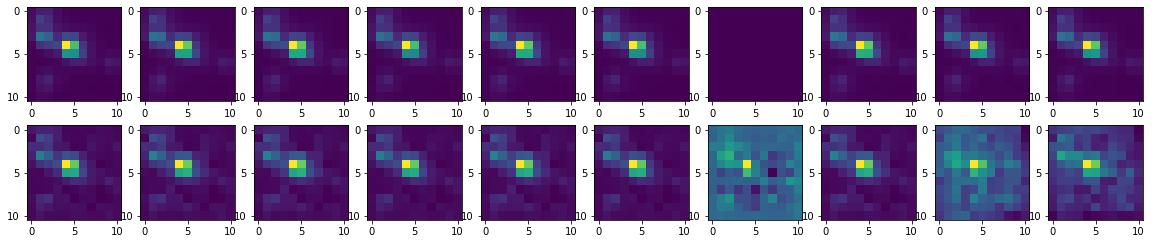

Epoch:  1
Total Loss: 24.853759765625


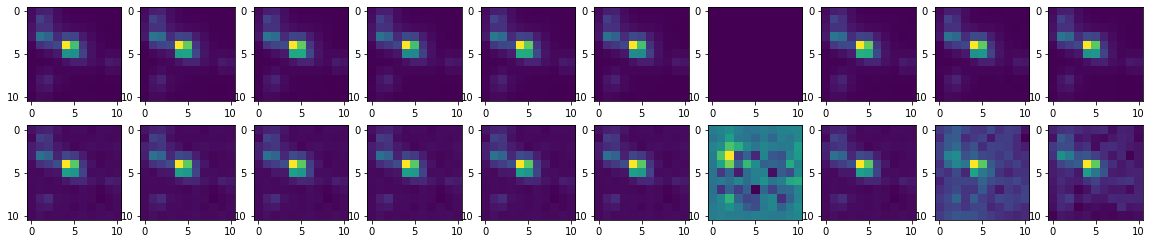

Epoch:  2
Total Loss: 12.707905769348145


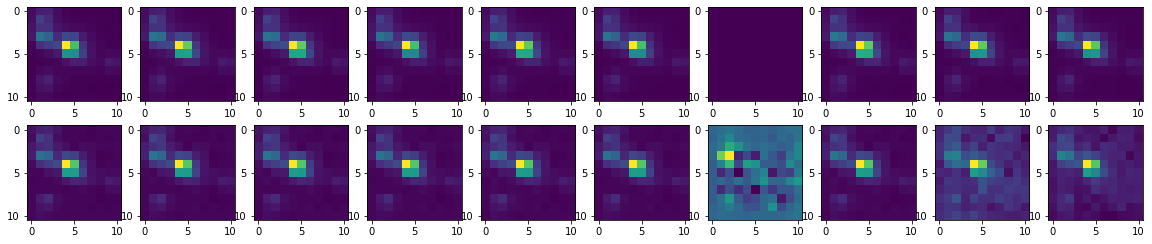

Epoch:  3
Total Loss: 8.69676685333252


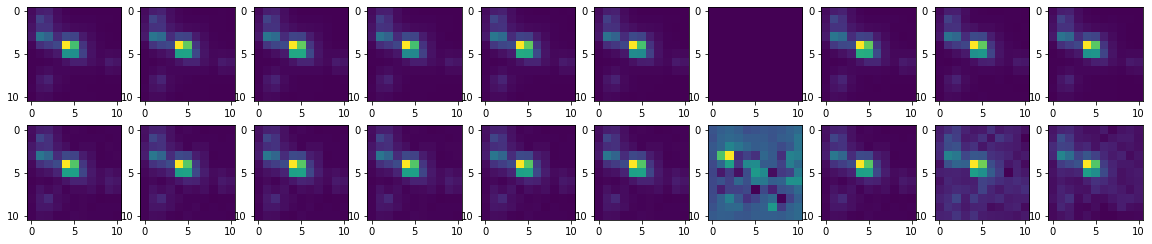

Epoch:  4
Total Loss: 7.886678218841553


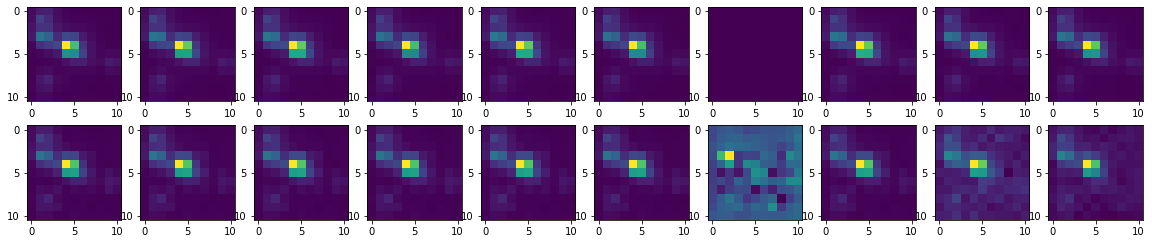

Epoch:  5
Total Loss: 12.860151290893555


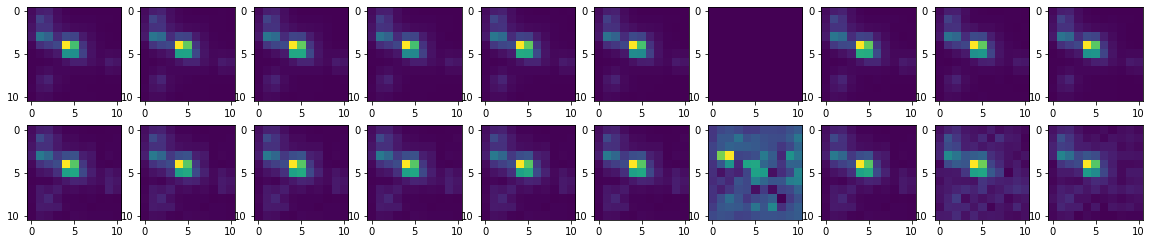

Epoch:  6
Total Loss: 12.501564979553223


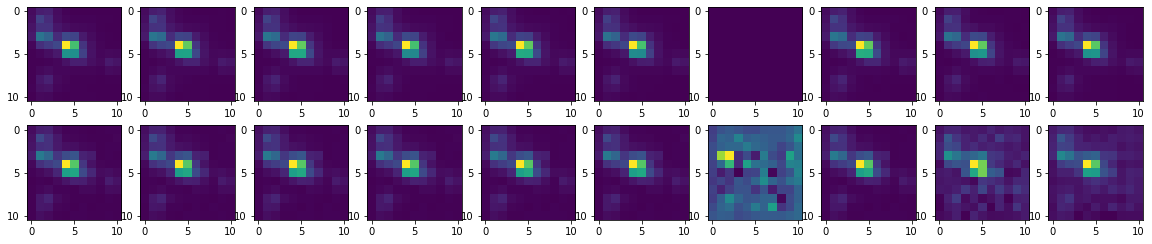

Epoch:  7
Total Loss: 5.688009262084961


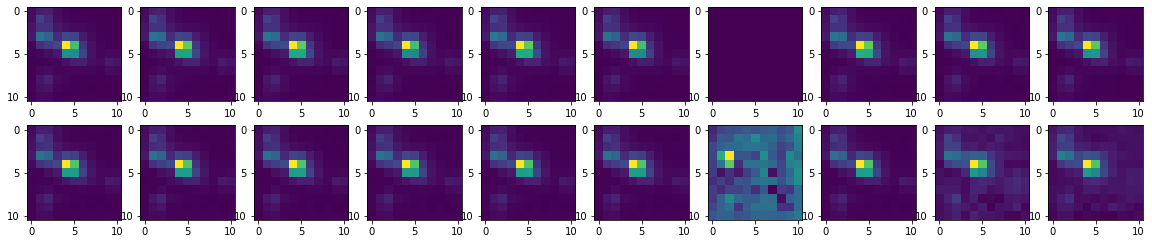

Epoch:  8
Total Loss: 7.329954147338867


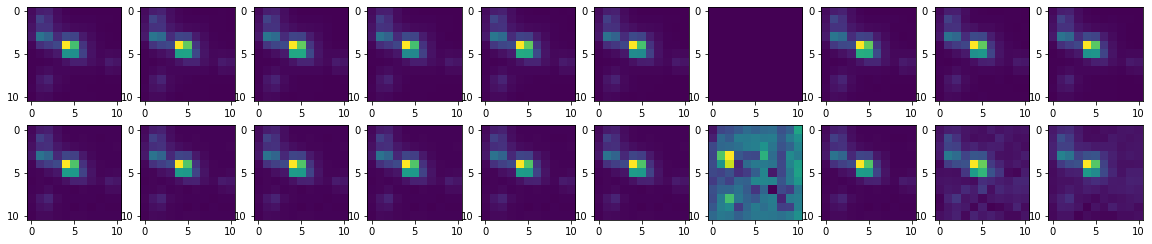

Epoch:  9
Total Loss: 5.608794689178467


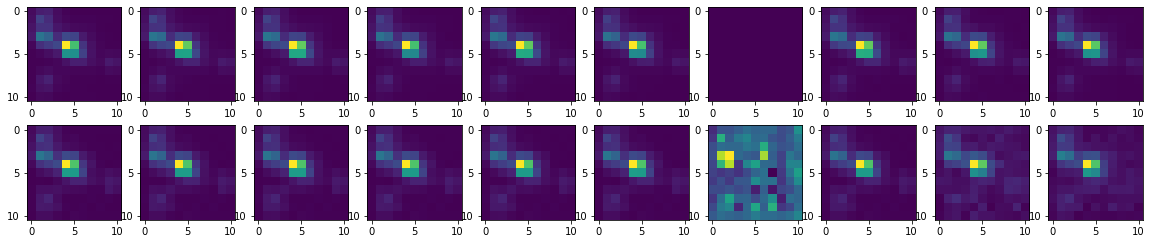

difference between test images 0.2855269
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 10.571027755737305


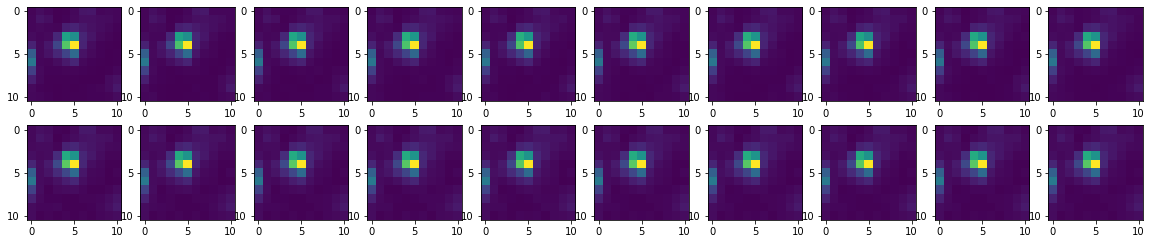

Epoch:  1
Total Loss: 13.60614013671875


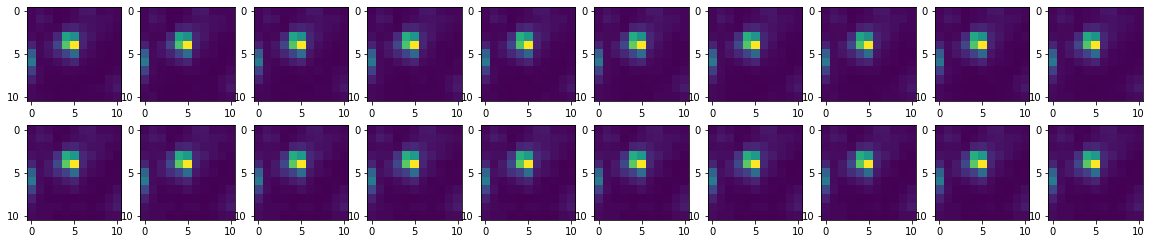

Epoch:  2
Total Loss: 9.170066833496094


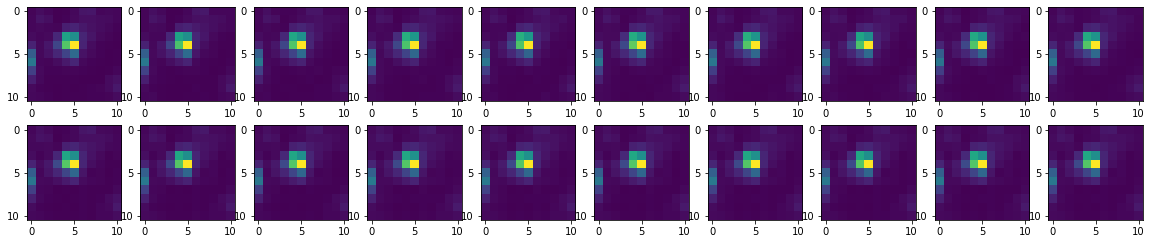

Epoch:  3
Total Loss: 10.600067138671875


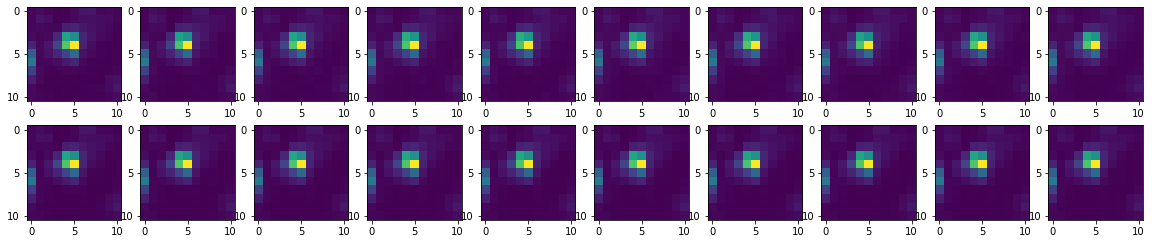

Epoch:  4
Total Loss: 8.25655460357666


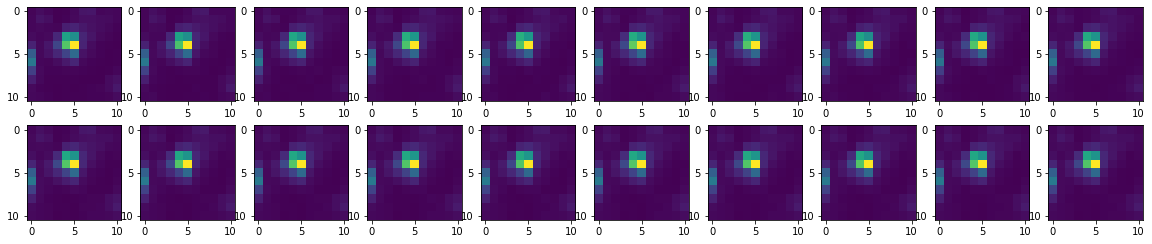

Epoch:  5
Total Loss: 7.172852516174316


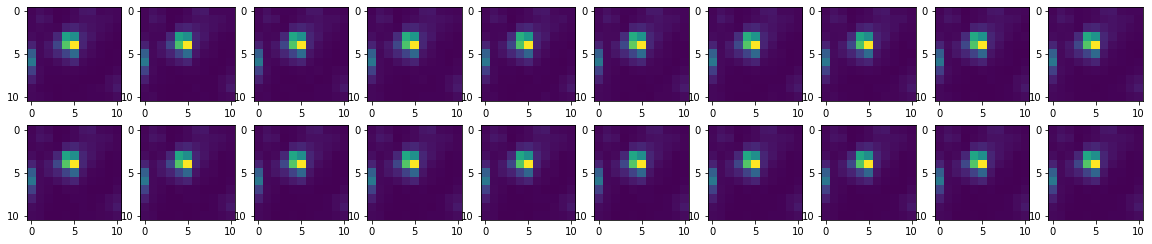

Epoch:  6
Total Loss: 5.018608093261719


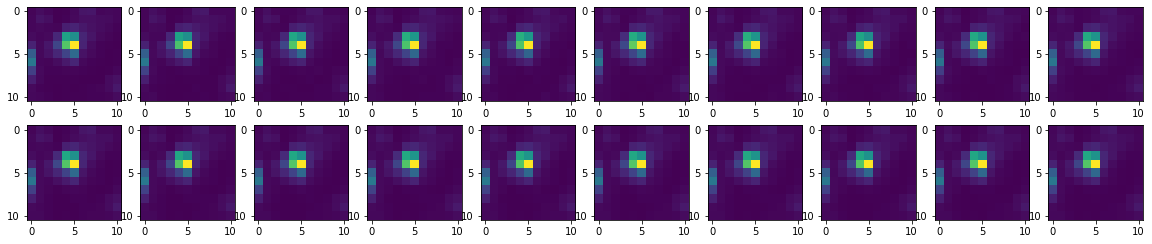

Epoch:  7
Total Loss: 4.437162399291992


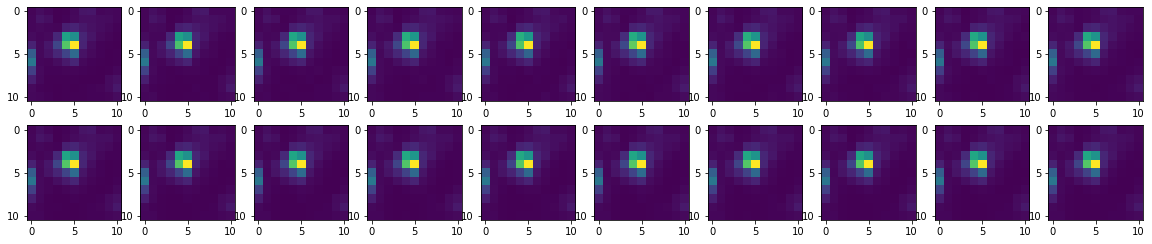

Epoch:  8
Total Loss: 4.834005832672119


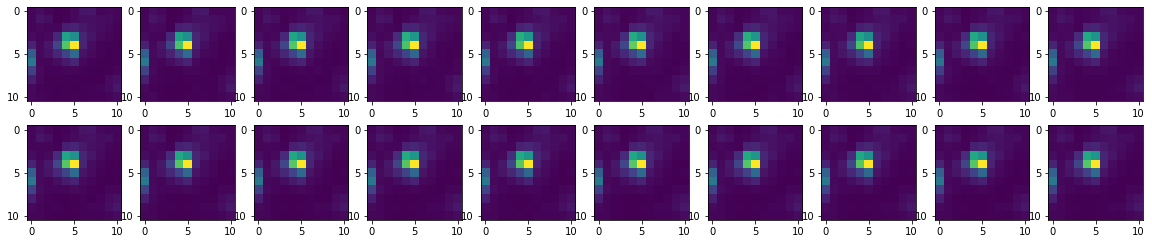

Epoch:  9
Total Loss: 4.036636829376221


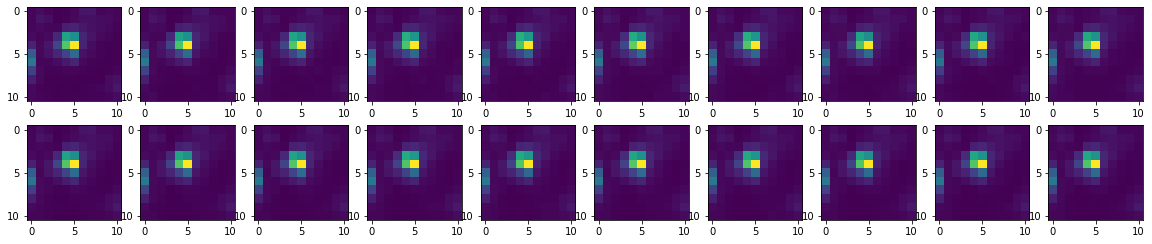

difference between test images 0.52157724
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 8.860992431640625


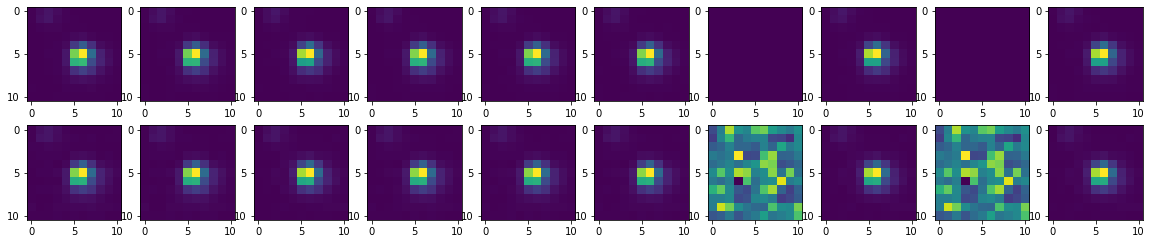

Epoch:  1
Total Loss: 7.785945892333984


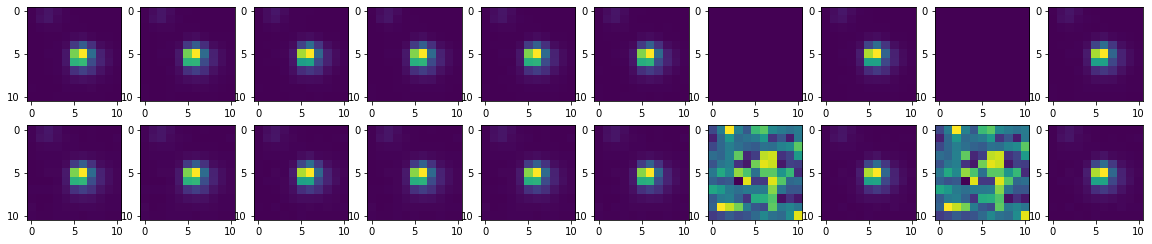

Epoch:  2
Total Loss: 4.123126029968262


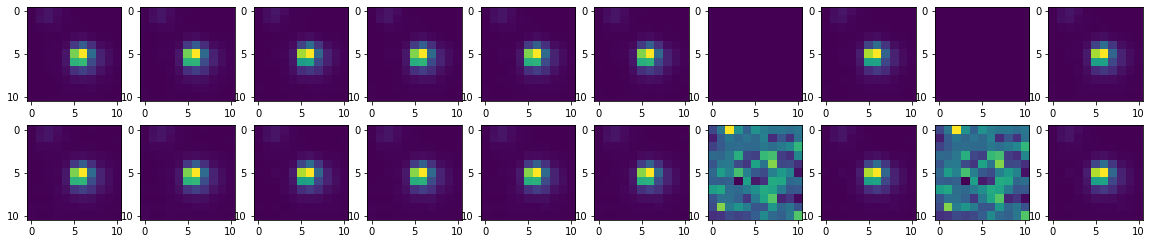

Epoch:  3
Total Loss: 3.702697277069092


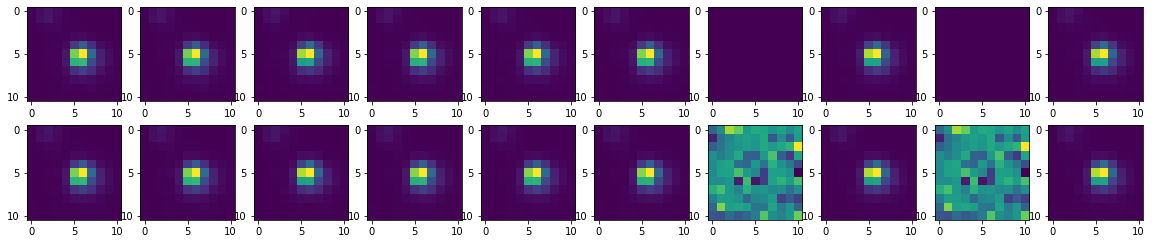

Epoch:  4
Total Loss: 9.955860137939453


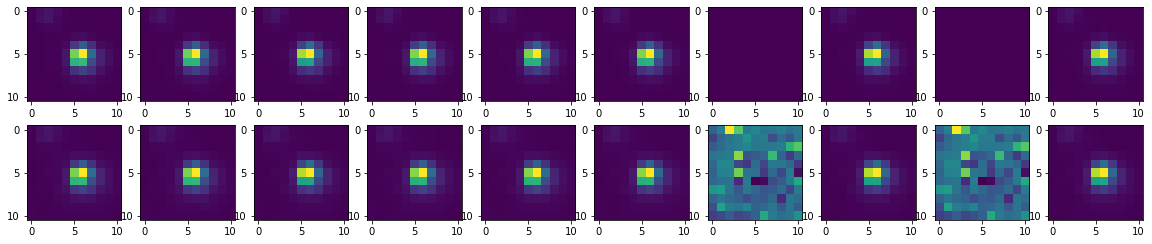

Epoch:  5
Total Loss: 8.215082168579102


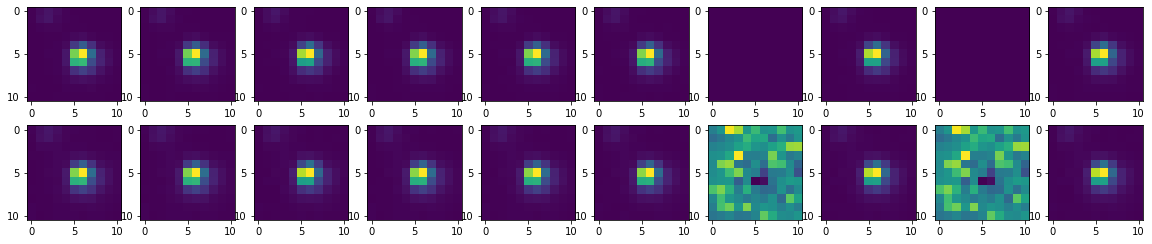

Epoch:  6
Total Loss: 7.650897979736328


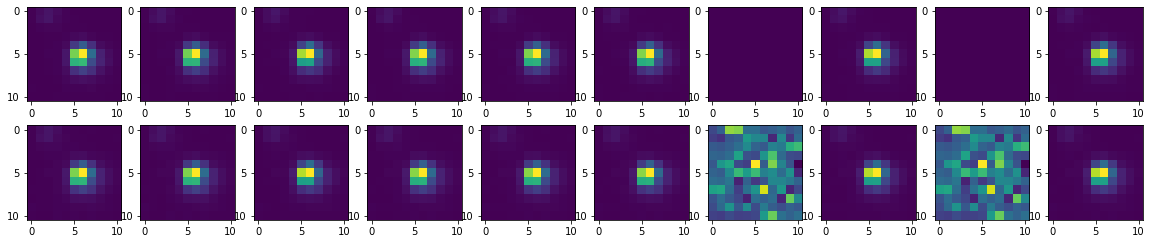

Epoch:  7
Total Loss: 8.536651611328125


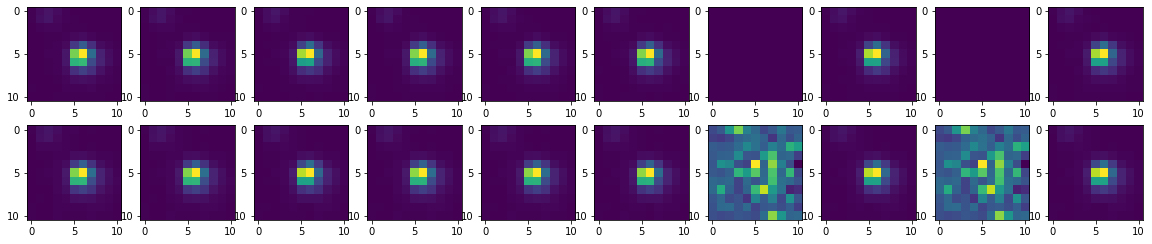

Epoch:  8
Total Loss: 2.2208447456359863


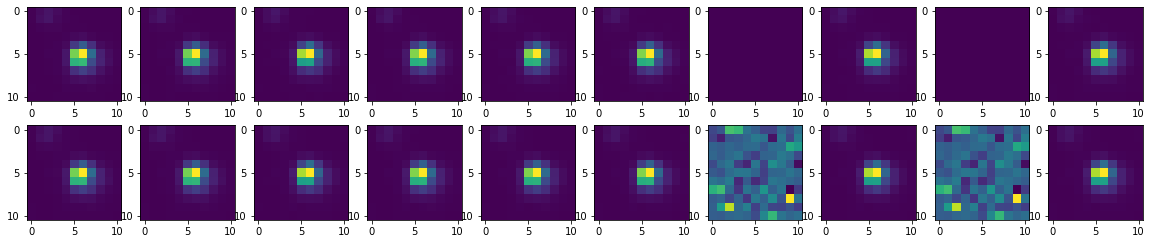

Epoch:  9
Total Loss: 3.130467414855957


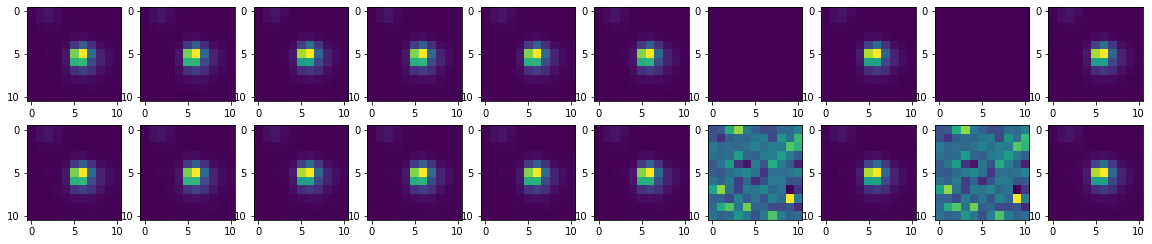

difference between test images 0.07201415
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 4.045114517211914


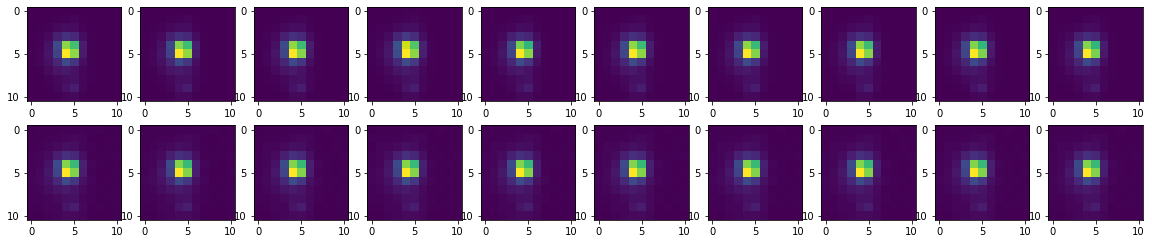

Epoch:  1
Total Loss: 4.331382751464844


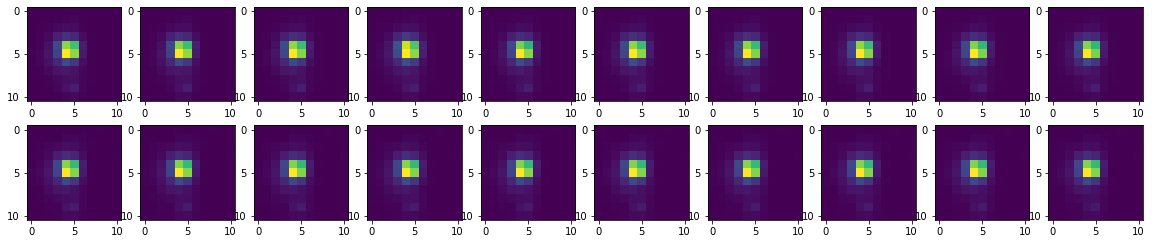

Epoch:  2
Total Loss: 6.516231536865234


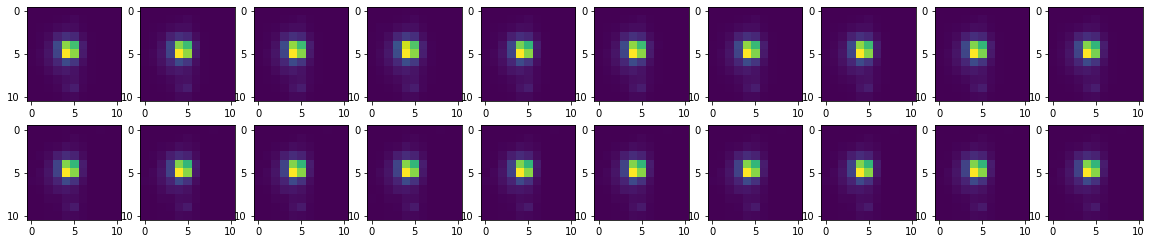

Epoch:  3
Total Loss: 4.484940528869629


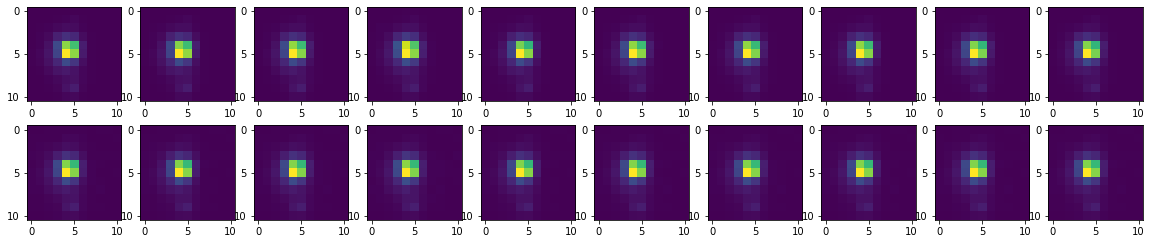

Epoch:  4
Total Loss: 7.092585563659668


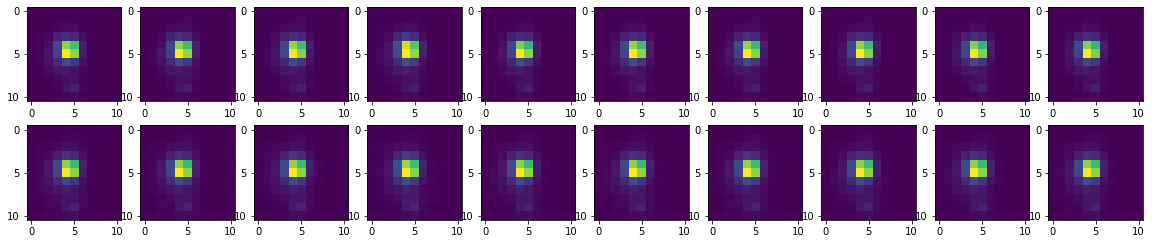

Epoch:  5
Total Loss: 4.543469429016113


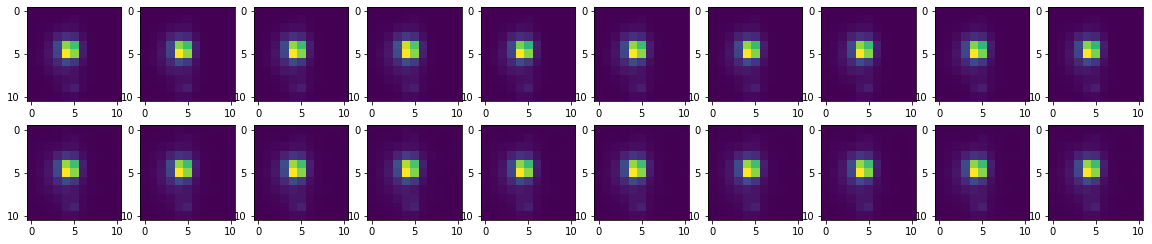

Epoch:  6
Total Loss: 12.443265914916992


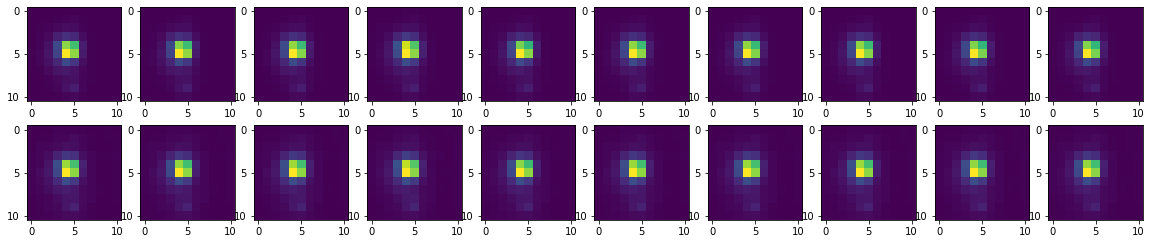

Epoch:  7
Total Loss: 7.853092670440674


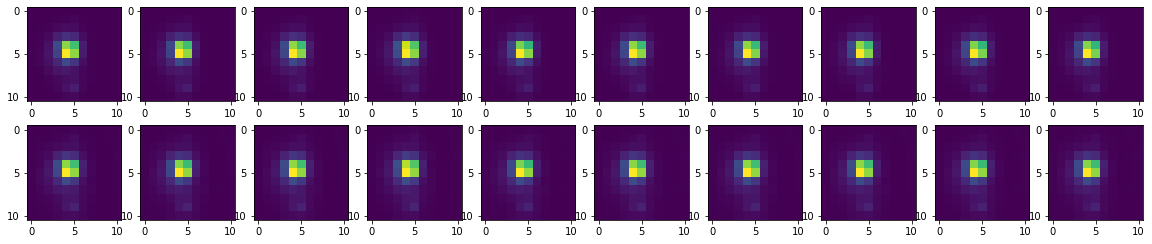

Epoch:  8
Total Loss: 3.609926700592041


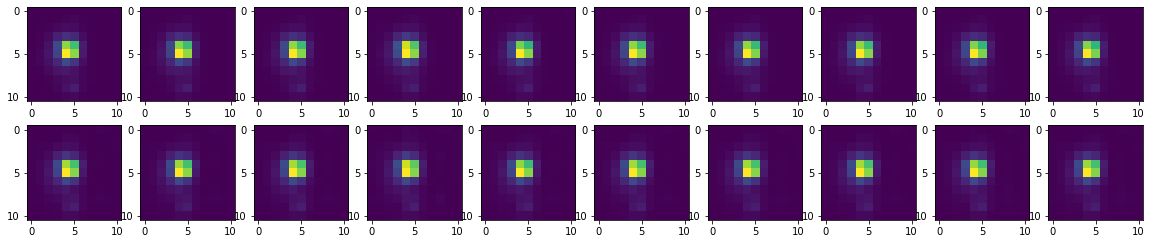

Epoch:  9
Total Loss: 3.115536689758301


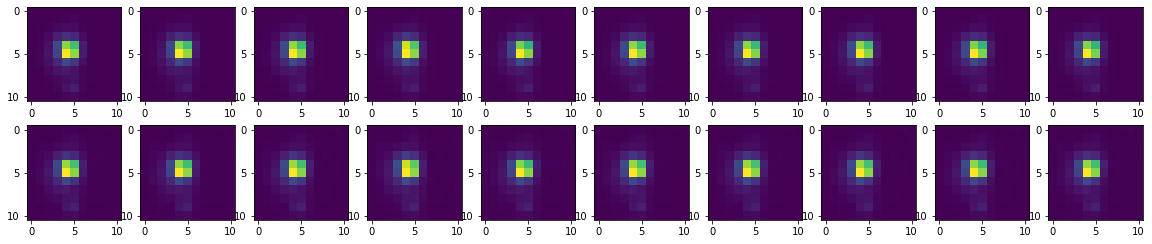

difference between test images 0.37335867
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 6.712596893310547


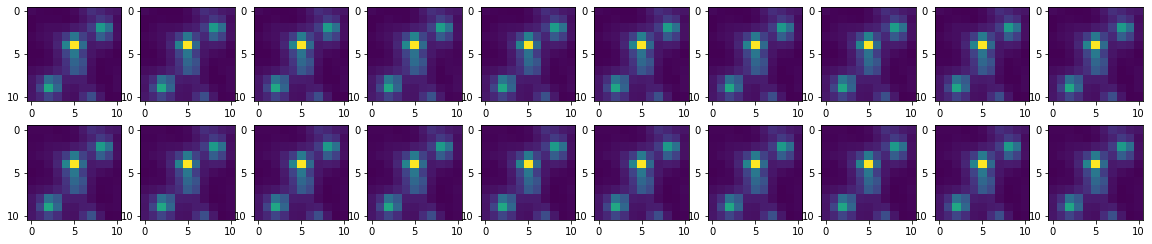

Epoch:  1
Total Loss: 4.720931053161621


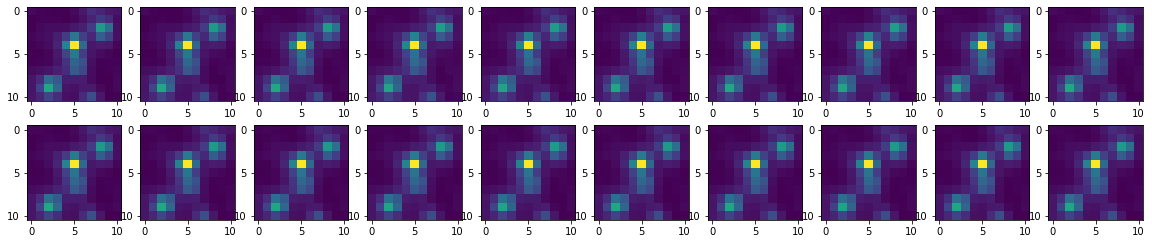

Epoch:  2
Total Loss: 4.634013652801514


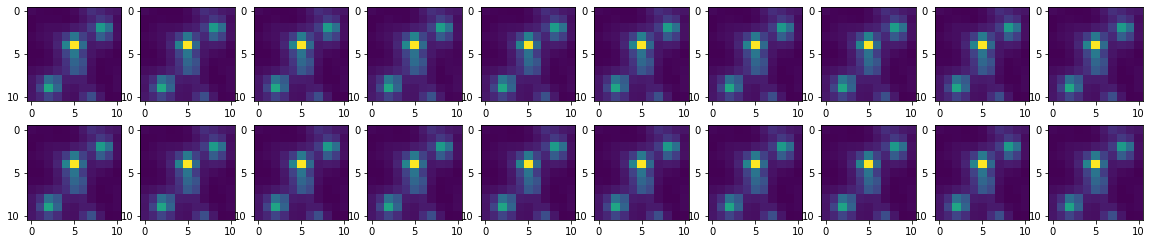

Epoch:  3
Total Loss: 4.492092132568359


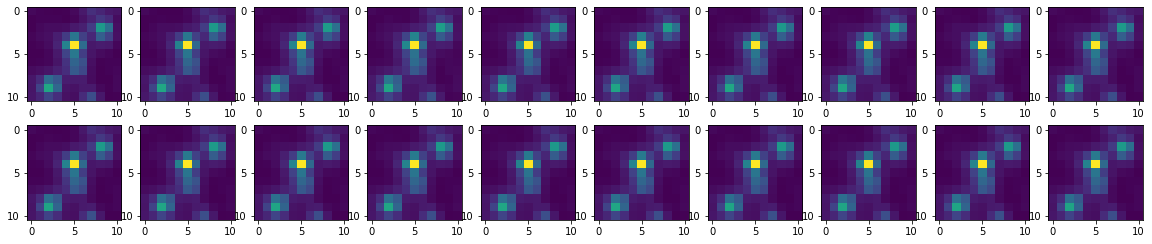

Epoch:  4
Total Loss: 3.133452892303467


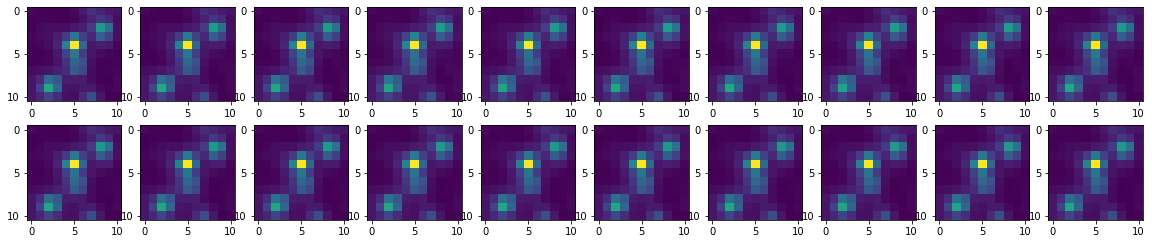

Epoch:  5
Total Loss: 3.095074415206909


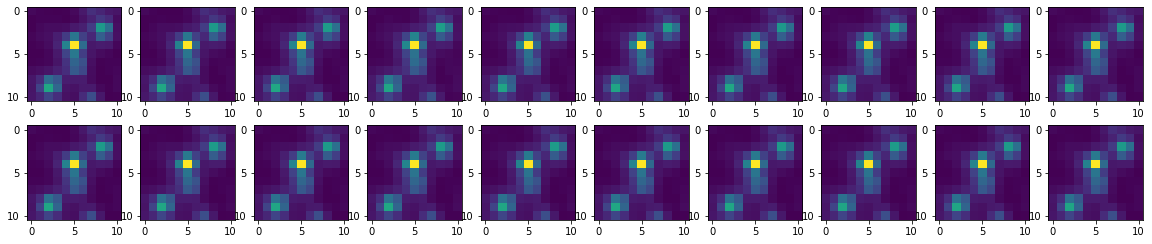

Epoch:  6
Total Loss: 3.081742763519287


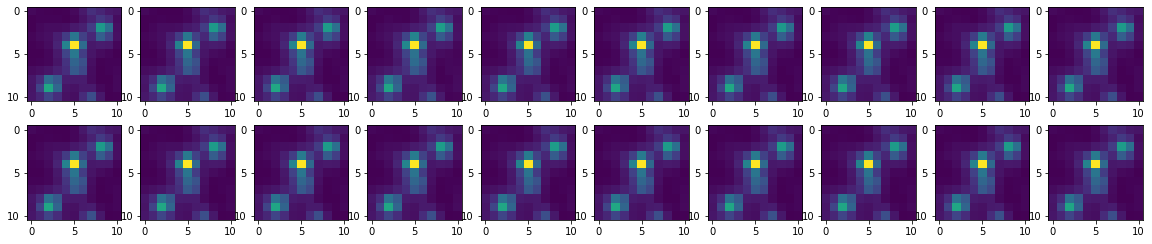

Epoch:  7
Total Loss: 2.8700451850891113


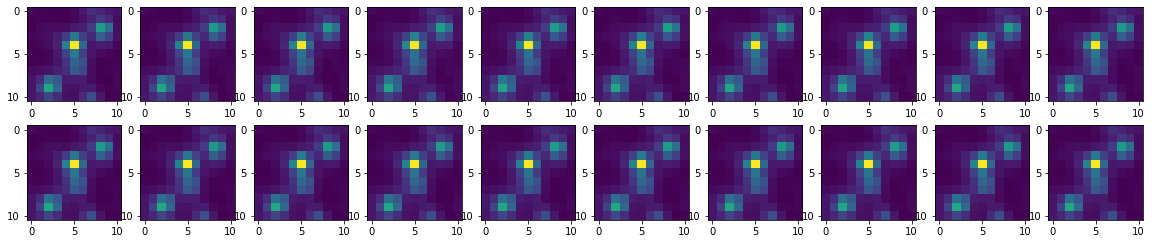

Epoch:  8
Total Loss: 2.125016212463379


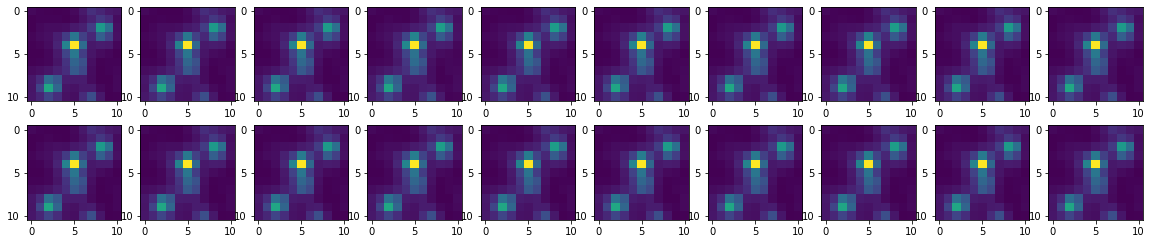

Epoch:  9
Total Loss: 1.8867771625518799


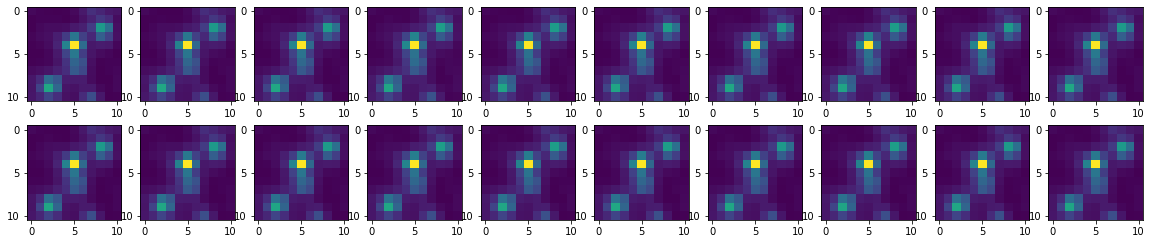

difference between test images 0.06809376
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 4.230493068695068


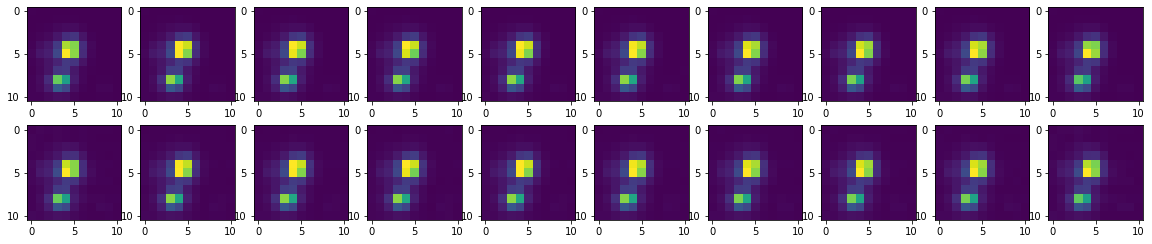

Epoch:  1
Total Loss: 3.7657837867736816


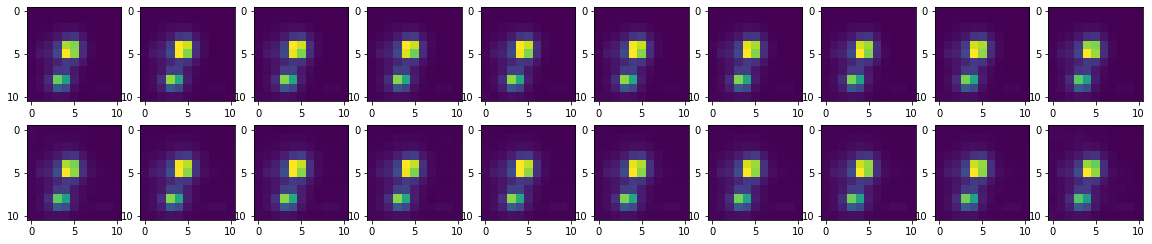

Epoch:  2
Total Loss: 5.059438228607178


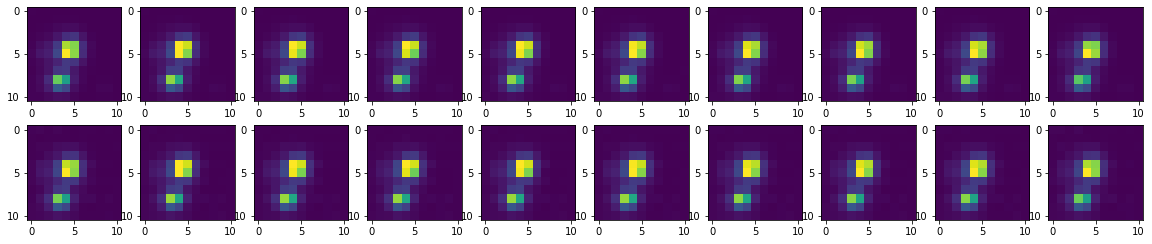

Epoch:  3
Total Loss: 3.1436047554016113


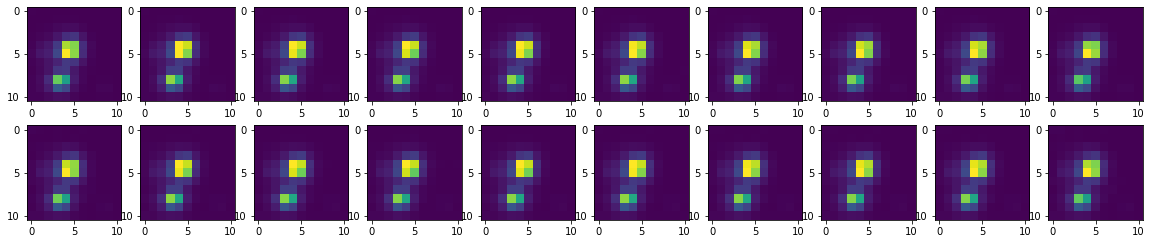

Epoch:  4
Total Loss: 3.954779624938965


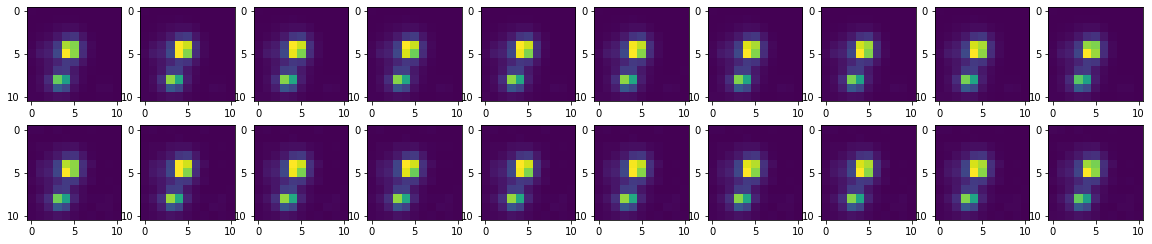

Epoch:  5
Total Loss: 2.909337043762207


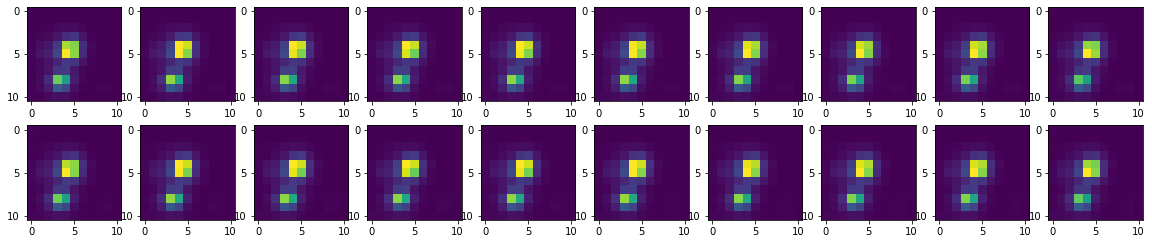

Epoch:  6
Total Loss: 5.341602325439453


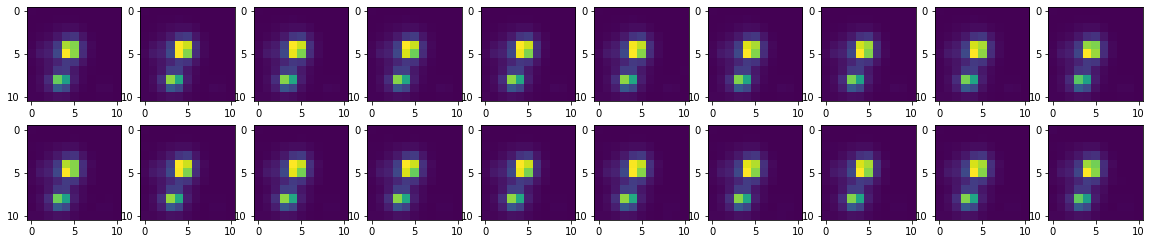

Epoch:  7
Total Loss: 4.798095226287842


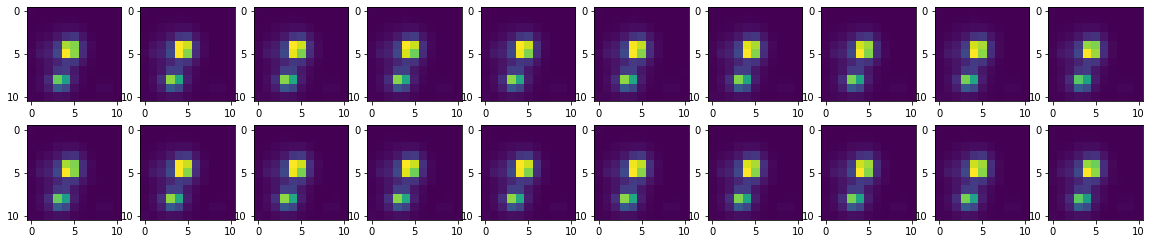

Epoch:  8
Total Loss: 1.9899482727050781


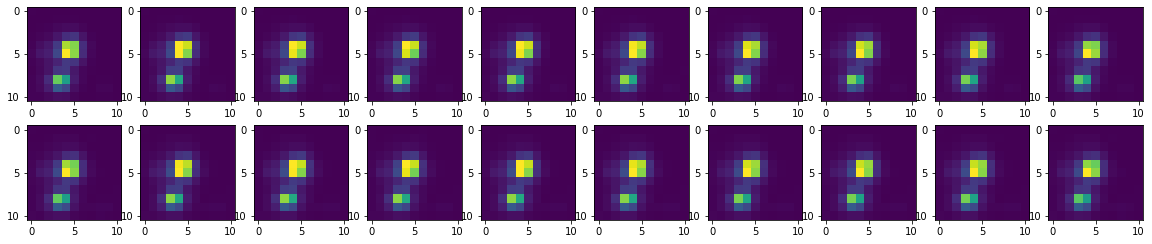

Epoch:  9
Total Loss: 1.654733419418335


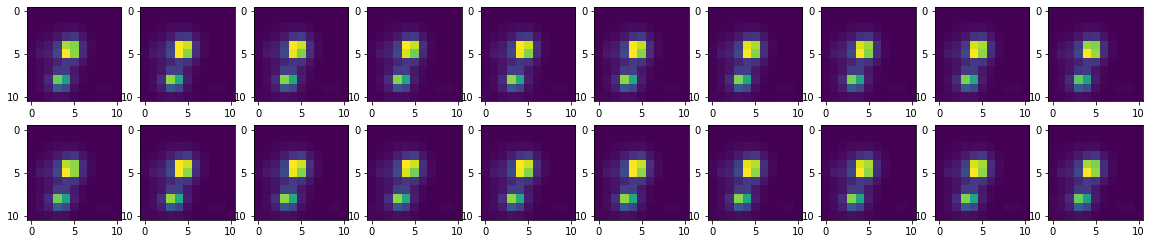

difference between test images 0.15648657
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 9.432384490966797


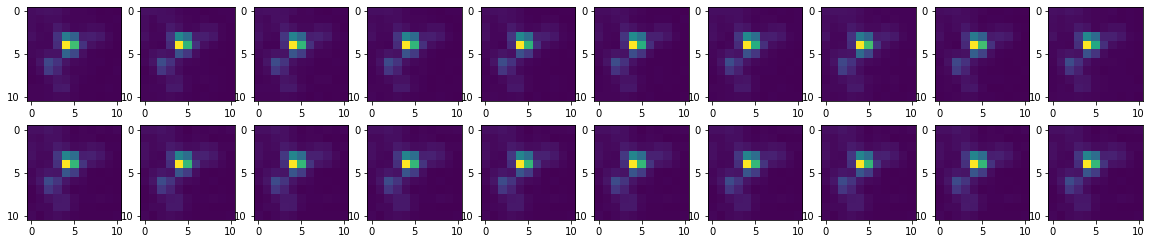

Epoch:  1
Total Loss: 6.916729927062988


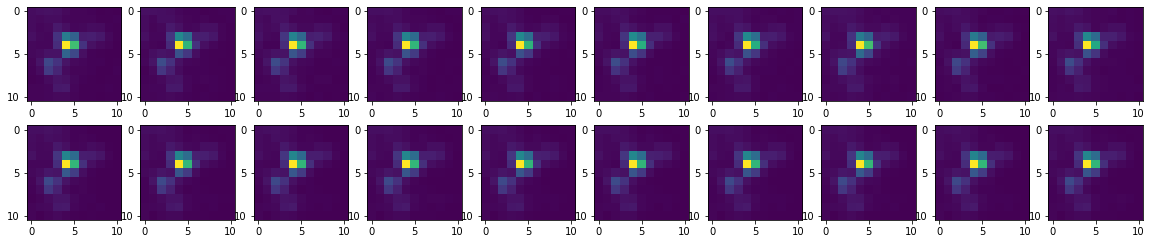

Epoch:  2
Total Loss: 6.026001930236816


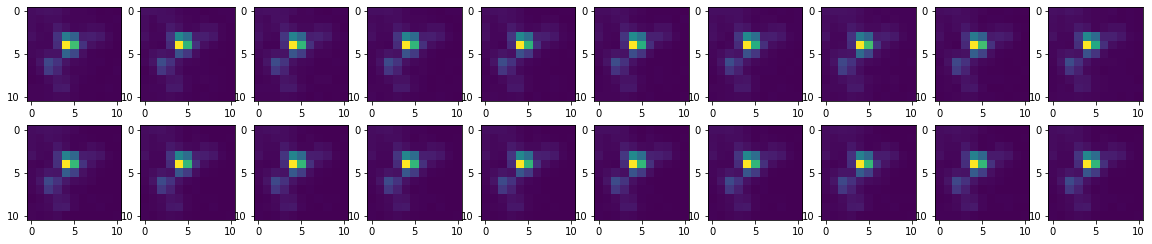

Epoch:  3
Total Loss: 5.408553123474121


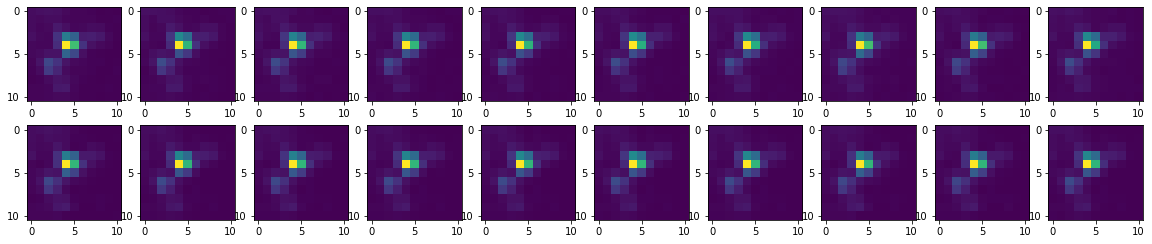

Epoch:  4
Total Loss: 5.020218849182129


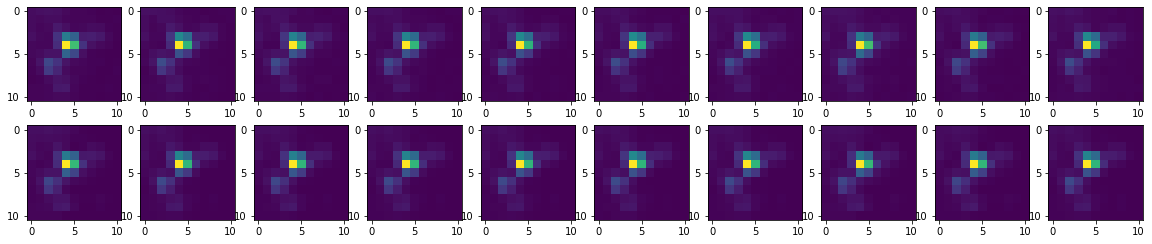

Epoch:  5
Total Loss: 4.514070510864258


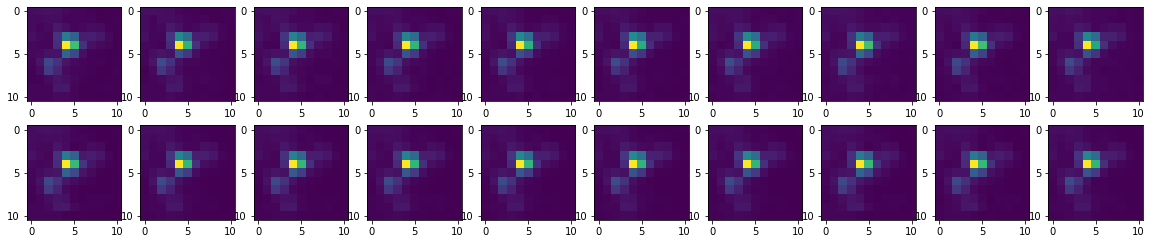

Epoch:  6
Total Loss: 4.223577499389648


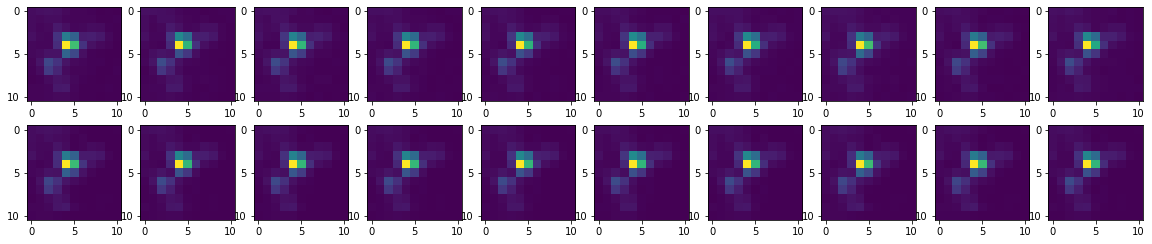

Epoch:  7
Total Loss: 4.663178443908691


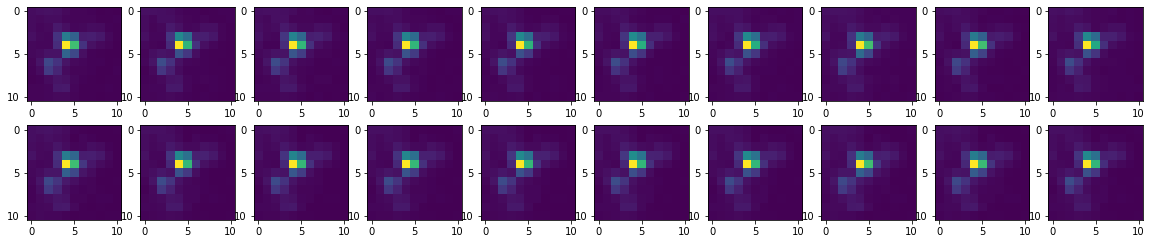

Epoch:  8
Total Loss: 3.7200167179107666


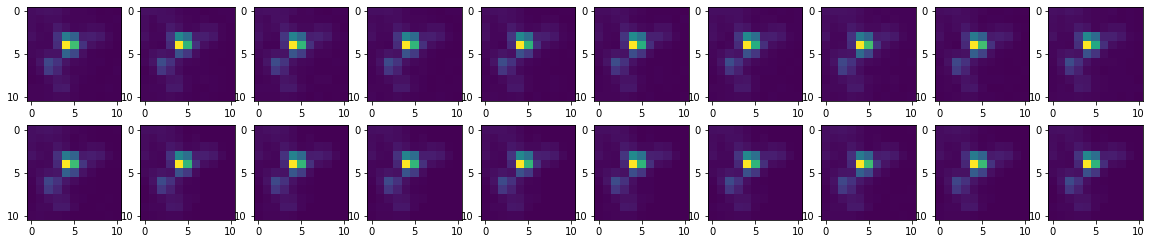

Epoch:  9
Total Loss: 5.924839019775391


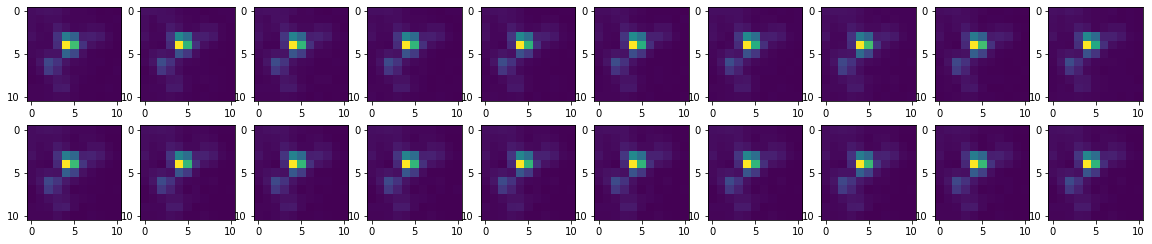

difference between test images 0.8436253
Showing autoencoder for noise function: <function no_noise at 0x7f2632220dd0>
Epoch:  0
Total Loss: 15.071249008178711


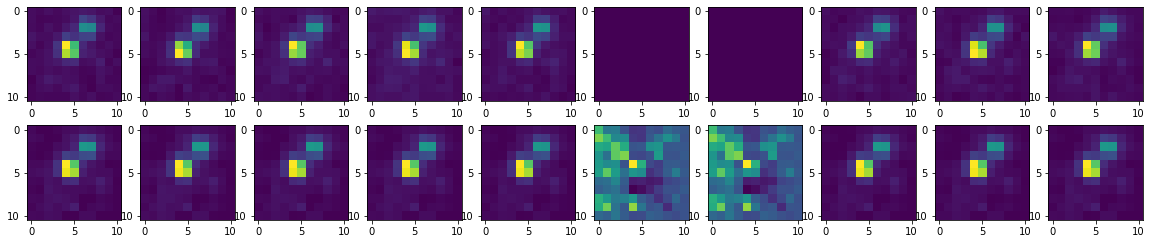

Epoch:  1
Total Loss: 7.940190315246582


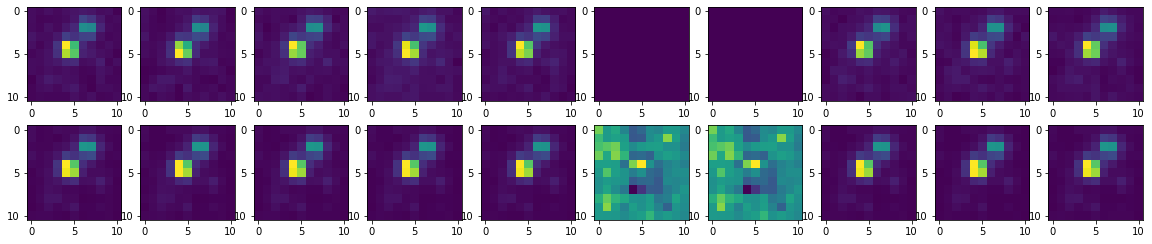

Epoch:  2
Total Loss: 11.431912422180176


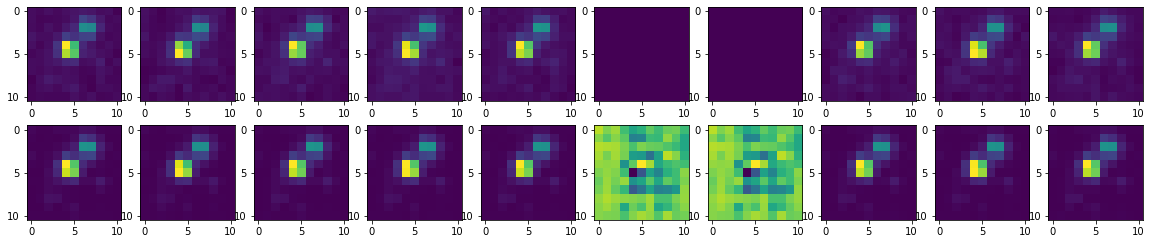

Epoch:  3
Total Loss: 57.04236602783203


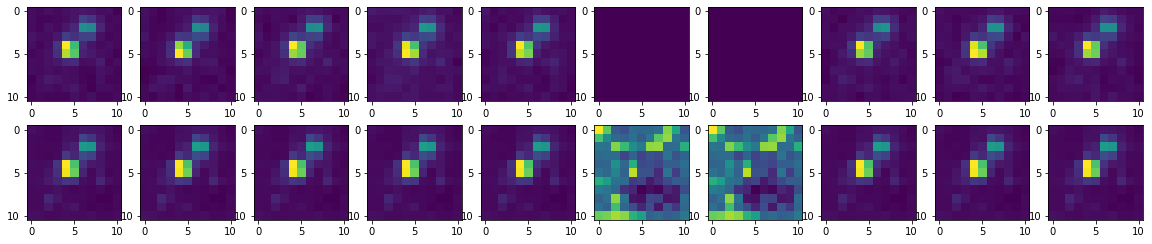

Epoch:  4
Total Loss: 33.39820098876953


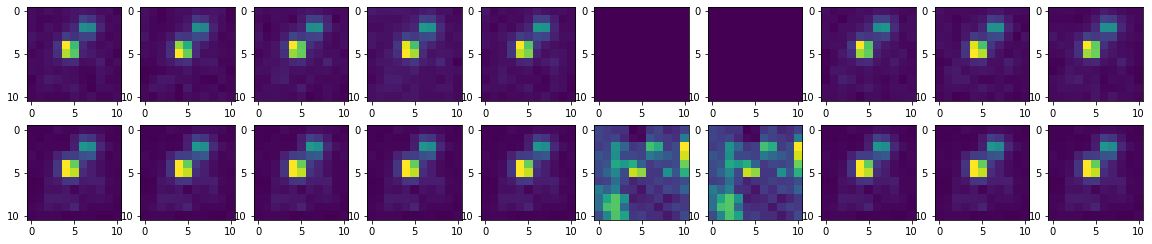

Epoch:  5
Total Loss: 40.11042022705078


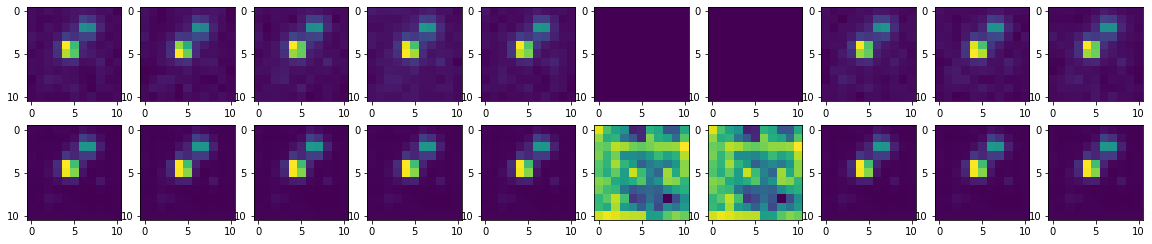

Epoch:  6
Total Loss: 19.630136489868164


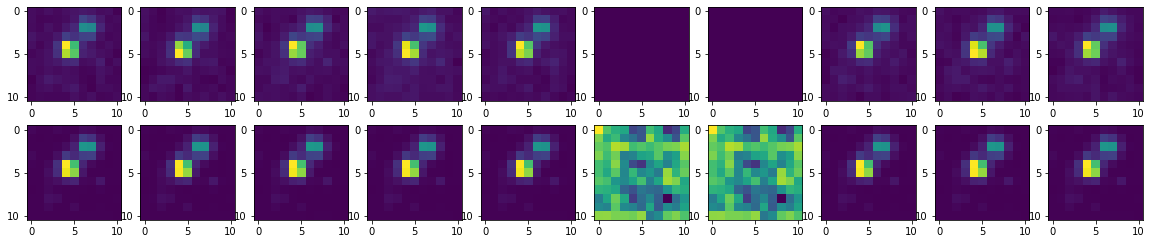

Epoch:  7
Total Loss: 40.628074645996094


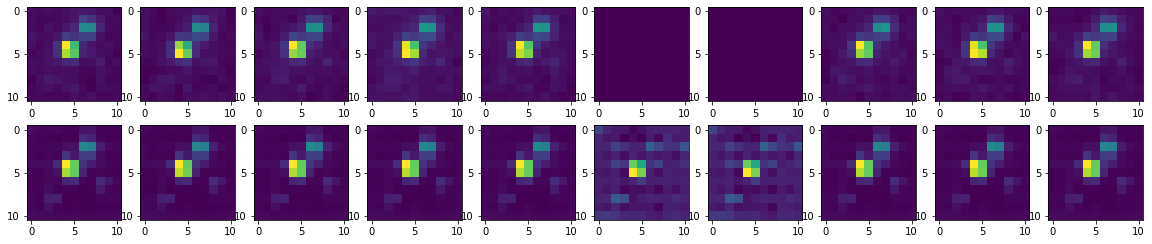

Epoch:  8
Total Loss: 44.87605667114258


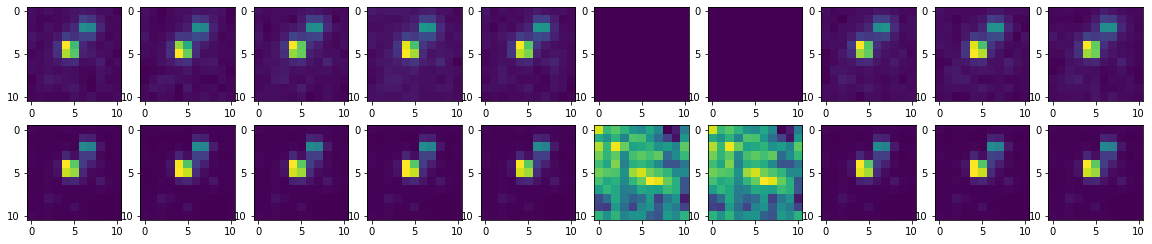

Epoch:  9
Total Loss: 12.799145698547363


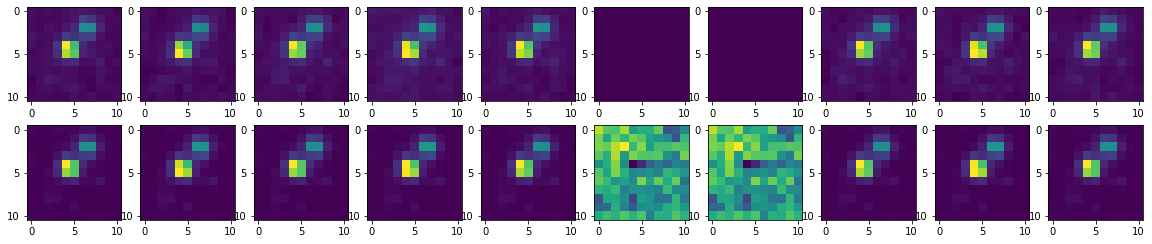

In [49]:
EPOCHES = 10
BATCH_SIZE = 30

x_train_pixelfiles, x_train_lightcurves, tess_lightcurves = get_training_dataset()

model_30 = AutoEncoder()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


for i in range(len(x_train_pixelfiles)):
  tpf = x_train_pixelfiles[i]
  try:
    flux_images = np.nan_to_num(tpf.hdu[1].data["FLUX"],nan=0)
  except AttributeError:
    continue
  flux_images = tf.random.shuffle(flux_images)  
  train_images = flux_images[:int(flux_images.shape[0] * 0.9)]
  test_images = flux_images[int(flux_images.shape[0] * 0.9):]
 
  #scale image to 0 and 1
  test_images = test_images / np.max(np.abs(flux_images))
  train_images = train_images / np.max(np.abs(flux_images))
  example_images = test_images[:EXAMPLES]
  print("difference between test images",np.sum(np.abs(test_images[2]-test_images[1])))

  for noise_function in [no_noise]:
    print("Showing autoencoder for noise function: {0}".format(noise_function))
   
    for i in range(EPOCHES):
      for j in range(0, len(train_images), BATCH_SIZE):     
        train(model_30, optimizer, train_images[j:j+BATCH_SIZE], noise_function)
    
      print("Epoch: ", i)
      sum_loss = total_loss(model_30, test_images, noise_function)
      print("Total Loss: {0}".format(sum_loss))
      showImages(model_30, noise_function, example_images)
    






##Test 2D Autoencoder

In [50]:
def test_2D(trained_model):
  samples_per_day = 1 + 60 * 24 // 2
  x_test_pixelfiles,x_test_lightcurves,tess_test_lightcurves = get_hatp_test_dataset()

  for lc_name, tpf1 in x_test_pixelfiles.items():
    original_lc = tpf1.to_lightcurve(aperture_mask=tpf1.pipeline_mask)
    flat_lc = original_lc.flatten(samples_per_day)
    
    print("old noisy")
    fit_and_report(flat_lc,lc_name, "original")

    tess_lc = tess_test_lightcurves[lc_name]
    tess_lc = tess_lc.flatten(samples_per_day)
    
    print("Tess")
    fit_and_report(tess_lc,lc_name, "tess")

    original_tpf_flux = tpf1.hdu[1].data["FLUX"].copy()

    original_tpf_flux_copy = np.nan_to_num(original_tpf_flux,nan=1) 

    #normalize
    original_tpf_flux_copy /= np.max(np.abs(original_tpf_flux_copy))

    # mutate the internal structure so that we can use their code to generate a lightcurve
    out = trained_model(tf.reshape(original_tpf_flux_copy , [-1,11,11,1]))

    out = tf.reshape(out, original_tpf_flux_copy.shape)

    tpf1.hdu[1].data["FLUX"][:out.shape[0]] = out
  
    # use the provided aperture mask to generate a light curve  
    new_lc = tpf1.to_lightcurve(aperture_mask=tpf1.pipeline_mask)
    flat_new_lc = new_lc.flatten(samples_per_day);

    # mutate the internal structure back so that we haven't changed the tpf1
    tpf1.hdu[1].data["FLUX"] = original_tpf_flux
  
    fit_and_report(flat_new_lc,lc_name, "2D new")


###Test model trained with HAT-P-11-b only

appended HAT-P-2, sector=24
appended HAT-P-11, sector=14
appended HAT-P-14, sector=25
finished downloading test dataset
old noisy
5.591387655656453
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18217 data points, 119 periods from 5.033 to 6.141 days
Using all 2 CPU threads


100%|██████████| 119/119 periods | 00:07<00:00


Results for original HAT-P-2 sector-24
Period 5.63544 d
5 transit times in time series: ['1956.23520', '1961.87064', '1967.50608', '1973.14152', '1978.77695']
Transit depth 0.99739
Transit duration (days) 0.17767
SNR 74.85421210246285
chi2 13584.96060195475
CDPP 281.80567357131827 ppm
Tess
5.591387655656453
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18217 data points, 119 periods from 5.033 to 6.141 days
Using all 2 CPU threads


100%|██████████| 119/119 periods | 00:06<00:00


Results for tess HAT-P-2 sector-24
Period 5.63544 d
5 transit times in time series: ['1956.23322', '1961.86866', '1967.50410', '1973.13954', '1978.77497']
Transit depth 0.99520
Transit duration (days) 0.17767
SNR 141.97002053311206
chi2 4970.375734880969
CDPP 133.4130604469745 ppm
1.878291624085907
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 25 durations
Searching 18217 data points, 171 periods from 1.692 to 2.065 days
Using all 2 CPU threads


100%|██████████| 171/171 periods | 00:06<00:00


Results for 2D new HAT-P-2 sector-24
Period 1.88159 d
14 transit times in time series: ['1956.22972', '1958.11131', '1959.99291', '1961.87450', '1963.75609', '1965.63768', '1967.51927', '1969.40086', '1971.28245', '1973.16405', '1975.04564', '1976.92723', '1978.80882', '1980.69041']
Transit depth 0.99927
Transit duration (days) 0.14434
SNR 8.603329796919386
chi2 18148.642767719368
CDPP 739.2201571847014 ppm
old noisy
4.906519489266026
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18424 data points, 126 periods from 4.418 to 5.391 days
Using all 2 CPU threads


100%|██████████| 126/126 periods | 00:07<00:00


Searching for best T0 for period 4.88363 days


100%|██████████| 6161/6161 [00:03<00:00, 1889.29it/s]


Results for original HAT-P-11 sector-14
Period 4.88363 d
5 transit times in time series: ['1687.21692', '1692.10055', '1696.98418', '1701.86781', '1706.75143']
Transit depth 0.99788
Transit duration (days) 0.08312
SNR 39.783440666891394
chi2 16865.490031358288
CDPP 224.99607989783468 ppm
Tess
4.906519489266026
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18424 data points, 126 periods from 4.418 to 5.391 days
Using all 2 CPU threads


100%|██████████| 126/126 periods | 00:09<00:00


Searching for best T0 for period 4.89141 days


100%|██████████| 6773/6773 [00:03<00:00, 2191.58it/s]


Results for tess HAT-P-11 sector-14
Period 4.89141 d
5 transit times in time series: ['1687.19864', '1692.09005', '1696.98147', '1701.87288', '1706.76429']
Transit depth 0.99654
Transit duration (days) 0.07557
SNR 75.69409340165893
chi2 13070.868596551592
CDPP 170.626614635056 ppm


/usr/local/lib/python3.7/dist-packages/lightkurve/periodogram.py:364: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/lightkurve/lightcurve.py:1774: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


4.906519489266026
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18424 data points, 126 periods from 4.418 to 5.391 days
Using all 2 CPU threads


100%|██████████| 126/126 periods | 00:08<00:00


Searching for best T0 for period 4.89141 days


100%|██████████| 6161/6161 [00:02<00:00, 2147.69it/s]


Results for 2D new HAT-P-11 sector-14
Period 4.89141 d
5 transit times in time series: ['1687.19846', '1692.08988', '1696.98129', '1701.87271', '1706.76412']
Transit depth 0.99818
Transit duration (days) 0.08312
SNR 24.07921771001842
chi2 18040.526821480555
CDPP 328.12378484871306 ppm


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


old noisy
4.6065820396818875


/usr/local/lib/python3.7/dist-packages/lightkurve/periodogram.py:364: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/lightkurve/lightcurve.py:1774: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 17246 data points, 124 periods from 4.146 to 5.067 days
Using all 2 CPU threads


100%|██████████| 124/124 periods | 00:06<00:00


Results for original HAT-P-14 sector-25
Period 4.62463 d
6 transit times in time series: ['1984.66107', '1989.28570', '1993.91034', '1998.53497', '2003.15960', '2007.78424']
Transit depth 0.99630
Transit duration (days) 0.08176
SNR 58.57264557098471
chi2 14171.319687389081
CDPP 388.3976478866935 ppm
Tess


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/lightkurve/periodogram.py:364: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_w

4.6065820396818875
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 17246 data points, 124 periods from 4.146 to 5.067 days
Using all 2 CPU threads


100%|██████████| 124/124 periods | 00:06<00:00


Searching for best T0 for period 4.62463 days


100%|██████████| 5372/5372 [00:02<00:00, 2311.91it/s]


Results for tess HAT-P-14 sector-25
Period 4.62463 d
6 transit times in time series: ['1984.66022', '1989.28485', '1993.90949', '1998.53412', '2003.15875', '2007.78338']
Transit depth 0.99528
Transit duration (days) 0.07433
SNR 81.3520023006259
chi2 11895.219606787115
CDPP 350.84197572311945 ppm


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/lightkurve/periodogram.py:364: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_w

4.6065820396818875
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 17246 data points, 124 periods from 4.146 to 5.067 days
Using all 2 CPU threads


100%|██████████| 124/124 periods | 00:06<00:00


Searching for best T0 for period 4.62463 days


100%|██████████| 5926/5926 [00:02<00:00, 2326.64it/s]


Results for 2D new HAT-P-14 sector-25
Period 4.62463 d
6 transit times in time series: ['1984.66120', '1989.28583', '1993.91047', '1998.53510', '2003.15973', '2007.78436']
Transit depth 0.99709
Transit duration (days) 0.06757
SNR 15.004566705496188
chi2 16999.646521672064
CDPP 659.337314845688 ppm


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


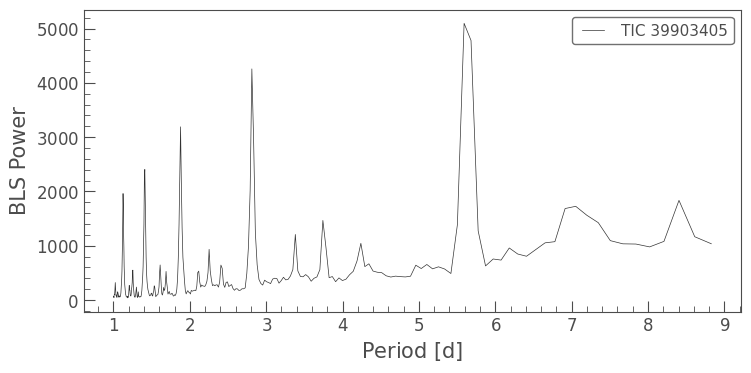

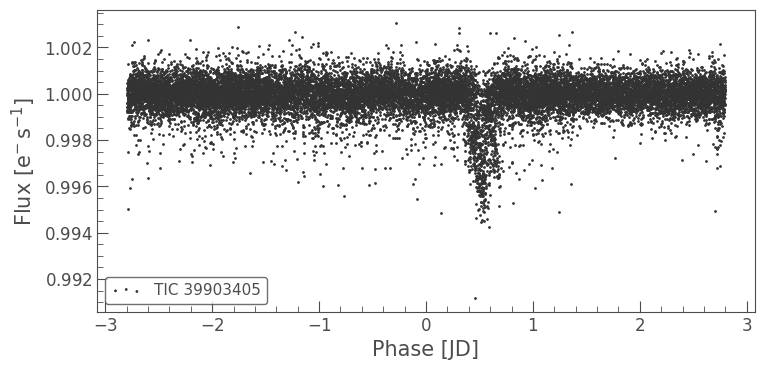

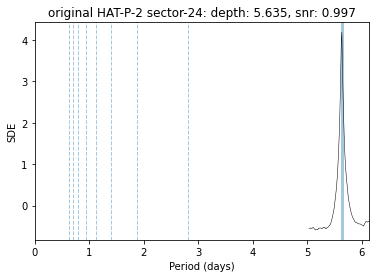

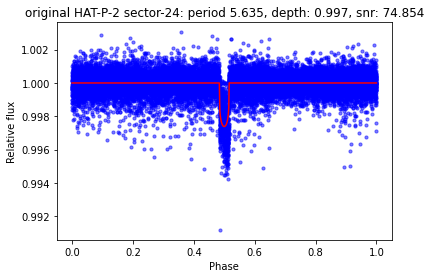

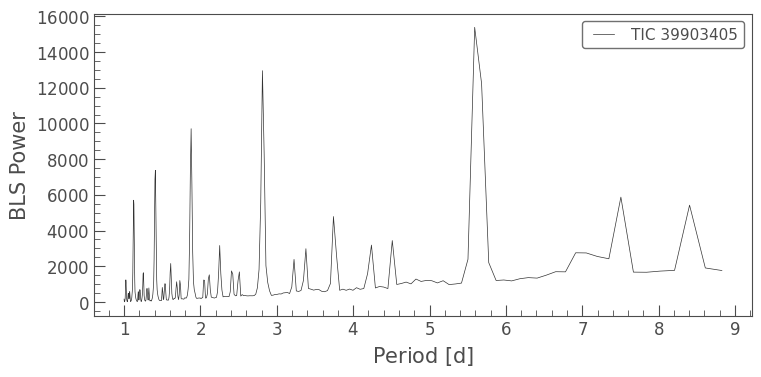

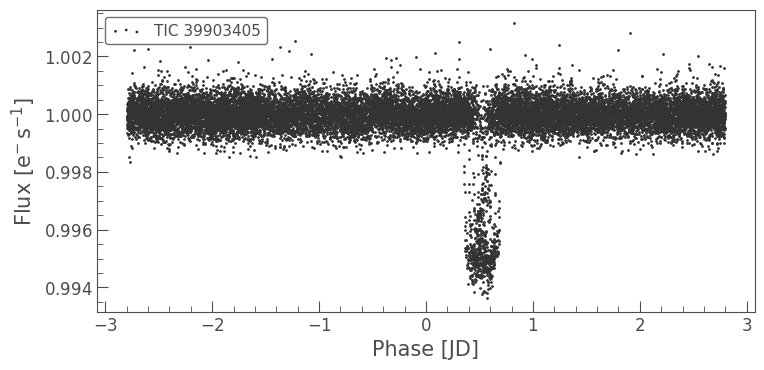

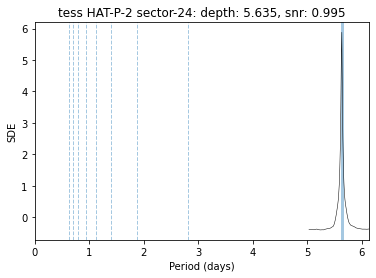

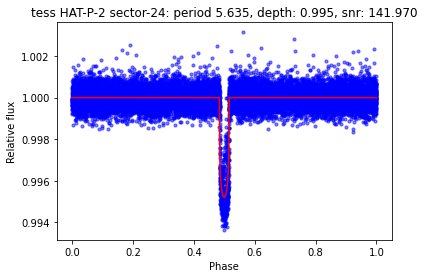

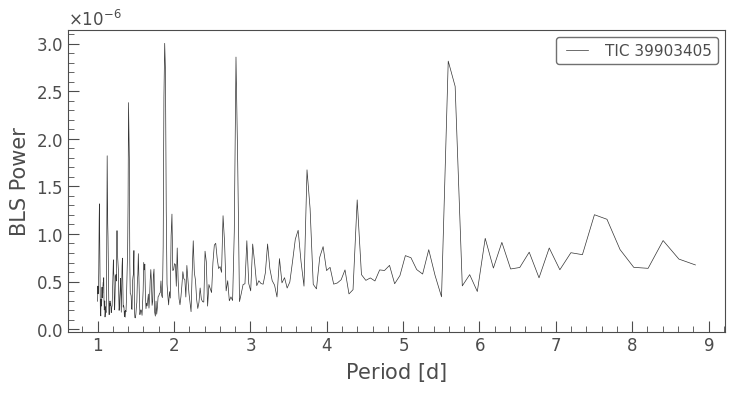

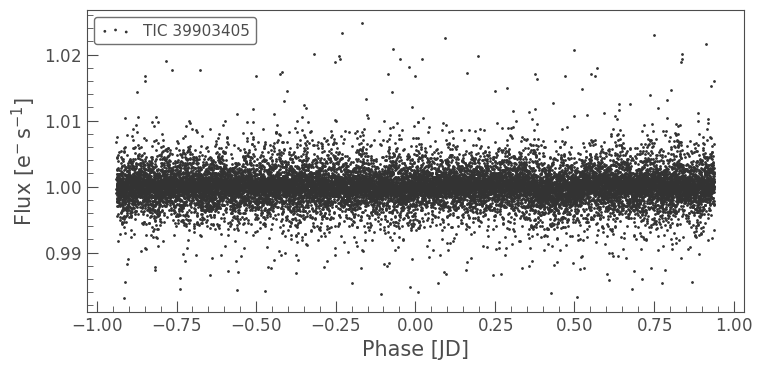

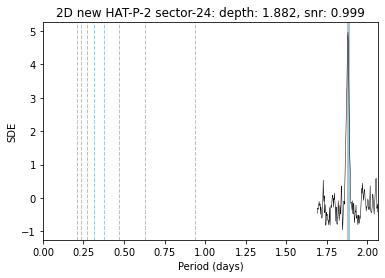

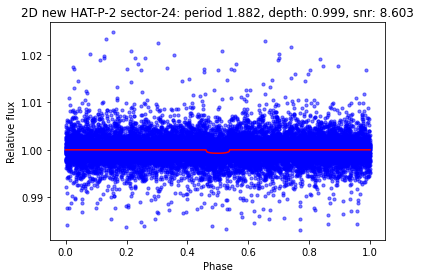

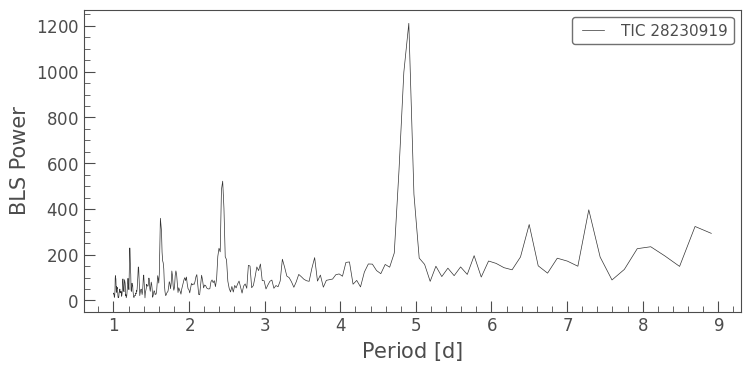

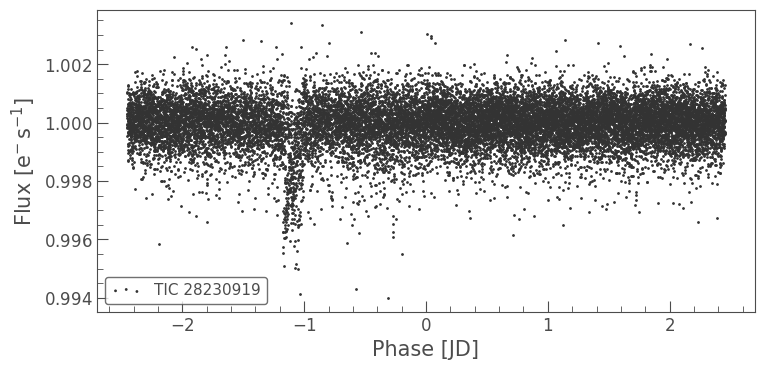

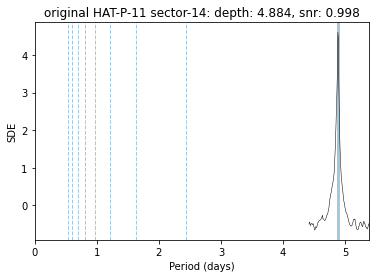

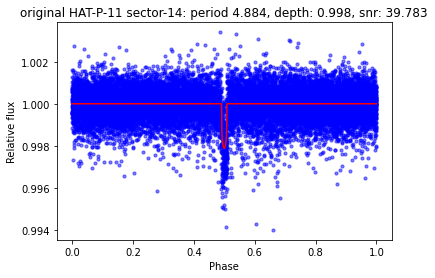

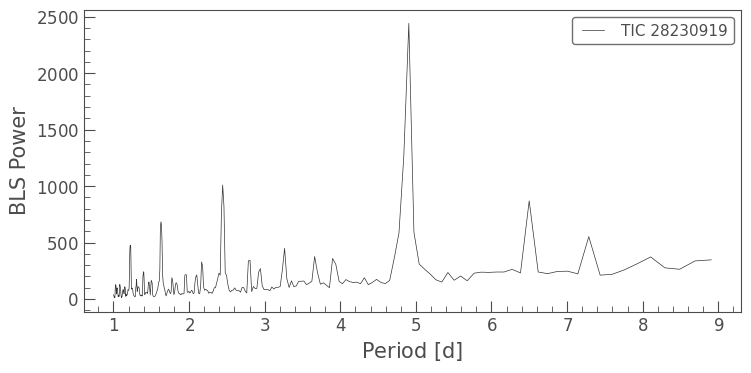

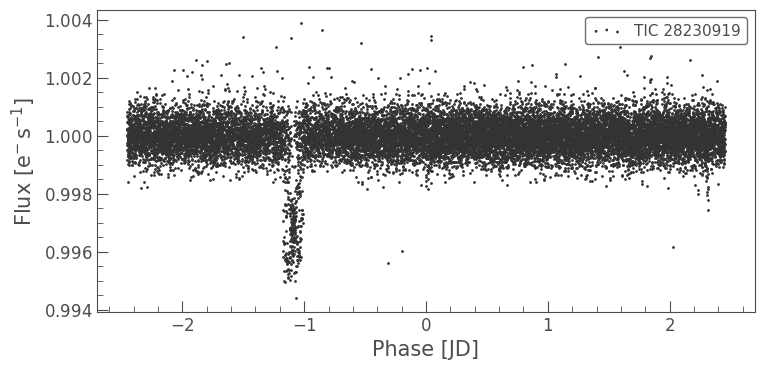

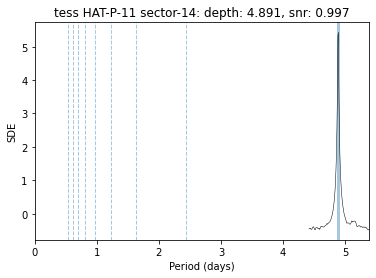

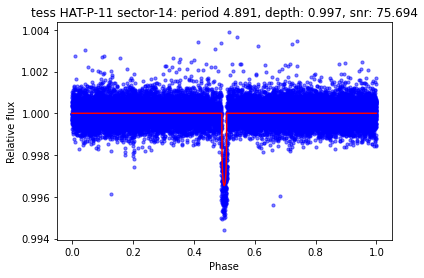

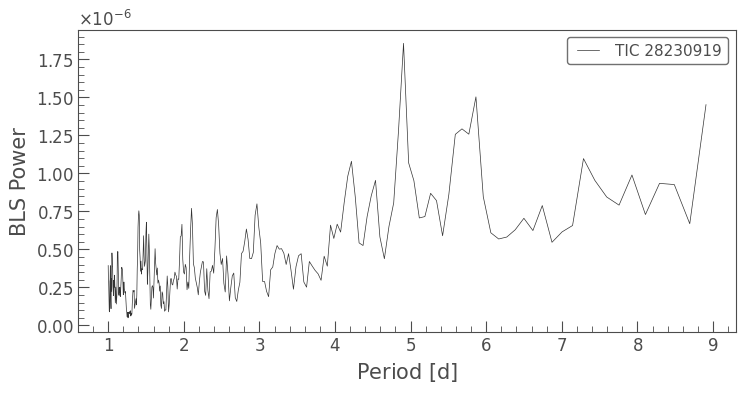

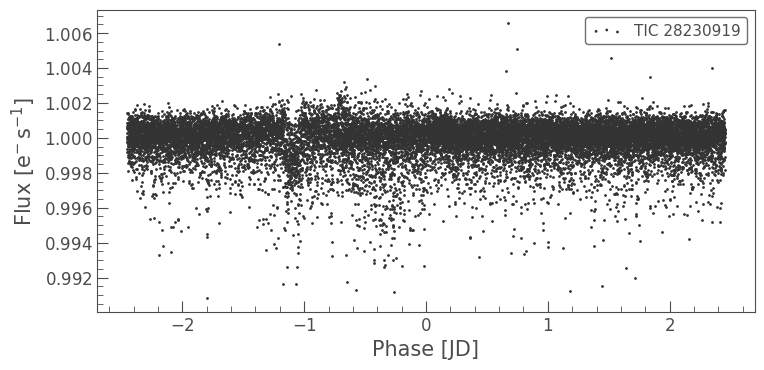

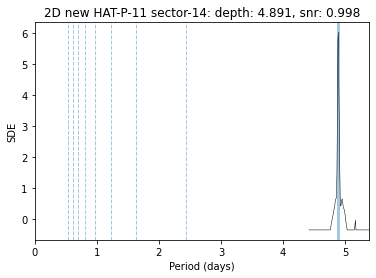

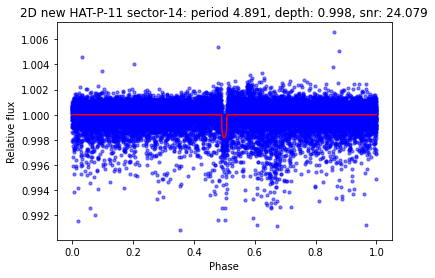

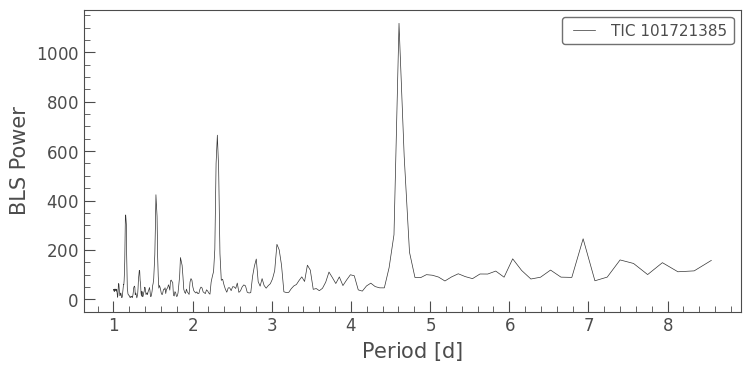

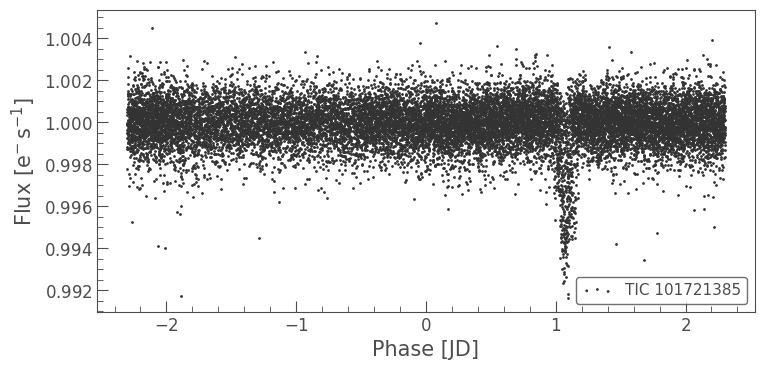

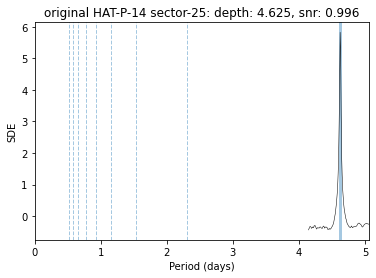

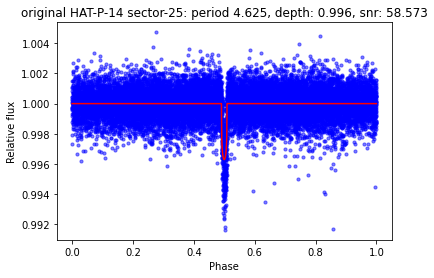

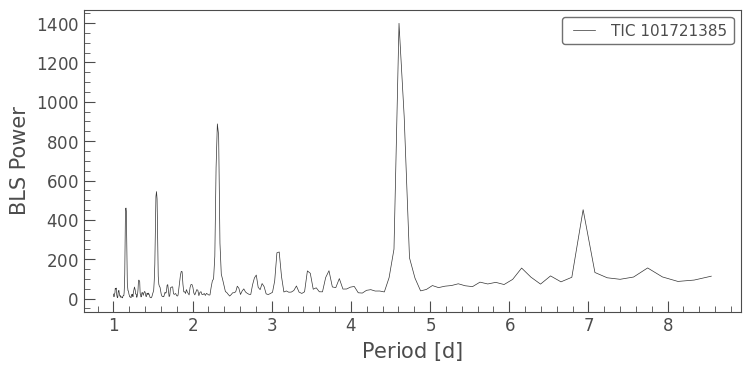

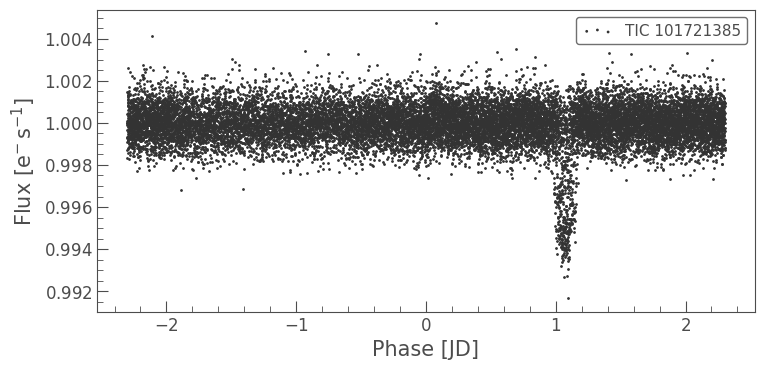

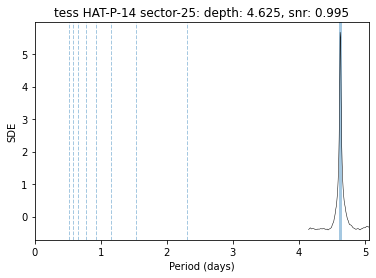

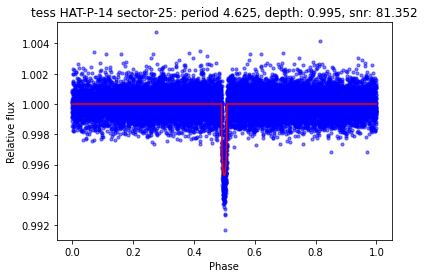

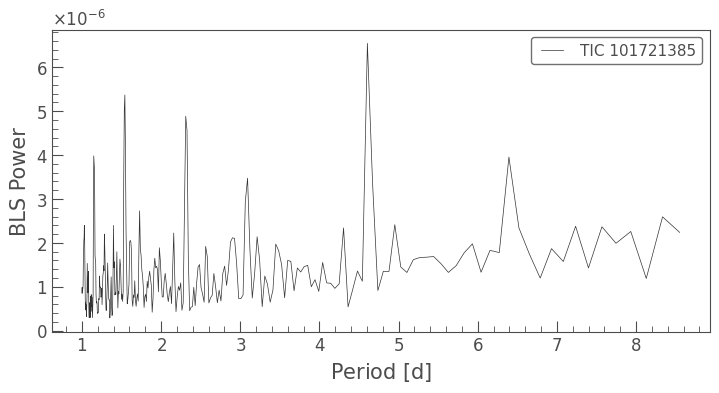

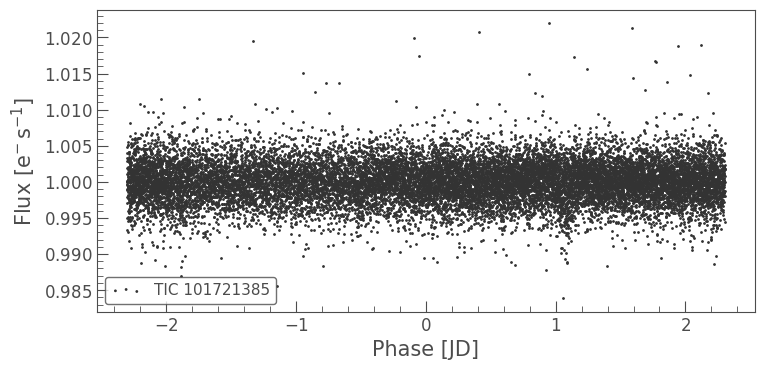

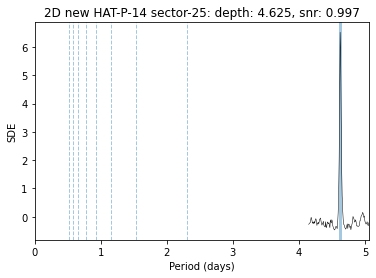

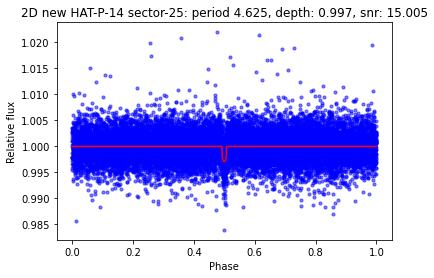

In [51]:
#test part2 model
test_2D(model_part2)

### Test model trained with 30 lightcurves to compare with part3

appended HAT-P-2, sector=24
appended HAT-P-11, sector=14
appended HAT-P-14, sector=25
finished downloading test dataset
old noisy
5.591387655656453
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18217 data points, 119 periods from 5.033 to 6.141 days
Using all 2 CPU threads


100%|██████████| 119/119 periods | 00:07<00:00


Results for original HAT-P-2 sector-24
Period 5.63544 d
5 transit times in time series: ['1956.23520', '1961.87064', '1967.50608', '1973.14152', '1978.77695']
Transit depth 0.99739
Transit duration (days) 0.17767
SNR 74.85421210246285
chi2 13584.96060195475
CDPP 281.80567357131827 ppm
Tess
5.591387655656453
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18217 data points, 119 periods from 5.033 to 6.141 days
Using all 2 CPU threads


100%|██████████| 119/119 periods | 00:06<00:00


Results for tess HAT-P-2 sector-24
Period 5.63544 d
5 transit times in time series: ['1956.23322', '1961.86866', '1967.50410', '1973.13954', '1978.77497']
Transit depth 0.99520
Transit duration (days) 0.17767
SNR 141.97002053311206
chi2 4970.375734880969
CDPP 133.4130604469745 ppm
2.811969887145969
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 28 durations
Searching 18217 data points, 149 periods from 2.533 to 3.089 days
Using all 2 CPU threads


100%|██████████| 149/149 periods | 00:08<00:00


Results for 2D new HAT-P-2 sector-24
Period 2.81934 d
10 transit times in time series: ['1956.22816', '1959.04750', '1961.86685', '1964.68619', '1967.50554', '1970.32488', '1973.14423', '1975.96357', '1978.78291', '1981.60226']
Transit depth 0.99758
Transit duration (days) 0.16994
SNR 13.291055448707555
chi2 18072.85764564576
CDPP 1295.5653037415689 ppm
old noisy
4.906519489266026
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18424 data points, 126 periods from 4.418 to 5.391 days
Using all 2 CPU threads


100%|██████████| 126/126 periods | 00:07<00:00


Searching for best T0 for period 4.88363 days


100%|██████████| 6161/6161 [00:02<00:00, 2101.10it/s]


Results for original HAT-P-11 sector-14
Period 4.88363 d
5 transit times in time series: ['1687.21692', '1692.10055', '1696.98418', '1701.86781', '1706.75143']
Transit depth 0.99788
Transit duration (days) 0.08312
SNR 39.783440666891394
chi2 16865.490031358288
CDPP 224.99607989783468 ppm
Tess
4.906519489266026
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18424 data points, 126 periods from 4.418 to 5.391 days
Using all 2 CPU threads


100%|██████████| 126/126 periods | 00:06<00:00


Searching for best T0 for period 4.89141 days


100%|██████████| 6773/6773 [00:03<00:00, 2037.17it/s]


Results for tess HAT-P-11 sector-14
Period 4.89141 d
5 transit times in time series: ['1687.19864', '1692.09005', '1696.98147', '1701.87288', '1706.76429']
Transit depth 0.99654
Transit duration (days) 0.07557
SNR 75.69409340165893
chi2 13070.868596551592
CDPP 170.626614635056 ppm


/usr/local/lib/python3.7/dist-packages/lightkurve/periodogram.py:364: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/lightkurve/lightcurve.py:1774: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


6.870364261367714
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18424 data points, 113 periods from 6.189 to 7.555 days
Using all 2 CPU threads


100%|██████████| 113/113 periods | 00:07<00:00


Results for 2D new HAT-P-11 sector-14
Period 6.90023 d
4 transit times in time series: ['1689.39555', '1696.29578', '1703.19600', '1710.09623']
Transit depth 0.99709
Transit duration (days) 0.19562
SNR 26.43279349408477
chi2 18049.46772598027
CDPP 659.2630302514495 ppm


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


old noisy
4.6065820396818875


/usr/local/lib/python3.7/dist-packages/lightkurve/periodogram.py:364: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/lightkurve/lightcurve.py:1774: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 17246 data points, 124 periods from 4.146 to 5.067 days
Using all 2 CPU threads


100%|██████████| 124/124 periods | 00:07<00:00


Results for original HAT-P-14 sector-25
Period 4.62463 d
6 transit times in time series: ['1984.66107', '1989.28570', '1993.91034', '1998.53497', '2003.15960', '2007.78424']
Transit depth 0.99630
Transit duration (days) 0.08176
SNR 58.57264557098471
chi2 14171.319687389081
CDPP 388.3976478866935 ppm
Tess


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/lightkurve/periodogram.py:364: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_w

4.6065820396818875
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 17246 data points, 124 periods from 4.146 to 5.067 days
Using all 2 CPU threads


100%|██████████| 124/124 periods | 00:06<00:00


Searching for best T0 for period 4.62463 days


100%|██████████| 5372/5372 [00:02<00:00, 2237.34it/s]


Results for tess HAT-P-14 sector-25
Period 4.62463 d
6 transit times in time series: ['1984.66022', '1989.28485', '1993.90949', '1998.53412', '2003.15875', '2007.78338']
Transit depth 0.99528
Transit duration (days) 0.07433
SNR 81.3520023006259
chi2 11895.219606787115
CDPP 350.84197572311945 ppm


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/lightkurve/periodogram.py:364: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_w

1.5432342471559652
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 23 durations
Searching 17246 data points, 177 periods from 1.39 to 1.696 days
Using all 2 CPU threads


100%|██████████| 177/177 periods | 00:07<00:00


Results for 2D new HAT-P-14 sector-25
Period 1.54346 d
16 transit times in time series: ['1984.64772', '1986.19118', '1987.73464', '1989.27811', '1990.82157', '1992.36504', '1993.90850', '1995.45196', '1996.99543', '1998.53889', '2000.08236', '2001.62582', '2003.16928', '2004.71275', '2006.25621', '2007.79967']
Transit depth 0.99700
Transit duration (days) 0.06995
SNR 15.270924096344439
chi2 17029.75237033372
CDPP 1381.4226442927077 ppm


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


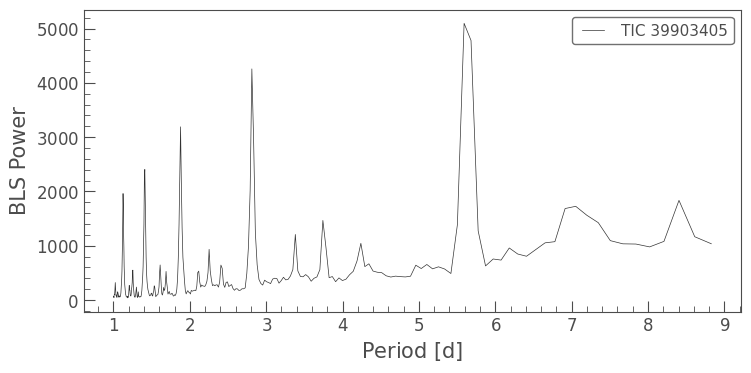

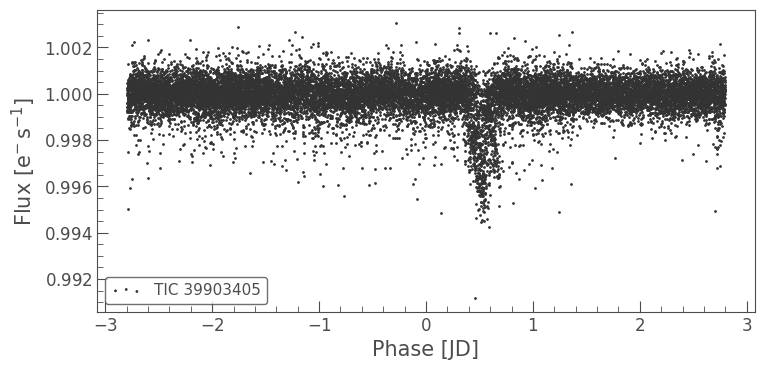

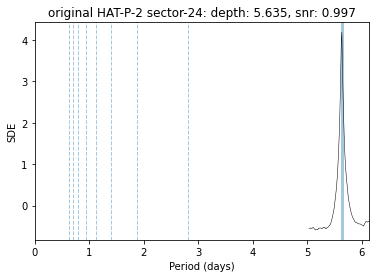

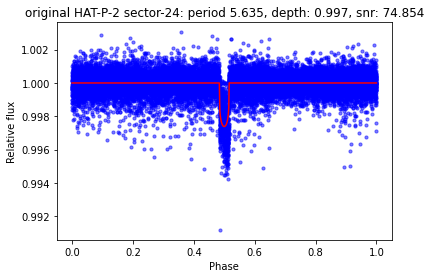

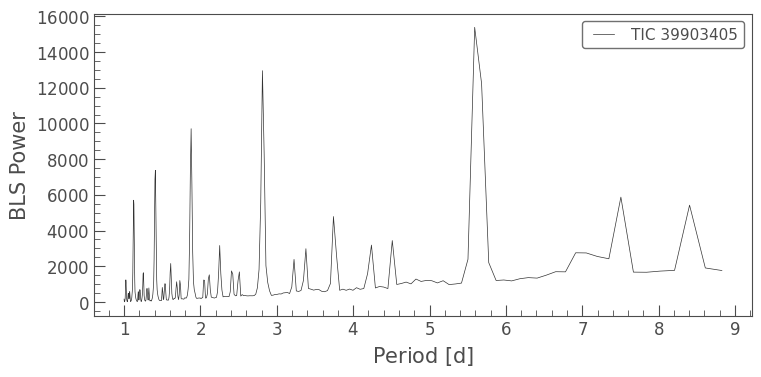

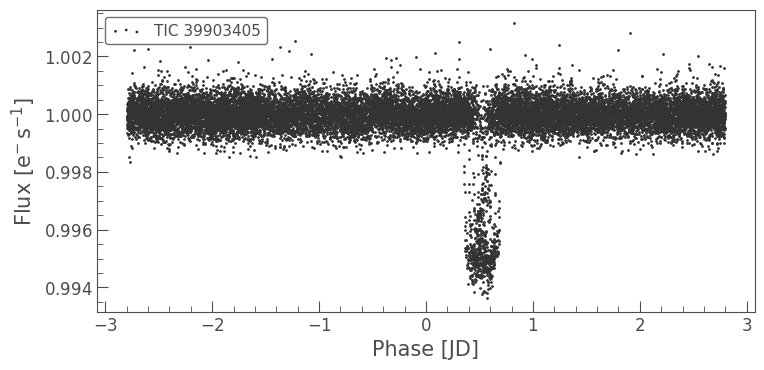

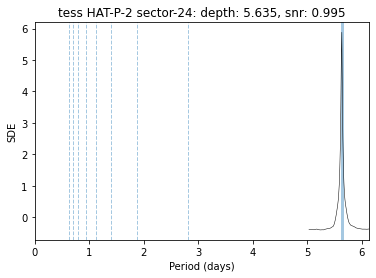

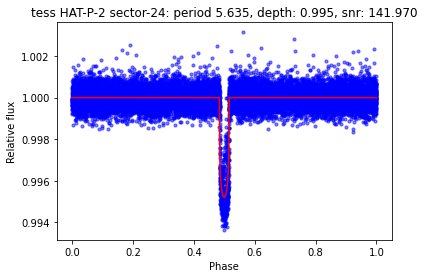

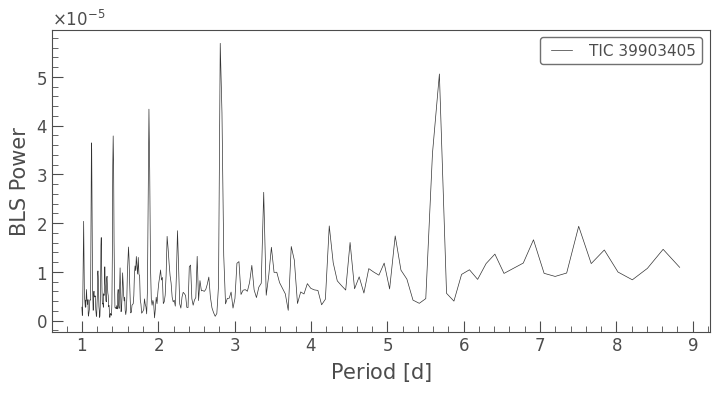

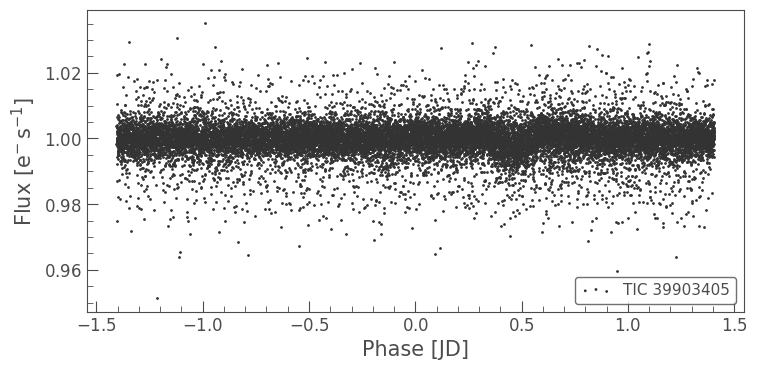

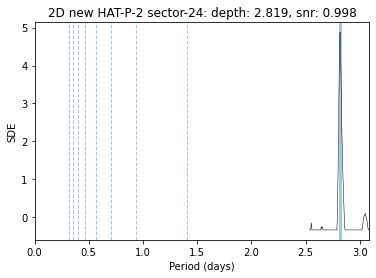

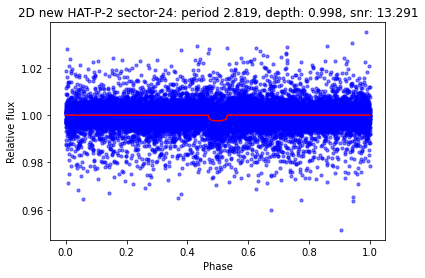

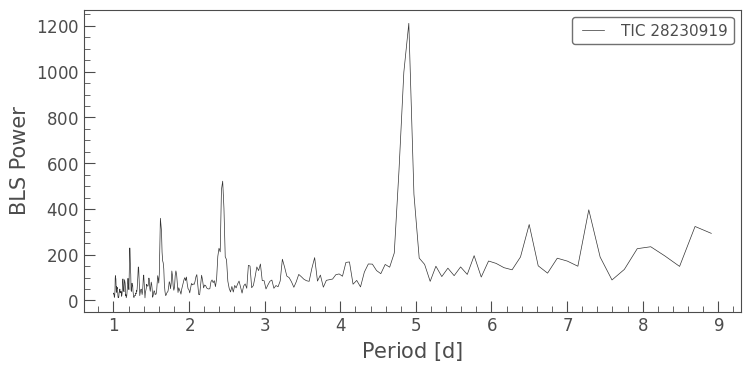

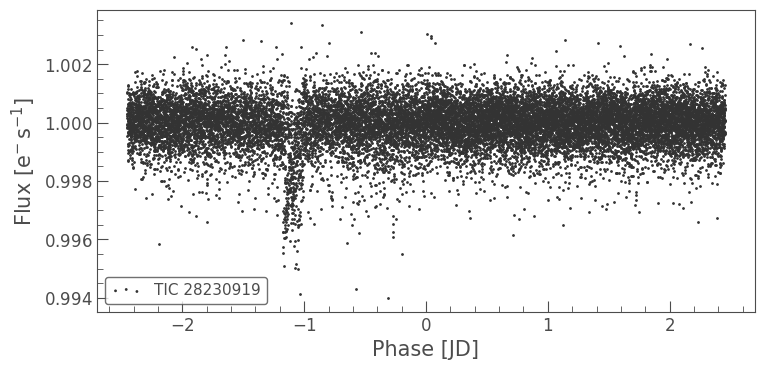

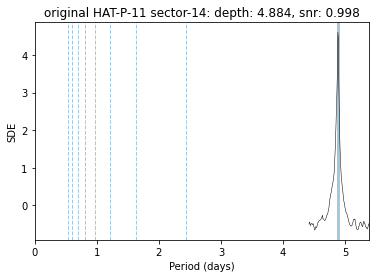

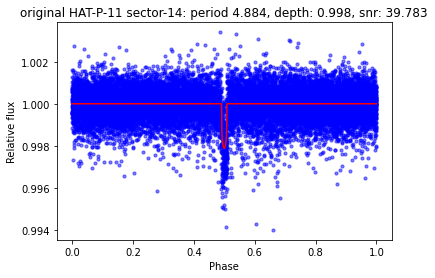

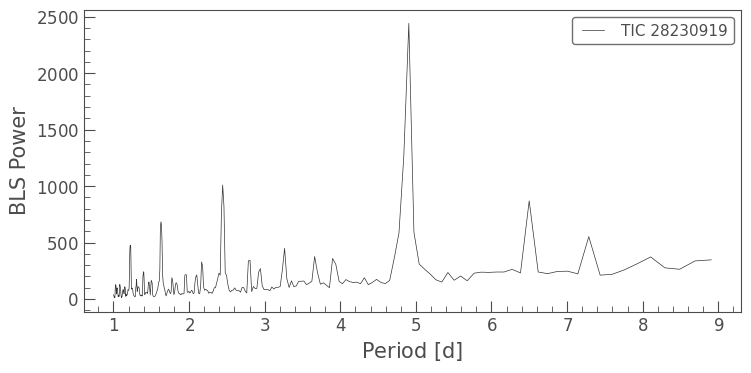

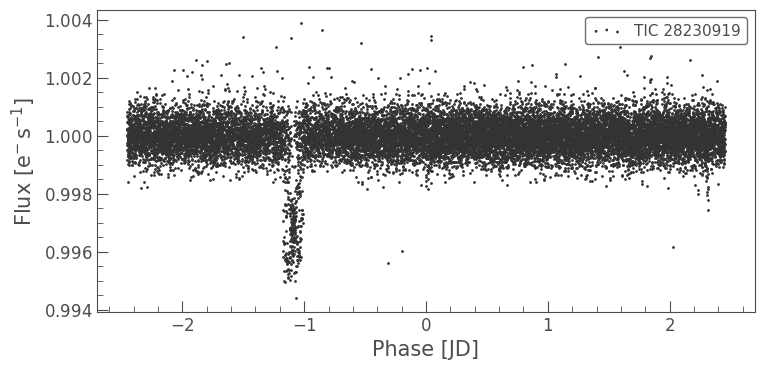

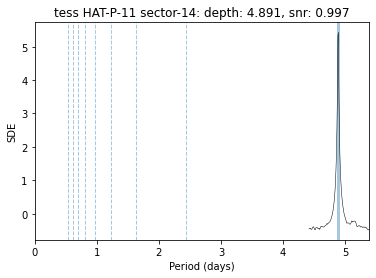

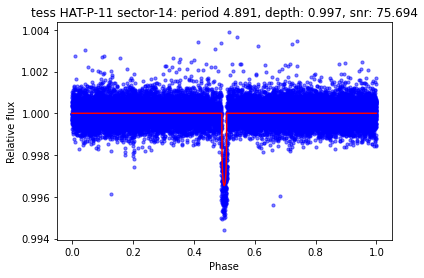

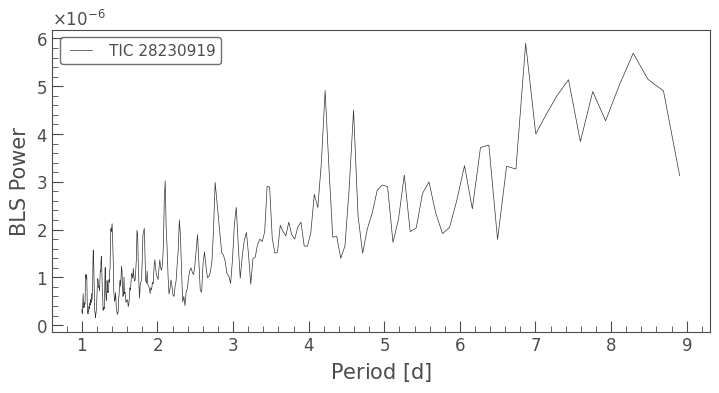

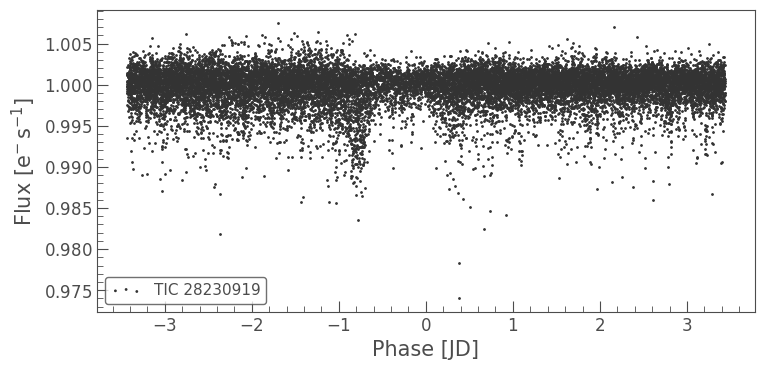

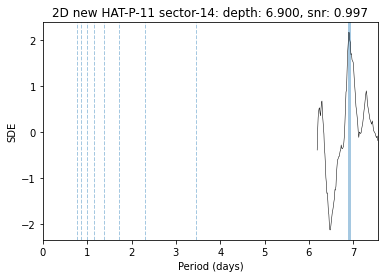

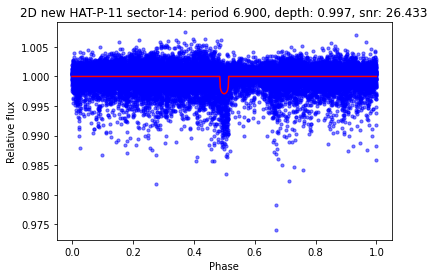

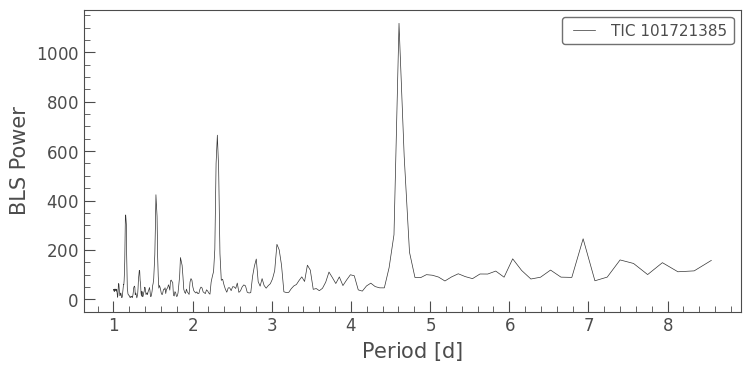

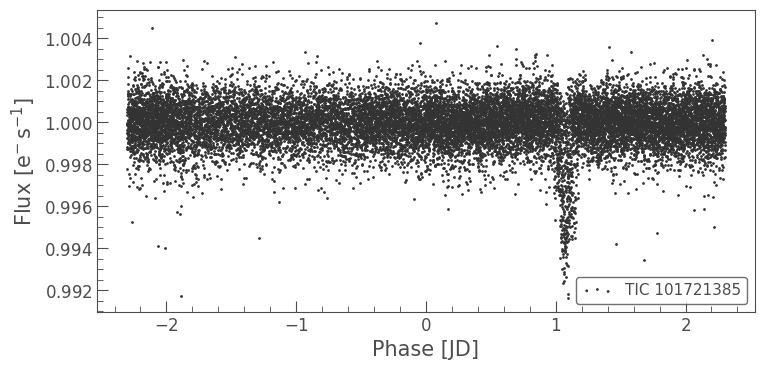

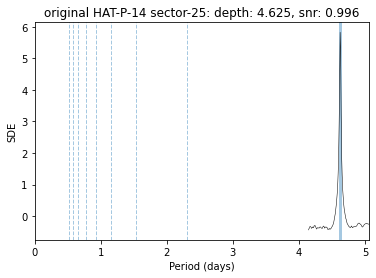

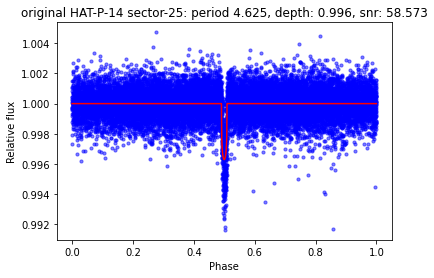

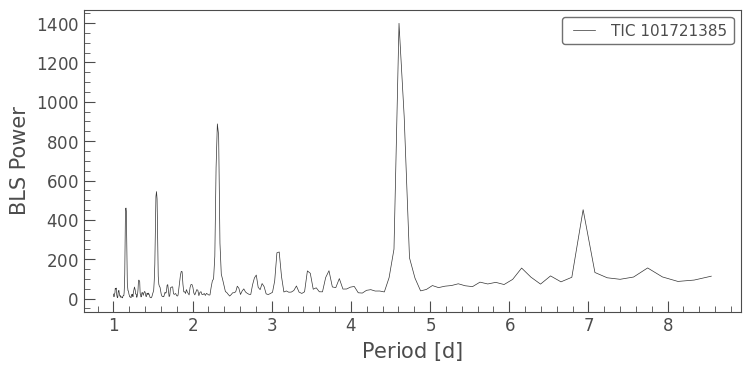

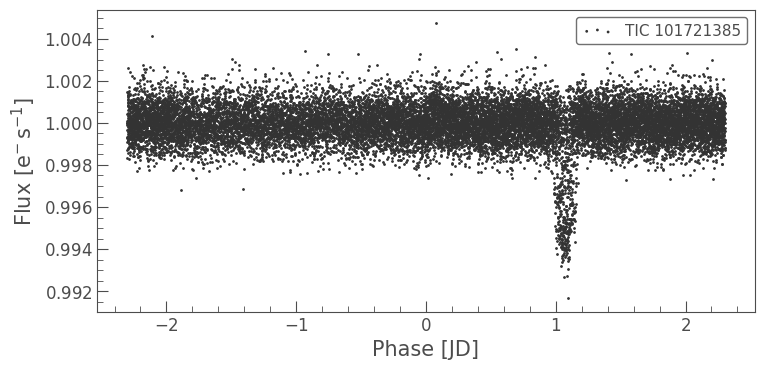

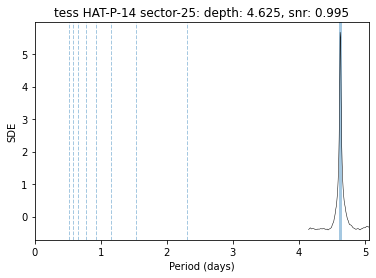

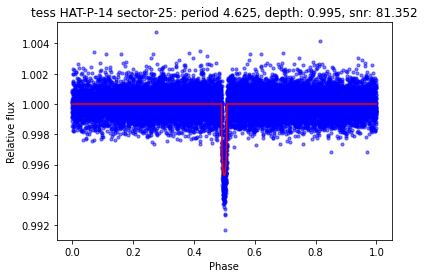

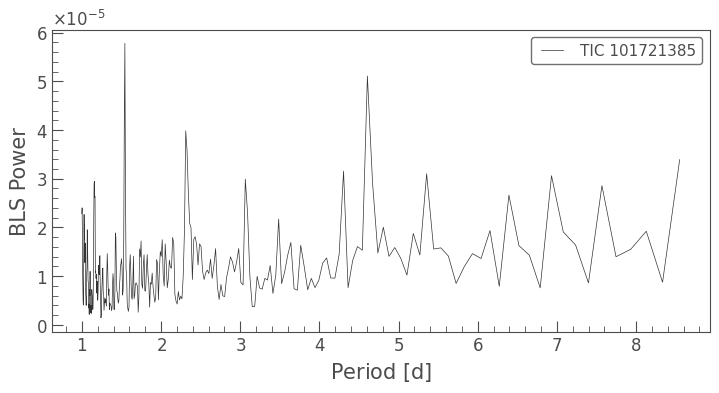

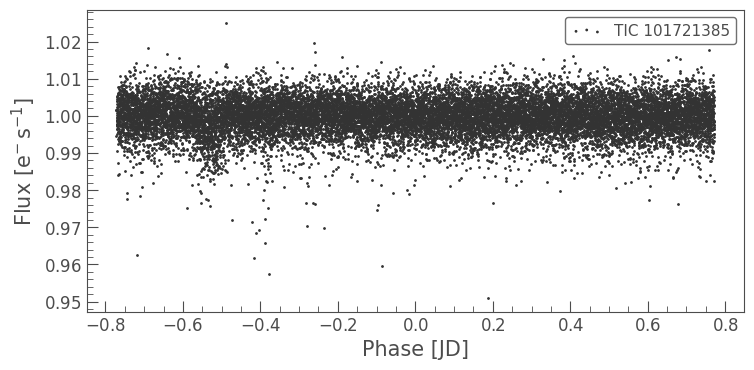

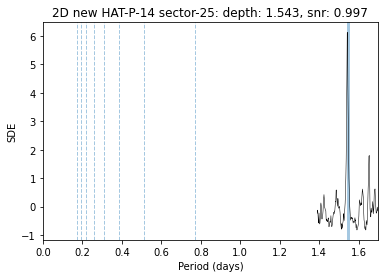

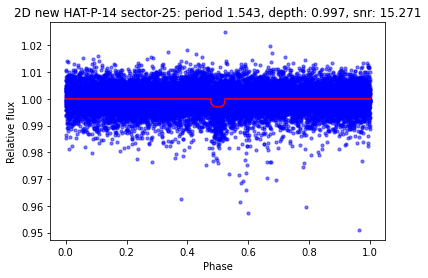

In [52]:
#test the model trained with 30 lightcurves
test_2D(model_30)

# Part 3 1D Autoencoder

In [53]:
WINDOW_SIZE = 2048
class SEncoder(tf.keras.layers.Layer):
    # TODO 
    def __init__(self):
       super(SEncoder, self).__init__()     
       self.encoder_conv_1 = tf.keras.layers.Conv1D(
        filters=10,
        kernel_size=3,
        strides=2,
        padding="same",
        activation=tf.keras.layers.LeakyReLU(alpha=0.2),
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
        )
       self.encoder_maxpool1 = tf.keras.layers.MaxPool1D()

       self.encoder_conv_2 = tf.keras.layers.Conv1D(
            filters=10,
            kernel_size=3,
            strides=2,
            padding="same",
            activation=tf.keras.layers.LeakyReLU(alpha=0.2),
            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
            bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
        )
       self.encoder_maxpool2 = tf.keras.layers.MaxPool1D()

       self.encoder_conv_3 = tf.keras.layers.Conv1D(
        filters=1,
        kernel_size=3,
        strides=2,
        padding="same",
        activation=tf.keras.layers.LeakyReLU(alpha=0.2),
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
        )
    
    @tf.function
    def call(self, images):
        conv_layer1 = self.encoder_conv_1(images)
        max_pool1 = self.encoder_maxpool1(conv_layer1)
        conv_layer2 = self.encoder_conv_2(max_pool1)
        max_pool2 = self.encoder_maxpool1(conv_layer2)
        conv_layer3 = self.encoder_conv_3(max_pool2)
        return conv_layer3


In [54]:
class SDecoder(tf.keras.layers.Layer):
    def __init__(self):
        super(SDecoder, self).__init__()
       
        self.decoder_deconv_1 = tf.keras.layers.Conv1DTranspose(10, 3, 2, kernel_initializer=tf.keras.initializers.RandomNormal(
                                                                    stddev=0.1),
                                                                bias_initializer=tf.keras.initializers.RandomNormal(
                                                                    stddev=0.1),
                                                                activation=tf.keras.layers.LeakyReLU(alpha=0.2), padding='same')
     
        self.decoder_deconv_2 = tf.keras.layers.Conv1DTranspose(10, 3, 2, kernel_initializer=tf.keras.initializers.RandomNormal(
                                                                    stddev=0.1),
                                                                bias_initializer=tf.keras.initializers.RandomNormal(
                                                                    stddev=0.1),
                                                                activation=tf.keras.layers.LeakyReLU(alpha=0.2), padding='same')
     
        self.decoder_deconv_3 = tf.keras.layers.Conv1DTranspose(10, 3, 2,
                                                                padding='same',
                                                                kernel_initializer=tf.keras.initializers.RandomNormal(
                                                                    stddev=0.1),
                                                                bias_initializer=tf.keras.initializers.RandomNormal(
                                                                    stddev=0.1),
                                                                activation=tf.keras.layers.LeakyReLU(alpha=0.2))
        self.decoder_deconv_4 = tf.keras.layers.Conv1DTranspose(10, 3, 2,
                                                                padding='same',
                                                                kernel_initializer=tf.keras.initializers.RandomNormal(
                                                                    stddev=0.1),
                                                                bias_initializer=tf.keras.initializers.RandomNormal(
                                                                    stddev=0.1),
                                                                activation=tf.keras.layers.LeakyReLU(alpha=0.2))
        self.decoder_deconv_5 = tf.keras.layers.Conv1DTranspose(1, 3, 2,
                                                                padding='same',
                                                                kernel_initializer=tf.keras.initializers.RandomNormal(
                                                                    stddev=0.1),
                                                                bias_initializer=tf.keras.initializers.RandomNormal(
                                                                    stddev=0.1),
                                                                activation=tf.keras.layers.LeakyReLU(alpha=0.2))
    
  
    @tf.function
    def call(self, encoder_output):      
        deconv1 = self.decoder_deconv_1(encoder_output)
        deconv2 = self.decoder_deconv_2(deconv1)
        deconv3 = self.decoder_deconv_3(deconv2)
        deconv4 = self.decoder_deconv_4(deconv3)
        deconv5 = self.decoder_deconv_5(deconv4)
        return deconv5

In [55]:
class SAutoEncoder(tf.keras.Model):
    def __init__(self):
        super(SAutoEncoder, self).__init__()
        self.encoder = SEncoder()
        self.decoder = SDecoder()
    
    @tf.function
    def call(self, images):
       return self.decoder(self.encoder(images))
    
    @tf.function
    def loss_function(self, encoded, originals):
      encoded = tf.dtypes.cast(encoded, tf.float32)
      originals = tf.dtypes.cast(originals, tf.float32)
      return tf.reduce_sum((encoded - originals) ** 2)

## 1D Train Loop

In [56]:
def train(model, optimizer, images):
  images = tf.reshape(images, [-1, WINDOW_SIZE, 1])
  shuffled = tf.random.shuffle(images)
  with tf.GradientTape() as tape:
    decoded = model(shuffled, training=True)
    loss = model.loss_function(decoded,shuffled)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

##1D Total Loss

In [57]:
def total_loss(model, images):
  sum_loss = 0
  images = tf.reshape(images, [-1, WINDOW_SIZE, 1])
  predictions = model(images)
  sum_loss += model.loss_function(predictions, images).numpy()
  return sum_loss

##Training 1D Autoencoder with 30 lightcurves

### Getting windows of training data

In [58]:
#Getting training set
x_train_pixelfiles, x_train_lightcurves, tess_lightcurves = get_training_dataset()

TOI-163
HD_219666
TOI-640
TOI-157
LHS_1815
TOI-1235
TOI-251
LP_714-47
TOI-122
GJ_1252
TOI-172
TOI-169
TOI-674
TOI-954
TOI-1685
TOI-837
TOI-519
TOI-1728
TOI-540
TOI-824
LTT_9779
HIP_67522
LHS_1478
TOI-150
LHS_3844
TOI-132
L_168-9
TOI-905
HD_2685


TOI-269
TOI-237


In [72]:
samples_per_day = 1 + 60 * 24 // 2
#prepare windowed flux timeseries
#change pad_constant to 1 for higher srn but larger loss
def prepare_data(lightcurves, pad_constant=0):
  x_lcs = []
  for i in range(len(lightcurves)):   
    #get timeseries of 1d flux to denoise   
    x_lc = lightcurves[i]   
    x_lc = x_lc.flatten(samples_per_day).flux
    #pad noise to reshape into window size
    x_lc_pad = WINDOW_SIZE - len(x_lc) % WINDOW_SIZE
    x_lc = tf.pad(x_lc,[[0,x_lc_pad]],constant_values=pad_constant)
    #normalize
    x_lc = (x_lc - np.min(x_lc,axis=0))/(np.max(x_lc,axis=0)-np.min(x_lc,axis=0))
    x_lc = tf.reshape(x_lc, (-1, WINDOW_SIZE,1)) 
    x_lcs.append(x_lc)
  x_lcs = np.vstack(x_lcs)
  return tf.random.shuffle(x_lcs)

In [73]:
#prepare
data = prepare_data(x_train_lightcurves)
x_trains = data[:int(data.shape[0]* 0.9),:,:]
x_tests = data[int(data.shape[0] * 0.9):,:,:]

print("x_trains",x_trains.shape)
print("x_tests",x_tests.shape)

x_trains (238, 2048, 1)
x_tests (27, 2048, 1)


###Training

In [74]:
samples_per_day = 1 + 60 * 24 // 2
EPOCHES = 25
BATCH_SIZE = 30

smodel = SAutoEncoder()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

for i in range(EPOCHES):
  for j in range(0, x_trains.shape[0], BATCH_SIZE):     
    train(smodel, optimizer, x_trains[j:j+BATCH_SIZE,:,:])
  print("Epoch: ", i)
  sum_loss = total_loss(smodel, x_tests)
  print("Total Loss: {0}".format(sum_loss))

Epoch:  0
Total Loss: 24624.55859375
Epoch:  1
Total Loss: 11057.28515625
Epoch:  2
Total Loss: 4915.0029296875
Epoch:  3
Total Loss: 4536.677734375
Epoch:  4
Total Loss: 4320.599609375
Epoch:  5
Total Loss: 4132.19189453125
Epoch:  6
Total Loss: 4060.28076171875
Epoch:  7
Total Loss: 2890.79150390625
Epoch:  8
Total Loss: 1461.0374755859375
Epoch:  9
Total Loss: 602.2291259765625
Epoch:  10
Total Loss: 480.7122802734375
Epoch:  11
Total Loss: 239.96975708007812
Epoch:  12
Total Loss: 109.38399505615234
Epoch:  13
Total Loss: 98.18922424316406
Epoch:  14
Total Loss: 94.76668548583984
Epoch:  15
Total Loss: 83.89227294921875
Epoch:  16
Total Loss: 78.61216735839844
Epoch:  17
Total Loss: 77.15763854980469
Epoch:  18
Total Loss: 71.01179504394531
Epoch:  19
Total Loss: 67.19420623779297
Epoch:  20
Total Loss: 64.08396911621094
Epoch:  21
Total Loss: 60.96091079711914
Epoch:  22
Total Loss: 58.498268127441406
Epoch:  23
Total Loss: 55.863983154296875
Epoch:  24
Total Loss: 53.919036865234

##Test 1D Autoencoder

appended HAT-P-2, sector=24
appended HAT-P-11, sector=14
appended HAT-P-14, sector=25
finished downloading test dataset
plotting old flux to denoise
5.591387655656453
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18217 data points, 119 periods from 5.033 to 6.141 days
Using all 2 CPU threads


100%|██████████| 119/119 periods | 00:07<00:00


Results for original HAT-P-2 sector-24
Period 5.63544 d
5 transit times in time series: ['1956.23520', '1961.87064', '1967.50608', '1973.14152', '1978.77695']
Transit depth 0.99739
Transit duration (days) 0.17767
SNR 74.85421210246285
chi2 13584.96060195475
CDPP 281.80567357131827 ppm
plotting new flux
5.681971452838236
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18217 data points, 119 periods from 5.116 to 6.249 days
Using all 2 CPU threads


100%|██████████| 119/119 periods | 00:07<00:00


Results for 1D new HAT-P-2 sector-24
Period 5.63544 d
5 transit times in time series: ['1956.23374', '1961.86917', '1967.50461', '1973.14005', '1978.77549']
Transit depth 0.79604
Transit duration (days) 0.21249
SNR 148.92196723861477
chi2 6710.431677812927
CDPP 3883.5371904084764 ppm
plotting tess model true flux
5.591387655656453
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18217 data points, 119 periods from 5.033 to 6.141 days
Using all 2 CPU threads


100%|██████████| 119/119 periods | 00:06<00:00


Results for tess HAT-P-2 sector-24
Period 5.63544 d
5 transit times in time series: ['1956.23322', '1961.86866', '1967.50410', '1973.13954', '1978.77497']
Transit depth 0.99520
Transit duration (days) 0.17767
SNR 141.97002053311206
chi2 4970.375734880969
CDPP 133.4130604469745 ppm
plotting old flux to denoise
4.906519489266026
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18424 data points, 126 periods from 4.418 to 5.391 days
Using all 2 CPU threads


100%|██████████| 126/126 periods | 00:07<00:00


Searching for best T0 for period 4.88363 days


100%|██████████| 6161/6161 [00:02<00:00, 2152.73it/s]


Results for original HAT-P-11 sector-14
Period 4.88363 d
5 transit times in time series: ['1687.21692', '1692.10055', '1696.98418', '1701.86781', '1706.75143']
Transit depth 0.99788
Transit duration (days) 0.08312
SNR 39.783440666891394
chi2 16865.490031358288
CDPP 224.99607989783468 ppm
plotting new flux
4.906519489266026
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18424 data points, 126 periods from 4.418 to 5.391 days
Using all 2 CPU threads


100%|██████████| 126/126 periods | 00:07<00:00


Results for 1D new HAT-P-11 sector-14
Period 4.88363 d
5 transit times in time series: ['1687.22238', '1692.10601', '1696.98964', '1701.87327', '1706.75690']
Transit depth 0.74801
Transit duration (days) 0.11064
SNR 117.739255046514
chi2 8438.124311230762
CDPP 5555.1421220788525 ppm
plotting tess model true flux


/usr/local/lib/python3.7/dist-packages/lightkurve/periodogram.py:364: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/lightkurve/lightcurve.py:1774: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


4.906519489266026
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 18424 data points, 126 periods from 4.418 to 5.391 days
Using all 2 CPU threads


100%|██████████| 126/126 periods | 00:06<00:00


Searching for best T0 for period 4.89141 days


100%|██████████| 6773/6773 [00:03<00:00, 2139.70it/s]


Results for tess HAT-P-11 sector-14
Period 4.89141 d
5 transit times in time series: ['1687.19864', '1692.09005', '1696.98147', '1701.87288', '1706.76429']
Transit depth 0.99654
Transit duration (days) 0.07557
SNR 75.69409340165893
chi2 13070.868596551592
CDPP 170.626614635056 ppm


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


plotting old flux to denoise
4.6065820396818875


/usr/local/lib/python3.7/dist-packages/lightkurve/periodogram.py:364: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/lightkurve/lightcurve.py:1774: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 17246 data points, 124 periods from 4.146 to 5.067 days
Using all 2 CPU threads


100%|██████████| 124/124 periods | 00:07<00:00


Results for original HAT-P-14 sector-25
Period 4.62463 d
6 transit times in time series: ['1984.66107', '1989.28570', '1993.91034', '1998.53497', '2003.15960', '2007.78424']
Transit depth 0.99630
Transit duration (days) 0.08176
SNR 58.57264557098471
chi2 14171.319687389081
CDPP 388.3976478866935 ppm
plotting new flux


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/lightkurve/periodogram.py:364: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_w

4.6065820396818875
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 17246 data points, 124 periods from 4.146 to 5.067 days
Using all 2 CPU threads


100%|██████████| 124/124 periods | 00:07<00:00


Results for 1D new HAT-P-14 sector-25
Period 4.62463 d
6 transit times in time series: ['1984.66314', '1989.28777', '1993.91241', '1998.53704', '2003.16167', '2007.78631']
Transit depth 0.71303
Transit duration (days) 0.10883
SNR 150.94749993134334
chi2 6378.7674937906795
CDPP 6041.541559667293 ppm
plotting tess model true flux


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/lightkurve/periodogram.py:364: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_w

4.6065820396818875
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 30 durations
Searching 17246 data points, 124 periods from 4.146 to 5.067 days
Using all 2 CPU threads


100%|██████████| 124/124 periods | 00:07<00:00


Searching for best T0 for period 4.62463 days


100%|██████████| 5372/5372 [00:02<00:00, 2163.81it/s]


Results for tess HAT-P-14 sector-25
Period 4.62463 d
6 transit times in time series: ['1984.66022', '1989.28485', '1993.90949', '1998.53412', '2003.15875', '2007.78338']
Transit depth 0.99528
Transit duration (days) 0.07433
SNR 81.3520023006259
chi2 11895.219606787115
CDPP 350.84197572311945 ppm


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


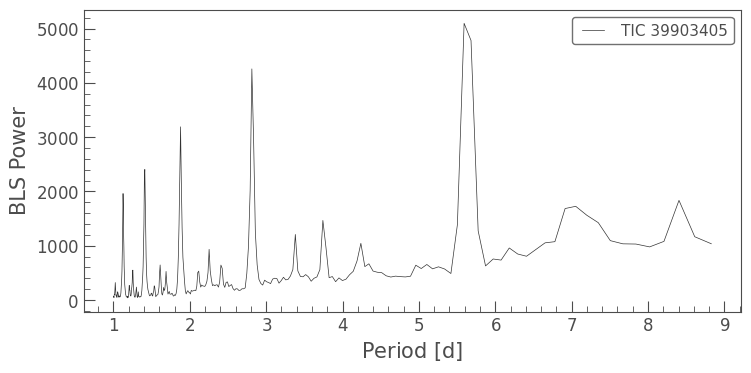

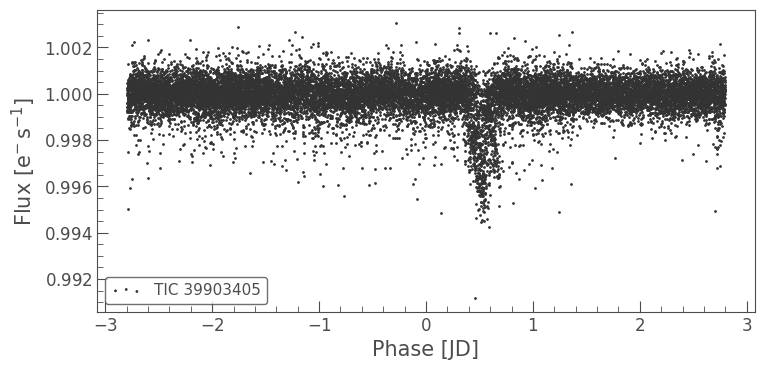

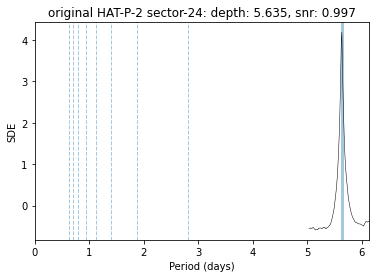

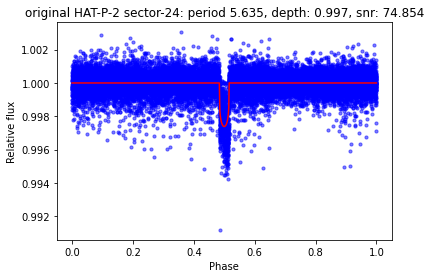

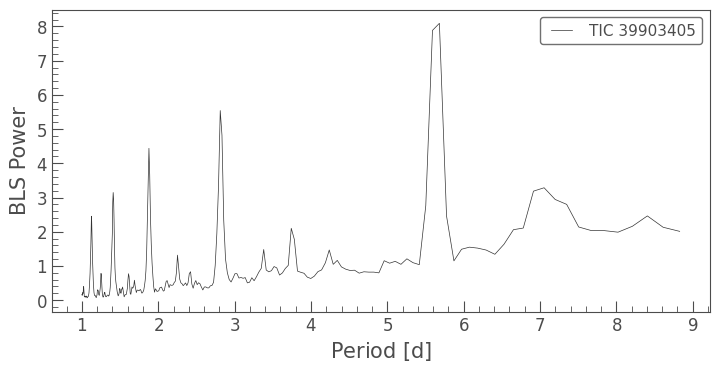

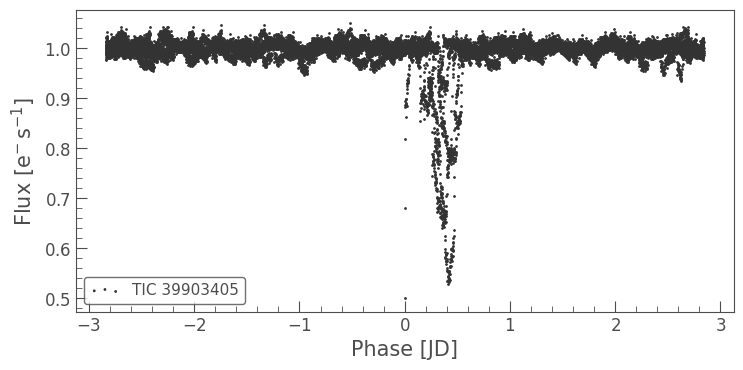

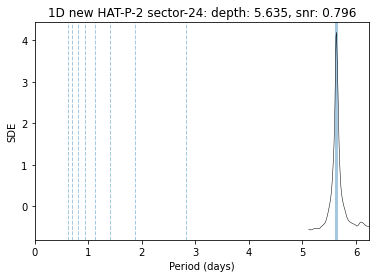

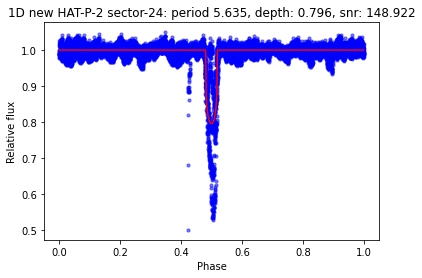

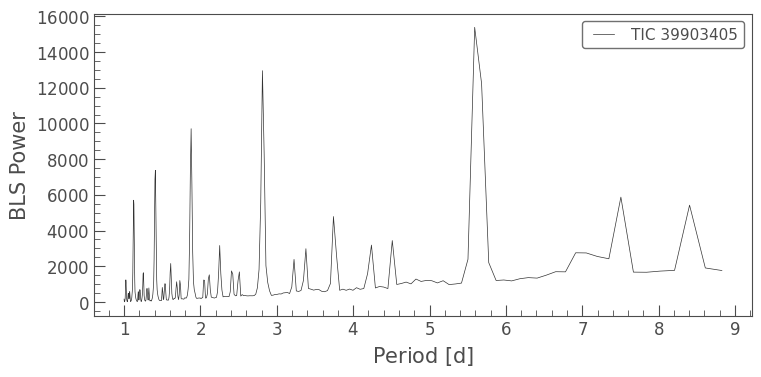

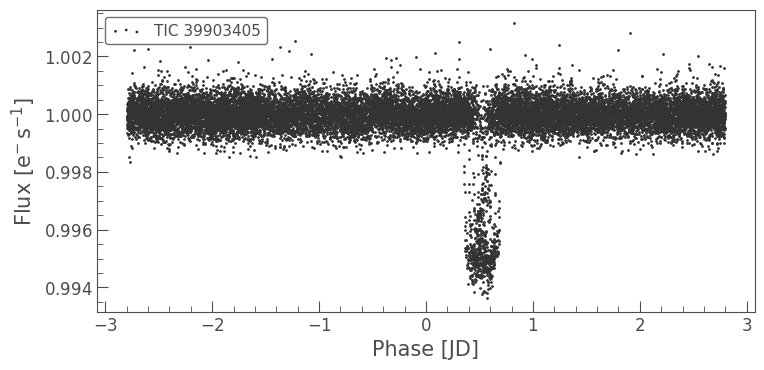

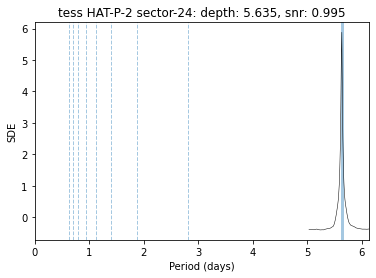

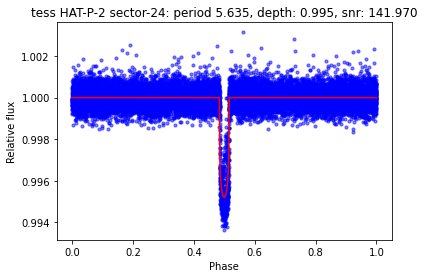

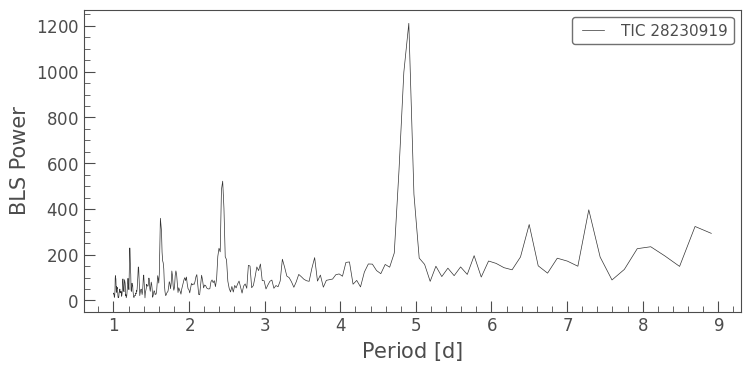

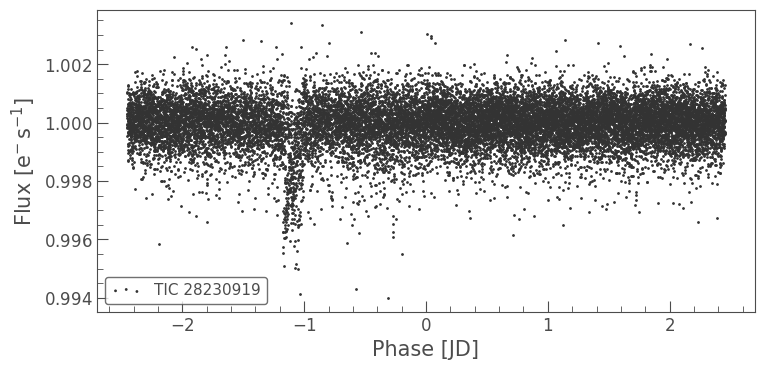

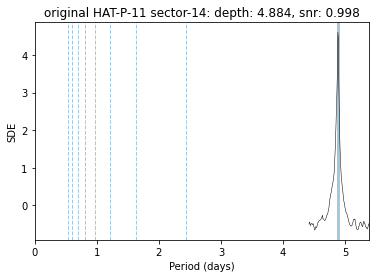

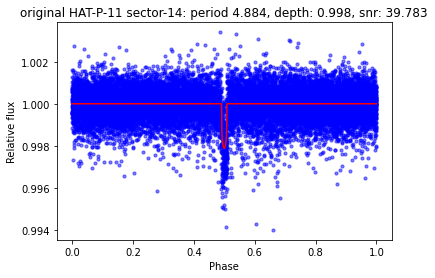

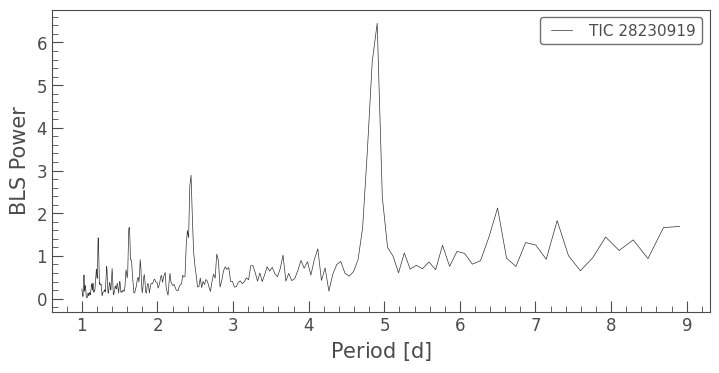

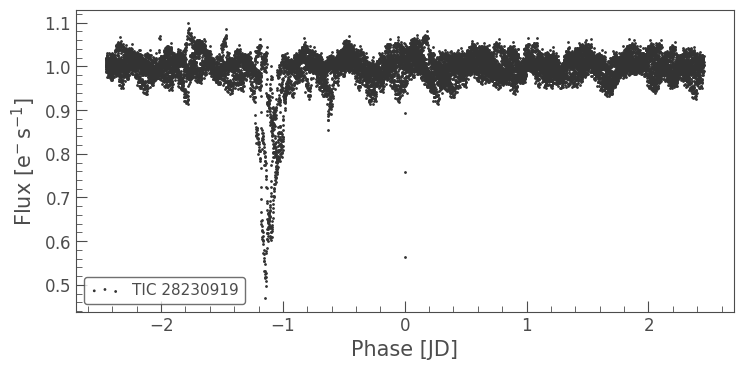

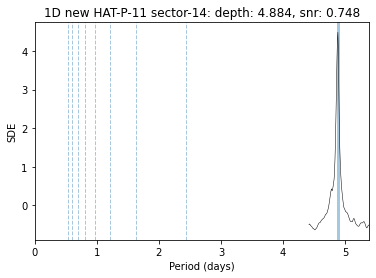

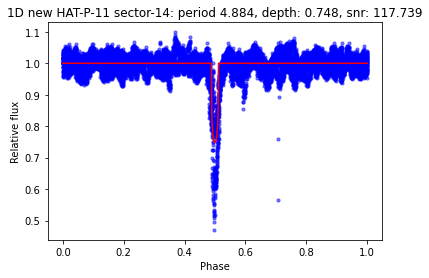

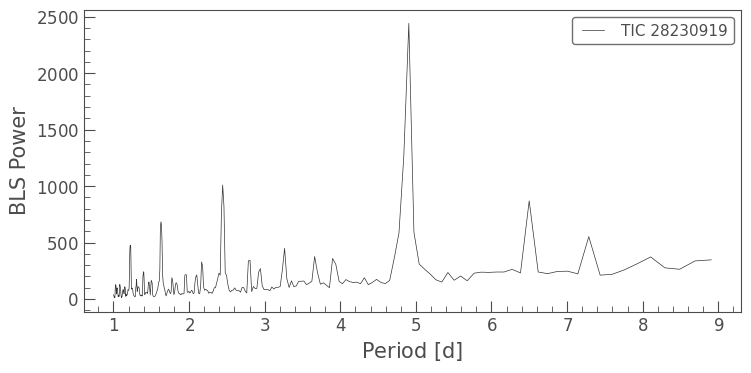

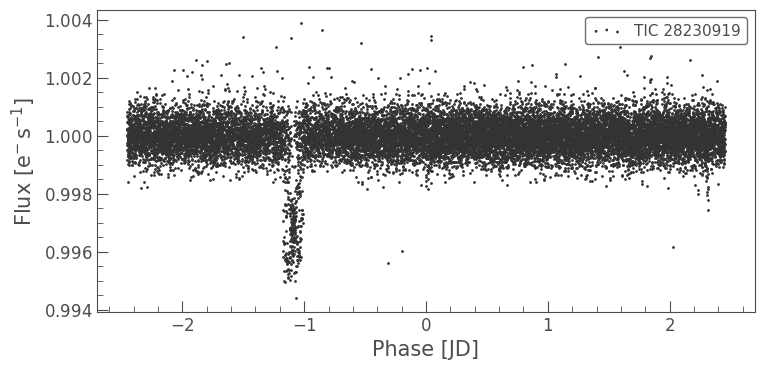

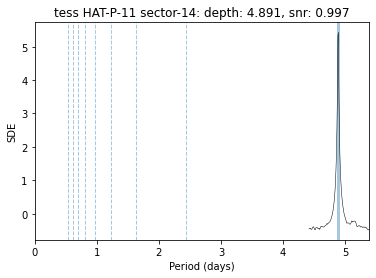

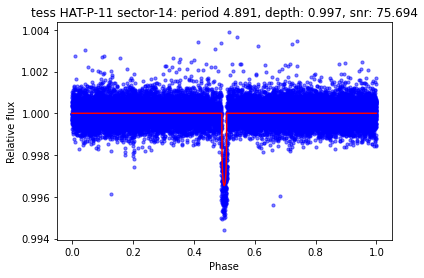

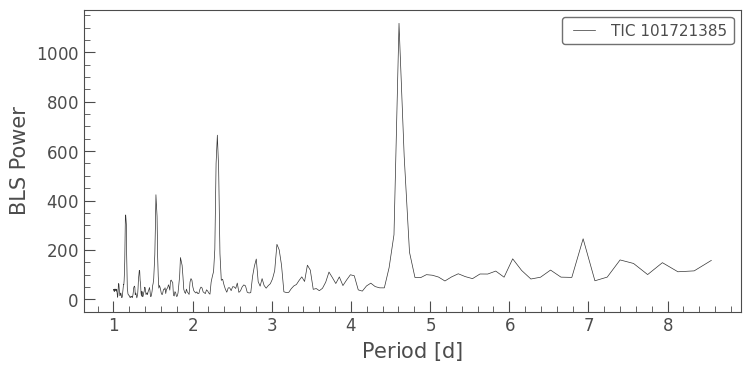

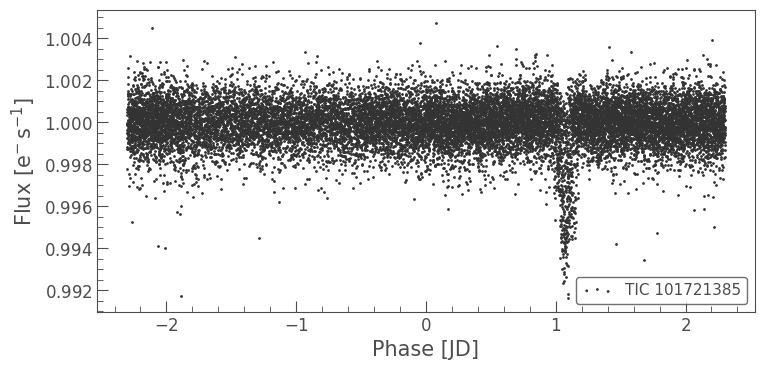

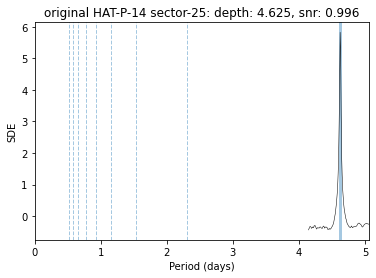

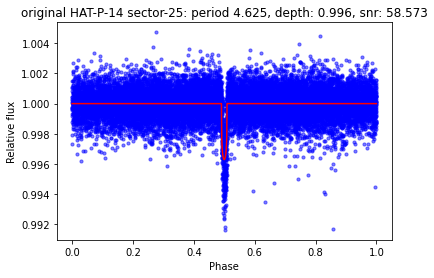

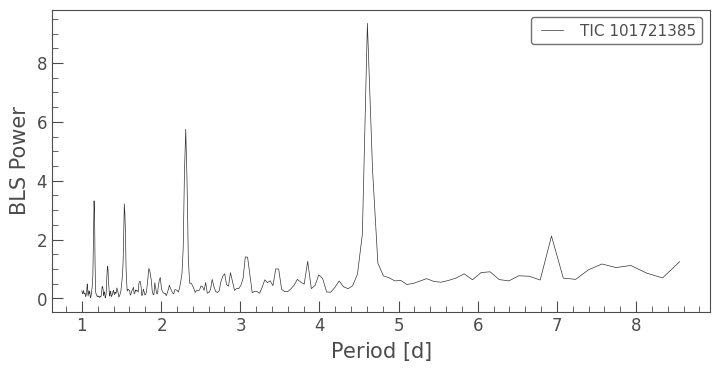

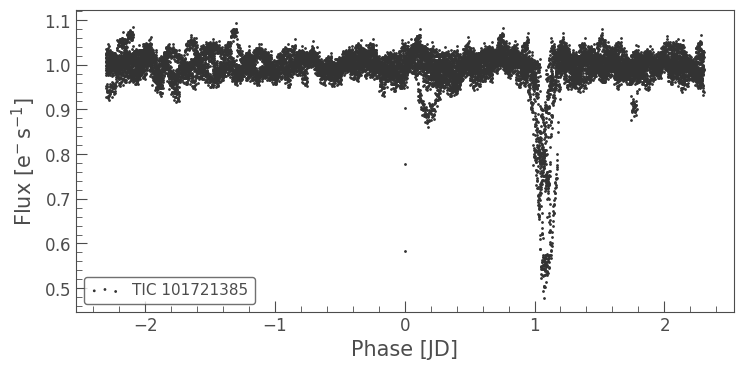

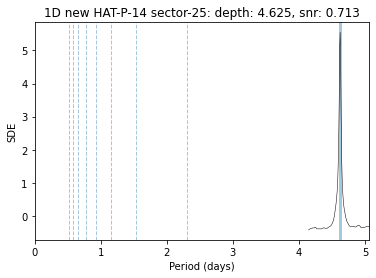

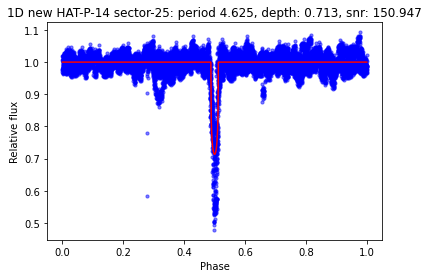

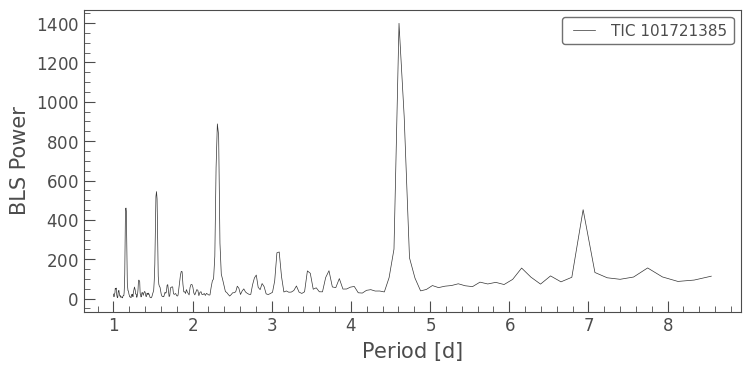

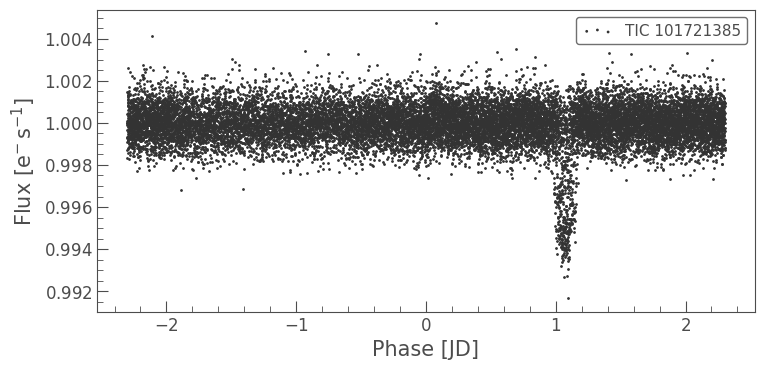

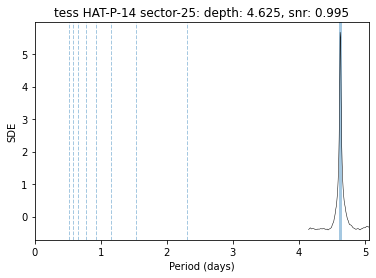

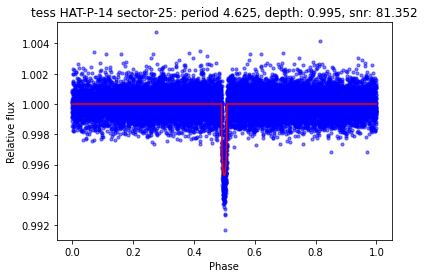

In [75]:
import astropy
import pandas as pd

samples_per_day = 1 + 60 * 24 // 2
x_test_pixelfiles,x_test_lightcurves,tess_test_lightcurves = get_hatp_test_dataset()

for lc_name,lc in x_test_lightcurves.items():
  original_lc2 = lc.flatten(samples_per_day)

  tess_lc2 = tess_test_lightcurves[lc_name]
  tess_lc2 = tess_lc2.flatten(samples_per_day)

  #get 1d flux series
  original_lc_flux2 = np.nan_to_num(original_lc2.flux.value,nan=1)

  #pad flux for reshape
  pad_size = WINDOW_SIZE-len(original_lc2) % WINDOW_SIZE

  padded_flux = np.pad(original_lc_flux2,(0, pad_size), constant_values=(1))
   
  #normalize
  padded_flux = (padded_flux - np.min(padded_flux,axis=0))/(np.max(padded_flux,axis=0)-np.min(padded_flux,axis=0))

  padded_flux = np.reshape(padded_flux, (-1,len(padded_flux),1))

  #test flux with trained 1d cnn
  new_flux = smodel(padded_flux)

  #reshape trained flux to 1d sereis
  new_flux = np.reshape(new_flux,(new_flux.shape[0] * new_flux.shape[1],))

  #crop 1d padded flux to orginal size
  new_flux = new_flux[:len(new_flux)-pad_size]

  # add electron/s units back to the flux value
  new_flux = astropy.units.Quantity(new_flux, original_lc2.flux.unit)

  #create new trained lightcurve
  new_lc = lk.LightCurve(time=original_lc2.time, flux=new_flux, label=original_lc2.label)

  flat_new_lc = new_lc.flatten(samples_per_day)
  
  print("plotting old flux to denoise")
  fit_and_report(original_lc2, lc_name,"original")

  print("plotting new flux")
  fit_and_report(flat_new_lc, lc_name,"1D new")

  print("plotting tess model true flux")
  fit_and_report(tess_lc2, lc_name, "tess")
 